In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import os
import struct
import numpy as np




In [3]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable

In [4]:
from glow import thops
from glow import modules
from glow import models
from glow.config import JsonConfig
import cv2

glow/utils.py:7: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/usr/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/usr/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python2.7/dist-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/usr/local/lib/python2.7/dist-packages/tornado/ioloop.py", line 1065, in start
    

In [5]:

def load_mnist(path, kind='train'):
    """Load MNIST data from `path`"""
    labels_path = os.path.join(path,
                               '%s-labels-idx1-ubyte'
                               % kind)
    images_path = os.path.join(path,
                               '%s-images-idx3-ubyte'
                               % kind)
    with open(labels_path, 'rb') as lbpath:
        magic, n = struct.unpack('>II',
                                 lbpath.read(8))
        labels = np.fromfile(lbpath,
                             dtype=np.uint8)

    with open(images_path, 'rb') as imgpath:
        magic, num, rows, cols = struct.unpack('>IIII',
                                               imgpath.read(16))
        images = np.fromfile(imgpath,
                             dtype=np.uint8).reshape((len(labels),28,28))

    return images, labels

In [6]:
X_train, y_train = load_mnist('./data')
                              
X_test, y_test = load_mnist('./data',kind='t10k')
print(X_test.shape,y_test.shape)

(10000, 28, 28) (10000,)


In [7]:
X_train_32 = np.zeros((len(X_train),32,32))
X_test_32 = np.zeros((len(X_test),32,32))

In [8]:
for i in range (len(X_train)):
    X_train_32[i] = cv2.resize(X_train[i],(32,32),interpolation = cv2.INTER_LINEAR)

In [9]:
for i in range (len(X_test)):
    X_test_32[i] = cv2.resize(X_test[i],(32,32),interpolation = cv2.INTER_LINEAR)

In [10]:
def imgs_show_norm(imgs,row,col):
    fig,ax = plt.subplots(nrows=row,ncols=col,sharex=True,sharey=True)
    ax = ax.flatten()
    for i in range(row*col):
        img = imgs[i]
        min = np.min(img)
#         print('min = ',min)
        img = np.subtract(img,min) # 0->
        max = np.max(img)
#         print('max =',max)
        img = np.divide(img,max)
        
        ax[i].imshow(img,cmap='Greys', interpolation='nearest')
    
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    plt.tight_layout()
    plt.show()

In [11]:
def img_show_norm(img):
    min_ = np.min(img)
#     print('min = ',min_)
    img = np.subtract(img,min_) # 0->
    max_ = np.amax(a = img,keepdims=False)
#     print('max =',max_)
    img = np.divide(img,max_)  # 0->1
#     print(img)
    plt.figure(figsize=(1,1))
    plt.imshow(img,cmap='Greys',interpolation='nearest')

In [12]:
def img_show(img):
    plt.figure(figsize=(1,1))
    plt.imshow(img,cmap='Greys',interpolation='nearest')
    

In [13]:
def imgs_show(imgs,row,col):
    fig,ax = plt.subplots(nrows=row,ncols=col,sharex=True,sharey=True)
    ax = ax.flatten()
    for i in range(row*col):
        img = imgs[i]
        
        ax[i].imshow(img,cmap='Greys', interpolation='nearest')
    
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    plt.tight_layout()
    plt.show()
    
    

(60000, 32, 32)
(10000, 32, 32)


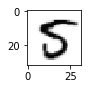

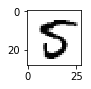

In [14]:
# img_test = cv2.resize(X_train[1],(32,32),interpolation = cv2.INTER_LINEAR)
img_show(X_train_32[11980])

img_show(X_train[11980])
print(X_train_32.shape)
print(X_test_32.shape)

In [15]:
def normal_minist(img):
    return ((img / 255.0) -0.5)*2

In [16]:
def expend_HWC(img):
    return np.expand_dims(img,axis=3)


In [17]:
def to_CHW(img):
    return np.transpose(img,(0,3,1,2))
def to_HWC(img):
    return np.transpose(img,(0,2,3,1))

In [18]:
#只能运行一次
X_train_nor = expend_HWC(X_train_32)
X_train_nor = normal_minist(X_train_nor)
X_train_nor = to_CHW(X_train_nor)
print(X_train_nor.shape)

X_test_nor = expend_HWC(X_test_32)
X_test_nor = normal_minist(X_test_nor)
X_test_nor = to_CHW(X_test_nor)
print(X_test_nor.shape)




(60000, 1, 32, 32)
(10000, 1, 32, 32)


In [19]:
eval_index = [0,6]
negative_index = [1,2,3,4,5,7,8,9]
classes = 10
nn_index = [-1,1]
def compute_index_logical_equal(inputs,indexs):
    logic_result = (inputs==indexs[0])
    for value in indexs:
        logic_result = np.logical_or(inputs == value,logic_result)
    return logic_result

def compute_index_logical_not_equal(inputs,indexs):
    logic_result = (inputs==indexs[0])
    for value in indexs:
        logic_result = np.logical_or(inputs == value,logic_result)
    return np.logical_not(logic_result)

In [20]:
y_test_te = y_test[:10]
print(y_test_te)
print(compute_index_logical_equal(y_test_te,eval_index))
print(compute_index_logical_not_equal(y_test_te,eval_index))
print(y_test_te[compute_index_logical_equal(y_test_te,eval_index)])

[7 2 1 0 4 1 4 9 5 9]
[False False False  True False False False False False False]
[ True  True  True False  True  True  True  True  True  True]
[0]


test_postitive_lable :  (1938,) [0 0 6 0 6 6 0 0 6 6 0 6 0 0 6 6 6 6 6 0 6 0 6 6 0 6 6 0 6 0 6 6 0 0 0 0 6
 6 0 6 0 6 0 0 6 0 0 0 0 0]
test_nagivate_lable :  (8062,) [7 2 1 4 1 4 9 5 9 9 1 5 9 7 3 4 9 5 4 7 4 1 3 1 3 4 7 2 7 1 2 1 1 7 4 2 3
 5 1 2 4 4 3 5 5 4 1 9 5 7]


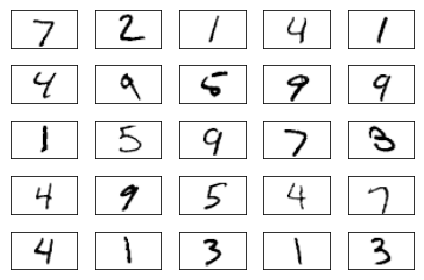

In [21]:
#init test data set
y_test_equal_evla_index = compute_index_logical_equal(y_test,eval_index)
y_test_no_equal_evla_index = compute_index_logical_not_equal(y_test,eval_index)

test_nagivate_lable = y_test[y_test_no_equal_evla_index]
test_nagivate = X_test_nor[y_test_no_equal_evla_index]

test_postitive = X_test_nor[y_test_equal_evla_index]
test_postitive_lable = y_test[y_test_equal_evla_index]
# print(test_postitive[:50])
print("test_postitive_lable : ",test_postitive_lable.shape,test_postitive_lable[:50])
print("test_nagivate_lable : ",test_nagivate_lable.shape,test_nagivate_lable[:50])
imgs_show(np.squeeze(test_nagivate[:25]),5,5)



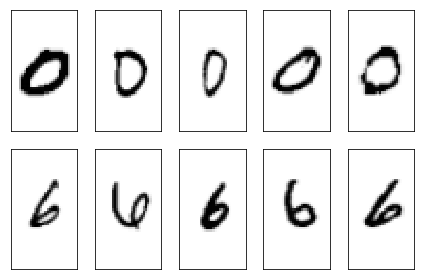

[0 0 0 0 0 6 6 6 6 6]


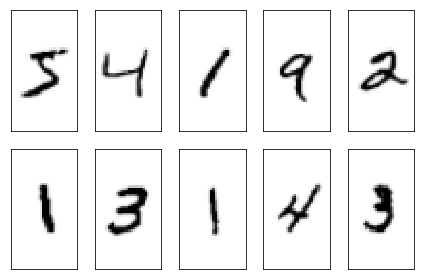

[5 4 1 9 2 1 3 1 4 3]
(48159, 1, 32, 32)


In [22]:
#init train data set
train_positive = []
label_positive =[]
np.random.seed(7)
for value in eval_index :
    
    shuffle_index_positive = np.random.permutation(len(X_train_nor[y_train == value]))
    train_positive.append(X_train_nor[y_train == value][shuffle_index_positive][:5])
    label_positive.append(y_train[y_train == value][shuffle_index_positive][:5])
train_positive = np.concatenate(train_positive)
label_positive = np.concatenate(label_positive)

imgs_show(np.squeeze(train_positive),2,5)
print(label_positive)


train_nagivate = X_train_nor[compute_index_logical_not_equal(y_train ,eval_index)]
label_nagivate = y_train[compute_index_logical_not_equal(y_train , eval_index)]
imgs_show(np.squeeze(train_nagivate[:10]),2,5)
print(label_nagivate[:10])
print(train_nagivate.shape)




In [23]:
def compute_index_logical_equal(inputs,indexs):
    logic_result = (inputs==indexs[0])
    for value in indexs:
        logic_result = np.logical_or(inputs == value,logic_result)
    return logic_result


In [24]:

def test_glow():
    print("[Test]: Glow")
    
    glow = models.Glow(JsonConfig("hparams/celeba_test.json"))
    # img = cv2.imread("pictures/tsuki.jpeg")
    # img = cv2.resize(img, (32, 32))
    # img = (img / 255.0).astype(np.float32)
    # img = img[:, :, ::-1].transpose(2, 0, 1)
    # x = torch.Tensor([img]*8)
    
    x = torch.Tensor(train_positive)
    print('x.size = ', x.size())

    batch_size = 10
    nb_digits = 10
    y = torch.Tensor(label_positive).long()
    print('y = ',y)
    print('y.view(-1,1) = ', y.view(-1,1))
    y_onehot = torch.FloatTensor(batch_size, nb_digits)
    y_onehot.zero_()
    y_onehot.scatter_(1, y.view(-1,1), 1)
    print('y_onehot:', y_onehot)


    z, det, y_logits = glow(x=x, y_onehot=y_onehot)
    print(z.size())
    print(det)

    print(models.Glow.loss_generative(det))
    print('y_logits =  ',y_logits)
    print(models.Glow.loss_class(y_logits,y))


In [25]:
test_glow()

[Test]: Glow
x.size =  torch.Size([10, 1, 32, 32])
y =  tensor([0, 0, 0, 0, 0, 6, 6, 6, 6, 6])
y.view(-1,1) =  tensor([[0],
        [0],
        [0],
        [0],
        [0],
        [6],
        [6],
        [6],
        [6],
        [6]])
y_onehot: tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]])


/usr/local/lib/python2.7/dist-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


torch.Size([10, 16, 4, 4])
tensor([8.9454, 8.8144, 8.6056, 8.7379, 8.7524, 8.6361, 8.7277, 8.5796, 8.6761,
        8.6722], grad_fn=<DivBackward0>)
tensor(8.7148, grad_fn=<MeanBackward1>)
y_logits =   tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], grad_fn=<ThMulBackward>)
tensor(2.3026, grad_fn=<NllLossBackward>)


In [26]:
def getnext(train_x,train_y,batch_size):
    batchs = len(train_y) // batch_size
    print(len(train_y),batchs)

    for i in range(batchs):
        x = train_x[batch_size * i : batch_size * (i+1)]
        y = train_y[batch_size * i : batch_size * (i+1)]
        yield x,y
        

In [27]:
def get_nagivate_next(train_positive,train_nagivate):
    batch_size = len(train_positive) 
    batchs = len(train_nagivate) // batch_size
    print(len(train_nagivate),batchs)
    
    for i in range(batchs):
        x = np.concatenate((train_positive,train_nagivate[batch_size * i : batch_size * (i+1)]))
        y = np.concatenate((np.zeros(batch_size),np.ones(batch_size)))
        shuf_index = np.random.permutation(len(y))
        x = x[shuf_index]
        y = y[shuf_index]
        
        
        yield x ,y 
        

In [28]:
def get_nagivate_batch_next(train_positive,train_nagivate,batch_size):
#     batch_size = len(train_positive) 
    batchs = len(train_nagivate) // batch_size
    print(len(train_nagivate),batchs)
    
    for i in range(batchs):
        x = np.concatenate((train_positive,train_nagivate[batch_size * i : batch_size * (i+1)]))
        y = np.concatenate((np.zeros(len(train_positive)),np.ones(len(train_nagivate))))
        shuf_index = np.random.permutation(len(x))
        x = x[shuf_index]
        y = y[shuf_index]
        
        
        yield x ,y 

In [29]:
def get_next_posi_nag(train_positive,train_nagivate,label_positive, label_nagivate ,batch_size):
#     batch_size = len(train_positive) 
    batchs = len(train_nagivate) // batch_size
    print(len(train_nagivate),batchs)
    
    for i in range(batchs):
        x = np.concatenate((train_positive,train_nagivate[batch_size * i : batch_size * (i+1)]))
        y = np.concatenate((label_positive,label_nagivate[batch_size * i : batch_size * (i+1)]))
        shuf_index = np.random.permutation(len(x))
        x = x[shuf_index]
        y = y[shuf_index]
        
        
        yield x ,y 

In [30]:
def get_next_pn_label(train_positive,train_nagivate,label_positive, label_nagivate):

    class_index_num =[]
    for i in range(1,10):
        class_index_num.append(len(train_nagivate[label_nagivate == i]))
    class_index_num = np.array(class_index_num)
    print('class_index_num = ',class_index_num)
    min_index_num = np.min(class_index_num)
    print('min_index_num = ',min_index_num)
    max_index_num = np.max(class_index_num)
    print('max_index_num = ',max_index_num)
    max_index_class = np.argmax(class_index_num) + 1
    print('max_index_class = ',max_index_class)
    batch_size = 2
    batchs = min_index_num // batch_size
    print('batchs = ',batchs)
    
    
    
    
    
    for i in range(batchs):
        x = train_positive
        y = label_positive
        for class_index in range(1,10):
            
            # batch_index < class len
            if batch_size * (i+1) <= class_index_num[class_index - 1] :
                
                x = np.concatenate( (x,train_nagivate[label_nagivate == class_index][batch_size * i : batch_size * (i+1)]))
                y = np.concatenate((y,label_nagivate[label_nagivate == class_index][batch_size * i : batch_size * (i+1)]))
        
        if len(x) < (3 * len(train_positive)) :
            x = np.concatenate((x,train_nagivate[label_nagivate == max_index_class][batch_size * (i+1) : batch_size * (i+2)]))
            y = np.concatenate((y,label_nagivate[label_nagivate == max_index_class][batch_size * (i+1) : batch_size * (i+2)]))

        shuf_index = np.random.permutation(len(x))
        x = x[shuf_index]
        y = y[shuf_index]
        
        
        yield x,y 


In [31]:
def get_next_pn_label2(train_positive,train_nagivate,label_positive, label_nagivate):

    class_index_num =[]
    for value in negative_index:
        class_index_num.append(len(train_nagivate[label_nagivate == value]))
    
    class_index_num = np.array(class_index_num)
    # class_index_num = np.sort(class_index_num)
    print('class_index_num = ',class_index_num)
    
    sort_index_num = np.argsort(class_index_num)
    print('sort_index_num = ',sort_index_num)
    
    min_index_num = class_index_num[sort_index_num[0]]
    max_index_num = class_index_num[sort_index_num[-1]]
    print('min_index_num = ',min_index_num)
    print('max_index_num = ',max_index_num)
    
    max_index_class = negative_index[sort_index_num[-1]]
    max_second_index_class = negative_index[sort_index_num[-2]]
    print('max_index_class = ',max_index_class)
    print('max_second_index_class = ',max_second_index_class)
    
    batch_size = 2
    batchs = min_index_num // batch_size
    print('batchs = ',batchs)
    
    
    
    for i in range(batchs):
        x = []
        y = []
        x.append(train_positive)  
        y.append(label_positive)
        
        for sor_index in sort_index_num :
                class_index = negative_index[sor_index]
#                 print(class_index)
                x.append(train_nagivate[label_nagivate == class_index][batch_size * i : batch_size * (i+1)])
                y.append(label_nagivate[label_nagivate == class_index][batch_size * i : batch_size * (i+1)])
        
        
        x.append(train_nagivate[label_nagivate == max_index_class][-(batch_size * (i+2)):-(batch_size * (i+1)) ])
        y.append(label_nagivate[label_nagivate == max_index_class][-(batch_size * (i+2)):-(batch_size * (i+1)) ])
#         print(label_nagivate[(-batch_size * (i+2)):-2])
        x.append(train_nagivate[label_nagivate == max_second_index_class][-(batch_size * (i+2)):-(batch_size * (i+1)) ])
        y.append(label_nagivate[label_nagivate == max_second_index_class][-(batch_size * (i+2)):-(batch_size * (i+1)) ])
        
#         for i in range(len(x)):
#             print(x[i].shape)
        x = np.concatenate(x)
        y = np.concatenate(y)
        shuf_index = np.random.permutation(len(x))
        x = x[shuf_index]
        y = y[shuf_index]
        
        
        yield x,y 

In [32]:
#     train_1 = train_nagivate[y_train == 1]
#     print("train_1.shape = ",train_1.shape)

#     train_2 = train_nagivate[y_train == 2]
#     print("train_2.shape = ",train_2.shape)

#     train_3 = train_nagivate[y_train == 3]
#     print("train_3.shape = ",train_3.shape)

#     train_4 = train_nagivate[y_train == 4]
#     print("train_0.shape = ",train_4.shape)


#     train_5 = train_nagivate[y_train == 5]
#     print("train_0.shape = ",train_5.shape)


#     train_6 = train_nagivate[y_train == 6]
#     print("train_6.shape = ",train_6.shape)

#     train_7 = train_nagivate[y_train == 7]
#     print("train_7.shape = ",train_7.shape)


#     train_8 = train_nagivate[y_train == 8]
#     print("train_8.shape = ",train_8.shape)


#     train_9 = train_nagivate[y_train == 9]
#     print("train_9.shape = ",train_9.shape)
                               
# train_0.shape =  (5923, 1, 28, 28)
# train_1.shape =  (6742, 1, 28, 28)
# train_2.shape =  (5958, 1, 28, 28)
# train_3.shape =  (6131, 1, 28, 28)
# train_4.shape =  (5842, 1, 28, 28)
# train_5.shape =  (5421, 1, 28, 28)
# train_6.shape =  (5918, 1, 28, 28)
# train_7.shape =  (6265, 1, 28, 28)
# train_8.shape =  (5851, 1, 28, 28)
# train_9.shape =  (5949, 1, 28, 28)

100 1
(96, 1, 32, 32)
[5 3 1 3 8 9 7 9 7 5 4 1 7 2 5 7 6 3 3 5 7 9 1 0 8 3 4 1 9 6 0 9 8 7 8 7 4
 9 5 4 8 2 2 1 4 3 1 3 2 7 1 7 1 0 5 8 9 8 4 2 1 8 2 2 1 2 3 5 2 1 3 6 9 4
 9 2 7 2 7 9 4 5 9 8 6 4 9 3 0 2 6 5 0 9 9 7]


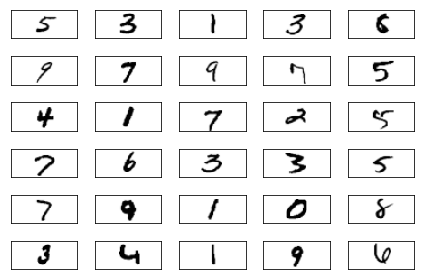

In [33]:
datas = get_next_posi_nag(train_positive,train_nagivate[1100:1200],label_positive,label_nagivate[1100:1200],86)
for x,y in datas:
    print(x.shape)
    
    print(y)
    imgs_show(np.squeeze( x),6,5)


In [34]:
batch_size = 30
nb_digits = 10
net_auto = models.Glow(JsonConfig("hparams/celeba_minist.json"))



In [37]:

net_auto.load_state_dict(torch.load('model_few_shot_class_only234.pt'))
use_cuda = torch.cuda.is_available()
torch.manual_seed(666)
device = torch.device("cuda" if use_cuda else "cpu")
net_auto.to(device)
net_auto.float()


criterion = nn.MSELoss()
optimizer = optim.SGD(net_auto.parameters(),lr=0.001,momentum=0.9)


In [ ]:
#X_train_nor


for epoch in range(50):
    #train:
    net_auto.train()
    shuf_nagivate = np.random.permutation(len(train_nagivate))
    train_nagivate = train_nagivate[shuf_nagivate]
    label_nagivate = label_nagivate[shuf_nagivate]
#     datas = get_next_posi_nag(train_positive,train_nagivate,label_positive,label_nagivate, 10)
    datas = get_next_pn_label2(train_positive,train_nagivate,label_positive,label_nagivate)
    
    trainloss_g = 0
    trainloss_c = 0
    
    for x,y in datas:
        inputs ,lables = torch.from_numpy(x).float().to(device),\
            torch.from_numpy(y).long().to(device)
        
        y_onehot = torch.FloatTensor(batch_size, nb_digits).to(device)
        y_onehot.zero_()
        y_onehot.scatter_(1, lables.view(-1,1), 1)
#         print('y_onehot:', y_onehot)


       

        optimizer.zero_grad()
        z, det, y_logits = net_auto(x=inputs, y_onehot=y_onehot)
#         print(z.size())
#         print(det)
        loss_g = models.Glow.loss_generative(det)
        loss_c = models.Glow.loss_class(y_logits,lables)
        print('loss_g = ',loss_g.item())
        print('loss_c =  ',loss_c.item())
        loss = loss_g + loss_c * 0.01
        loss.backward()
        torch.nn.utils.clip_grad_value_(net_auto.parameters(), 5)
        torch.nn.utils.clip_grad_norm_(net_auto.parameters(), 100)
        
        
        trainloss_g += loss_g.item()
        trainloss_c += loss_c.item()
#         print("net_auto.conv_d1 grad:",net_auto.conv_d1.weight.grad)
        
#         print("after net_auto.conv_1 grad:",net_auto.conv1.weight.grad)
        optimizer.step()
        
    print('%d  gloss: %.3f, class loss:%.3f' % (epoch ,  trainloss_g,trainloss_c))
    
    
    torch.save(net_auto.state_dict(),'model_few_shot_class_only2'+str(epoch)+'.pt')
    


class_index_num =  [6742 5958 6131 5842 5421 6265 5851 5949]
sort_index_num =  [4 3 6 7 1 2 5 0]
min_index_num =  5421
max_index_num =  6742
max_index_class =  1
max_second_index_class =  7
batchs =  2710
loss_g =  3.2303147316
loss_c =   0.000466823577881
loss_g =  3.19007372856
loss_c =   0.000205993652344
loss_g =  3.21835541725
loss_c =   0.00488746957853
loss_g =  3.25602960587
loss_c =   0.000204149881029
loss_g =  3.2446269989
loss_c =   0.000114790600492
loss_g =  3.2479531765
loss_c =   0.015336974524
loss_g =  3.19091510773
loss_c =   0.000696372997481
loss_g =  3.24421215057
loss_c =   2.1998088414e-05
loss_g =  3.25896596909
loss_c =   0.00158605573233
loss_g =  3.22178220749
loss_c =   9.07897920115e-05
loss_g =  3.23420500755
loss_c =   0.00012035369582
loss_g =  3.2199883461
loss_c =   0.000588734925259
loss_g =  3.21709346771
loss_c =   0.00460046110675
loss_g =  3.18869948387
loss_c =   0.000163841250469
loss_g =  3.18496775627
loss_c =   0.0652057826519
loss_g =  3.29

loss_g =  3.2474822998
loss_c =   0.00505024613813
loss_g =  3.25653719902
loss_c =   0.0013569832081
loss_g =  3.26032519341
loss_c =   0.00147851312067
loss_g =  3.32633328438
loss_c =   0.00932542514056
loss_g =  3.31251764297
loss_c =   0.0086708702147
loss_g =  3.31046557426
loss_c =   0.000214354193304
loss_g =  3.36779999733
loss_c =   0.000249830889516
loss_g =  3.24320816994
loss_c =   8.57671111589e-05
loss_g =  3.37536692619
loss_c =   0.00018949508376
loss_g =  3.2374560833
loss_c =   0.00160174374469
loss_g =  3.26153302193
loss_c =   0.0212181322277
loss_g =  3.27030396461
loss_c =   0.000409857428167
loss_g =  3.21343207359
loss_c =   0.00610861787573
loss_g =  3.26416730881
loss_c =   0.000140349075082
loss_g =  3.17713236809
loss_c =   0.000139872237924
loss_g =  3.25169157982
loss_c =   0.00159800844267
loss_g =  3.17431306839
loss_c =   0.00323588051833
loss_g =  3.23452281952
loss_c =   0.00347986212
loss_g =  3.14906954765
loss_c =   0.00205834698863
loss_g =  3.21

loss_g =  3.12419033051
loss_c =   0.00218242011033
loss_g =  3.13574385643
loss_c =   0.0253363847733
loss_g =  3.14099121094
loss_c =   0.000200557711651
loss_g =  3.14738321304
loss_c =   0.0032970905304
loss_g =  3.17099499702
loss_c =   0.00703198136762
loss_g =  3.257822752
loss_c =   3.43322744811e-06
loss_g =  3.27662944794
loss_c =   0.000381533318432
loss_g =  3.29185724258
loss_c =   0.0174498874694
loss_g =  3.17854094505
loss_c =   8.55763719301e-05
loss_g =  3.32983207703
loss_c =   8.71340453159e-05
loss_g =  3.27918410301
loss_c =   0.00726453447714
loss_g =  3.32319641113
loss_c =   0.00143574073445
loss_g =  3.25804591179
loss_c =   0.00138200121
loss_g =  3.31287240982
loss_c =   0.00619077682495
loss_g =  3.14758324623
loss_c =   0.00342032103799
loss_g =  3.29432010651
loss_c =   0.00344840693288
loss_g =  3.26510858536
loss_c =   0.00353576336056
loss_g =  3.25959205627
loss_c =   0.000796365726274
loss_g =  3.29479670525
loss_c =   3.60806770914e-05
loss_g =  3.1

loss_g =  3.14370417595
loss_c =   0.000101153054857
loss_g =  3.11258506775
loss_c =   0.000355211901478
loss_g =  3.14999699593
loss_c =   0.000858306884766
loss_g =  3.22750329971
loss_c =   0.0013307412155
loss_g =  3.22189426422
loss_c =   0.00632459344342
loss_g =  3.17400765419
loss_c =   6.80923476466e-05
loss_g =  3.26330924034
loss_c =   0.00105304713361
loss_g =  3.29223227501
loss_c =   0.00322553305887
loss_g =  3.18120026588
loss_c =   0.00105193455238
loss_g =  3.26372694969
loss_c =   0.000651232374366
loss_g =  3.23656821251
loss_c =   8.71022530191e-06
loss_g =  3.280346632
loss_c =   0.000182787582162
loss_g =  3.33815360069
loss_c =   0.0150513174012
loss_g =  3.29114818573
loss_c =   0.0116610210389
loss_g =  3.24582695961
loss_c =   0.000330130249495
loss_g =  3.26155996323
loss_c =   0.00156416895334
loss_g =  3.20438742638
loss_c =   6.39915451757e-05
loss_g =  3.27697777748
loss_c =   0.0103393550962
loss_g =  3.23958778381
loss_c =   0.000285530084511
loss_g =

loss_g =  3.18334174156
loss_c =   0.00461942376569
loss_g =  3.15797805786
loss_c =   0.000323136657244
loss_g =  3.19667983055
loss_c =   2.22524013225e-05
loss_g =  3.16901373863
loss_c =   0.000418313342379
loss_g =  3.21410179138
loss_c =   0.000107765197754
loss_g =  3.13684272766
loss_c =   0.00137456262019
loss_g =  3.12009501457
loss_c =   5.63939429412e-05
loss_g =  3.18587589264
loss_c =   0.00175042147748
loss_g =  3.14780306816
loss_c =   0.000312900549034
loss_g =  3.21013641357
loss_c =   0.000492413819302
loss_g =  3.18842172623
loss_c =   0.000220680230996
loss_g =  3.15133500099
loss_c =   0.000688012456521
loss_g =  3.24196338654
loss_c =   0.0106605207548
loss_g =  3.28086090088
loss_c =   0.0501493699849
loss_g =  3.13860201836
loss_c =   0.00250062951818
loss_g =  3.28959298134
loss_c =   0.00422652577981
loss_g =  3.3174021244
loss_c =   0.00407794304192
loss_g =  3.20150947571
loss_c =   0.000412925088312
loss_g =  3.26889419556
loss_c =   0.000223541253945
loss

loss_g =  3.14676070213
loss_c =   3.45547996403e-05
loss_g =  3.08285045624
loss_c =   0.000809669494629
loss_g =  3.16222858429
loss_c =   0.000538635242265
loss_g =  3.11720132828
loss_c =   0.000229104363825
loss_g =  3.19250798225
loss_c =   4.86373892272e-06
loss_g =  3.20954370499
loss_c =   0.00259943003766
loss_g =  3.1441013813
loss_c =   0.000646384549327
loss_g =  3.20560121536
loss_c =   0.0043659848161
loss_g =  3.12944984436
loss_c =   0.000425751990406
loss_g =  3.18227863312
loss_c =   0.000218137109187
loss_g =  3.18861198425
loss_c =   0.000895023345947
loss_g =  3.14596438408
loss_c =   0.000222746530198
loss_g =  3.11961627007
loss_c =   0.000776894914452
loss_g =  3.13215756416
loss_c =   0.000957059848588
loss_g =  3.09640884399
loss_c =   0.00335361156613
loss_g =  3.1902012825
loss_c =   0.000990533852018
loss_g =  3.15314555168
loss_c =   0.00893559493124
loss_g =  3.23206686974
loss_c =   0.0111250560731
loss_g =  3.17512130737
loss_c =   0.000234254199313
lo

loss_g =  3.23610544205
loss_c =   8.02675858722e-05
loss_g =  3.17635011673
loss_c =   0.000370915717212
loss_g =  3.20348262787
loss_c =   0.000365257263184
loss_g =  3.20752620697
loss_c =   1.9772847736e-05
loss_g =  3.24591183662
loss_c =   0.00120096211322
loss_g =  3.17081975937
loss_c =   0.00193214416504
loss_g =  3.19091510773
loss_c =   0.000356149685103
loss_g =  3.18754410744
loss_c =   0.00270560593344
loss_g =  3.23538970947
loss_c =   0.000106652580143
loss_g =  3.19736361504
loss_c =   0.000374666851712
loss_g =  3.24276399612
loss_c =   0.00156113307457
loss_g =  3.21220588684
loss_c =   0.000433635723311
loss_g =  3.19287514687
loss_c =   0.000228500372032
loss_g =  3.17109942436
loss_c =   0.000864060712047
loss_g =  3.17184853554
loss_c =   0.0105994064361
loss_g =  3.23757624626
loss_c =   0.000215752923395
loss_g =  3.19117665291
loss_c =   0.0102960821241
loss_g =  3.25847959518
loss_c =   0.0562388412654
loss_g =  3.20643496513
loss_c =   7.13348417776e-05
loss

loss_g =  3.16878652573
loss_c =   0.000854333222378
loss_g =  3.1221101284
loss_c =   0.000378990167519
loss_g =  3.13660860062
loss_c =   0.0135121978819
loss_g =  3.16023993492
loss_c =   0.000300820654957
loss_g =  3.16979837418
loss_c =   0.000696976960171
loss_g =  3.13376498222
loss_c =   0.00228611635976
loss_g =  3.15820217133
loss_c =   0.00646498193964
loss_g =  3.17863488197
loss_c =   0.0170603431761
loss_g =  3.15959572792
loss_c =   0.048093829304
loss_g =  3.15748143196
loss_c =   0.000225734707783
loss_g =  3.19426012039
loss_c =   0.000161361691426
loss_g =  3.13009119034
loss_c =   0.0698616355658
loss_g =  3.16940522194
loss_c =   0.0347435958683
loss_g =  3.17174434662
loss_c =   0.00588890723884
loss_g =  3.2021651268
loss_c =   0.000264739996055
loss_g =  3.24301981926
loss_c =   0.000256220489973
loss_g =  3.10205745697
loss_c =   2.58445743384e-05
loss_g =  3.15378236771
loss_c =   0.000313631695462
loss_g =  3.13394331932
loss_c =   0.000365034735296
loss_g = 

loss_g =  3.22414875031
loss_c =   0.00136478745844
loss_g =  3.21505570412
loss_c =   9.49223831412e-05
loss_g =  3.2155418396
loss_c =   0.00993506144732
loss_g =  3.22348833084
loss_c =   0.00188926060218
loss_g =  3.23484802246
loss_c =   0.00138060247991
loss_g =  3.24220013618
loss_c =   0.00199505477212
loss_g =  3.26089167595
loss_c =   0.0127864992246
loss_g =  3.12204837799
loss_c =   0.000189208978554
loss_g =  3.3027381897
loss_c =   0.000734424567781
loss_g =  3.18966913223
loss_c =   0.00487163849175
loss_g =  3.29797458649
loss_c =   0.0603292062879
loss_g =  3.36795806885
loss_c =   0.000478331261547
loss_g =  3.389067173
loss_c =   0.0238716118038
loss_g =  3.44362998009
loss_c =   0.0519645996392
loss_g =  3.27186846733
loss_c =   0.0123826349154
loss_g =  3.45784568787
loss_c =   0.00168447499163
loss_g =  3.34852409363
loss_c =   0.000130208340124
loss_g =  3.35264968872
loss_c =   0.00876787491143
loss_g =  3.36607527733
loss_c =   0.00461473455653
loss_g =  3.3431

loss_g =  3.1380674839
loss_c =   0.000920041406062
loss_g =  3.19238066673
loss_c =   0.000245030707447
loss_g =  3.208152771
loss_c =   0.00389523501508
loss_g =  3.11449146271
loss_c =   0.00466852169484
loss_g =  3.19805169106
loss_c =   0.0652626603842
loss_g =  3.15645313263
loss_c =   0.00471936864778
loss_g =  3.20026087761
loss_c =   0.0011236827122
loss_g =  3.24241924286
loss_c =   0.000151093801833
loss_g =  3.20573663712
loss_c =   0.00168231327552
loss_g =  3.18202185631
loss_c =   0.00839705485851
loss_g =  3.1403632164
loss_c =   0.124615974724
loss_g =  3.21122026443
loss_c =   0.0404192432761
loss_g =  3.23576998711
loss_c =   0.00572811765596
loss_g =  3.21819281578
loss_c =   0.00048173268442
loss_g =  3.18062472343
loss_c =   0.00795036926866
loss_g =  3.2579460144
loss_c =   0.00333895673975
loss_g =  3.21309804916
loss_c =   0.00925899390131
loss_g =  3.2362601757
loss_c =   0.00155676202849
loss_g =  3.25435876846
loss_c =   0.000362141930964
loss_g =  3.2923104

loss_g =  3.26928710938
loss_c =   0.00540033960715
loss_g =  3.2460808754
loss_c =   0.00210493407212
loss_g =  3.25544023514
loss_c =   0.000104395548988
loss_g =  3.15731954575
loss_c =   0.00116211571731
loss_g =  3.22709989548
loss_c =   0.0581076778471
loss_g =  3.21357798576
loss_c =   0.000386873871321
loss_g =  3.21085190773
loss_c =   0.00697256717831
loss_g =  3.29816007614
loss_c =   0.00668074283749
loss_g =  3.21965241432
loss_c =   0.000247065239819
loss_g =  3.15513825417
loss_c =   0.00680556287989
loss_g =  3.22896647453
loss_c =   0.000622272491455
loss_g =  3.21238303185
loss_c =   9.32375623961e-05
loss_g =  3.1206703186
loss_c =   0.000927718472667
loss_g =  3.12346076965
loss_c =   0.00124033296015
loss_g =  3.19321370125
loss_c =   0.0176662690938
loss_g =  3.09864211082
loss_c =   0.000850868236739
loss_g =  3.16060400009
loss_c =   0.00923794135451
loss_g =  3.14093160629
loss_c =   0.00677342433482
loss_g =  3.08946442604
loss_c =   0.0393683761358
loss_g =  

loss_g =  3.24426436424
loss_c =   0.000456110632513
loss_g =  3.19842886925
loss_c =   0.0046360809356
loss_g =  3.2029645443
loss_c =   0.0161912608892
loss_g =  3.2011218071
loss_c =   0.00195147201885
loss_g =  3.12324690819
loss_c =   0.114862419665
loss_g =  3.12159824371
loss_c =   0.00146668753587
loss_g =  3.15544891357
loss_c =   0.0678343623877
loss_g =  3.19060206413
loss_c =   0.000448894512374
loss_g =  3.14367008209
loss_c =   0.0181680675596
loss_g =  3.22823357582
loss_c =   0.00176725385245
loss_g =  3.14837241173
loss_c =   0.000556818617042
loss_g =  3.14447331429
loss_c =   0.00542693119496
loss_g =  3.17672348022
loss_c =   0.00346250529401
loss_g =  3.16754627228
loss_c =   0.000456428533653
loss_g =  3.11497426033
loss_c =   0.00133492157329
loss_g =  3.17142224312
loss_c =   0.0212836582214
loss_g =  3.17136883736
loss_c =   0.00151535670739
loss_g =  3.14789104462
loss_c =   0.000277264916804
loss_g =  3.17517328262
loss_c =   0.00438534421846
loss_g =  3.1705

loss_g =  3.08240628242
loss_c =   0.000191243496374
loss_g =  3.18807506561
loss_c =   0.0125221097842
loss_g =  3.15946173668
loss_c =   0.00115890498273
loss_g =  3.08682656288
loss_c =   0.0107622779906
loss_g =  3.1782143116
loss_c =   0.00359799060971
loss_g =  3.15802502632
loss_c =   0.00974570866674
loss_g =  3.17148685455
loss_c =   0.00899073295295
loss_g =  3.18486237526
loss_c =   0.00198775925674
loss_g =  3.10808944702
loss_c =   0.000911744427867
loss_g =  3.16623187065
loss_c =   6.51677473797e-05
loss_g =  3.17171835899
loss_c =   0.00222436594777
loss_g =  3.09535694122
loss_c =   0.000106557206891
loss_g =  3.16884684563
loss_c =   0.034601893276
loss_g =  3.11195540428
loss_c =   0.00130743975751
loss_g =  3.17654561996
loss_c =   0.000772396742832
loss_g =  3.13820886612
loss_c =   5.18163033121e-05
loss_g =  3.1581594944
loss_c =   0.00423700036481
loss_g =  3.10473775864
loss_c =   0.000133800509502
loss_g =  3.14220809937
loss_c =   0.000106175742985
loss_g =  

loss_g =  3.15024828911
loss_c =   0.00862175598741
loss_g =  3.16572737694
loss_c =   0.00118821463548
loss_g =  3.20489406586
loss_c =   0.00144669215661
loss_g =  3.11717629433
loss_c =   0.000190448758076
loss_g =  3.21087098122
loss_c =   0.0017364184605
loss_g =  3.15342307091
loss_c =   0.00796271953732
loss_g =  3.17168927193
loss_c =   0.064158603549
loss_g =  3.17227101326
loss_c =   0.00668330211192
loss_g =  3.22446846962
loss_c =   0.00286766677164
loss_g =  3.17782688141
loss_c =   0.0130573110655
loss_g =  3.22158288956
loss_c =   0.00155175523832
loss_g =  3.17721676826
loss_c =   0.00189166073687
loss_g =  3.19809746742
loss_c =   0.0184995960444
loss_g =  3.16012001038
loss_c =   0.0182809121907
loss_g =  3.21185708046
loss_c =   0.000942516315263
loss_g =  3.32354402542
loss_c =   0.00420983647928
loss_g =  3.21377253532
loss_c =   0.0255581066012
loss_g =  3.29630756378
loss_c =   0.00937558803707
loss_g =  3.19072198868
loss_c =   0.0021276473999
loss_g =  3.322614

loss_g =  3.22061228752
loss_c =   0.00207306537777
loss_g =  3.20074820518
loss_c =   0.0043193497695
loss_g =  3.18070793152
loss_c =   0.00876072235405
loss_g =  3.11466646194
loss_c =   0.00539937010035
loss_g =  3.20429229736
loss_c =   0.0107056777924
loss_g =  3.18021965027
loss_c =   0.000507068645675
loss_g =  3.14216852188
loss_c =   0.0131796356291
loss_g =  3.16995978355
loss_c =   0.0124846938998
loss_g =  3.18626999855
loss_c =   0.00124699273147
loss_g =  3.11697697639
loss_c =   0.00506124505773
loss_g =  3.11147737503
loss_c =   0.00330481538549
loss_g =  3.13778305054
loss_c =   0.001760641695
loss_g =  3.20263028145
loss_c =   0.00632280530408
loss_g =  3.17935371399
loss_c =   0.00171963369939
loss_g =  3.15279150009
loss_c =   0.0108104068786
loss_g =  3.1563808918
loss_c =   0.000469557446195
loss_g =  3.15866351128
loss_c =   0.000618346559349
loss_g =  3.12610697746
loss_c =   0.0260427799076
loss_g =  3.18969464302
loss_c =   0.0482052154839
loss_g =  3.1585328

loss_g =  3.19978380203
loss_c =   0.031134955585
loss_g =  3.16550183296
loss_c =   7.16050490155e-05
loss_g =  3.19808840752
loss_c =   0.00824743881822
loss_g =  3.17103791237
loss_c =   0.0642400234938
loss_g =  3.19385027885
loss_c =   0.000616200792138
loss_g =  3.18939971924
loss_c =   0.000881417596247
loss_g =  3.1747841835
loss_c =   0.019700685516
loss_g =  3.2061355114
loss_c =   0.00104126927909
loss_g =  3.10350608826
loss_c =   0.00103648507502
loss_g =  3.16896510124
loss_c =   0.000350681948476
loss_g =  3.14070224762
loss_c =   0.000392055517295
loss_g =  3.16196250916
loss_c =   0.0153879802674
loss_g =  3.11148500443
loss_c =   0.00266771321185
loss_g =  3.20619416237
loss_c =   0.000308195740217
loss_g =  3.20627999306
loss_c =   0.000127442675875
loss_g =  3.18889856339
loss_c =   0.057283449918
loss_g =  3.24082303047
loss_c =   0.0399581752717
loss_g =  3.19863271713
loss_c =   0.00260812439956
loss_g =  3.20009207726
loss_c =   0.000608030939475
loss_g =  3.153

loss_g =  3.11132717133
loss_c =   0.00451672868803
loss_g =  3.16193771362
loss_c =   0.0370744243264
loss_g =  3.09958744049
loss_c =   0.00104293820914
loss_g =  3.15384435654
loss_c =   0.00974381808192
loss_g =  3.11697506905
loss_c =   0.0196453407407
loss_g =  3.13802623749
loss_c =   0.000810495985206
loss_g =  3.12687587738
loss_c =   0.000101311998151
loss_g =  3.13045477867
loss_c =   0.000867859518621
loss_g =  3.1509616375
loss_c =   0.00342969899066
loss_g =  3.14695453644
loss_c =   0.118181958795
loss_g =  3.12836146355
loss_c =   0.0157759357244
loss_g =  3.16068291664
loss_c =   0.0010207494488
loss_g =  3.16448187828
loss_c =   0.00215438217856
loss_g =  3.19945454597
loss_c =   0.00241489405744
loss_g =  3.18037080765
loss_c =   0.001102383947
loss_g =  3.17982196808
loss_c =   0.00135113403667
loss_g =  3.15458321571
loss_c =   0.0133098280057
loss_g =  3.19086575508
loss_c =   0.00645917234942
loss_g =  3.16910529137
loss_c =   0.00161523814313
loss_g =  3.2182888

loss_g =  3.13152360916
loss_c =   0.0824429988861
loss_g =  3.13327264786
loss_c =   0.0109687093645
loss_g =  3.13493585587
loss_c =   0.037716332823
loss_g =  3.05411911011
loss_c =   0.000498088193126
loss_g =  3.20345520973
loss_c =   0.000117778778076
loss_g =  3.09812235832
loss_c =   0.000245920818998
loss_g =  3.16798233986
loss_c =   0.00269982009195
loss_g =  3.12089967728
loss_c =   0.000276565551758
loss_g =  3.13234496117
loss_c =   9.75926741376e-05
loss_g =  3.14362215996
loss_c =   0.000198443725822
loss_g =  3.24446964264
loss_c =   0.00119508104399
loss_g =  3.29332304001
loss_c =   0.00160582864191
loss_g =  3.51901936531
loss_c =   0.0118118282408
loss_g =  3.46844863892
loss_c =   0.0275603141636
loss_g =  3.31238293648
loss_c =   0.0144120855257
loss_g =  3.20417785645
loss_c =   0.0312683098018
loss_g =  3.2674703598
loss_c =   0.00219858484343
loss_g =  3.39403009415
loss_c =   0.000950670219027
loss_g =  3.22240281105
loss_c =   6.35464966763e-05
loss_g =  3.2

loss_g =  3.20498347282
loss_c =   0.0003612836299
loss_g =  3.21388292313
loss_c =   0.000291442876915
loss_g =  3.14953756332
loss_c =   0.00211398606189
loss_g =  3.17644000053
loss_c =   0.000869401323143
loss_g =  3.20415687561
loss_c =   0.0094393575564
loss_g =  3.17355847359
loss_c =   0.000125153863337
loss_g =  3.21230101585
loss_c =   0.000503476476297
loss_g =  3.17527127266
loss_c =   0.0312351230532
loss_g =  3.20660114288
loss_c =   0.000441519427113
loss_g =  3.18437051773
loss_c =   0.00840344466269
loss_g =  3.21823787689
loss_c =   0.0359751395881
loss_g =  3.22167229652
loss_c =   0.000335534423357
loss_g =  3.14423847198
loss_c =   0.0016026814701
loss_g =  3.21398615837
loss_c =   0.0197453666478
loss_g =  3.18346095085
loss_c =   0.000354448944563
loss_g =  3.21133232117
loss_c =   0.00245018000714
loss_g =  3.2318341732
loss_c =   0.00795485172421
loss_g =  3.15015673637
loss_c =   0.00107650761493
loss_g =  3.14481258392
loss_c =   0.000437037146185
loss_g =  3

loss_g =  3.26674485207
loss_c =   0.0563523434103
loss_g =  3.15418934822
loss_c =   0.0013542175293
loss_g =  3.17360448837
loss_c =   0.000117079420306
loss_g =  3.13639593124
loss_c =   0.0125046409667
loss_g =  3.17842769623
loss_c =   0.00989842414856
loss_g =  3.15832781792
loss_c =   0.260080188513
loss_g =  3.21333599091
loss_c =   0.00106741592754
loss_g =  3.12755274773
loss_c =   0.113695301116
loss_g =  3.19808125496
loss_c =   0.000629425048828
loss_g =  3.21460986137
loss_c =   0.0204971637577
loss_g =  3.18561220169
loss_c =   0.00833570118994
loss_g =  3.22354865074
loss_c =   0.000299835199257
loss_g =  3.15519857407
loss_c =   0.00399311399087
loss_g =  3.18548417091
loss_c =   0.0026271501556
loss_g =  3.1383767128
loss_c =   0.0047146002762
loss_g =  3.19401717186
loss_c =   0.00591214513406
loss_g =  3.13869571686
loss_c =   0.000704940175638
loss_g =  3.1742208004
loss_c =   0.00617138529196
loss_g =  3.17876219749
loss_c =   0.00312426895835
loss_g =  3.11934161

loss_g =  3.14360022545
loss_c =   0.0378542914987
loss_g =  3.16158437729
loss_c =   0.000357214623364
loss_g =  3.1703042984
loss_c =   0.00013427734666
loss_g =  3.13395142555
loss_c =   0.00748853664845
loss_g =  3.15035152435
loss_c =   0.000961303710938
loss_g =  3.13581132889
loss_c =   0.000934791576583
loss_g =  3.16723322868
loss_c =   0.0183499492705
loss_g =  3.16307497025
loss_c =   0.00318713183515
loss_g =  3.14446425438
loss_c =   0.000201733913855
loss_g =  3.1352493763
loss_c =   0.00415279064327
loss_g =  3.17381286621
loss_c =   0.00818985328078
loss_g =  3.2125442028
loss_c =   0.018467919901
loss_g =  3.26708960533
loss_c =   0.00430959044024
loss_g =  3.11289978027
loss_c =   0.000201129907509
loss_g =  3.23167228699
loss_c =   0.00889207515866
loss_g =  3.15024209023
loss_c =   0.0248874425888
loss_g =  3.20915365219
loss_c =   0.0290040653199
loss_g =  3.20371460915
loss_c =   0.00959753990173
loss_g =  3.22967672348
loss_c =   0.0145452497527
loss_g =  3.15939

loss_g =  3.13657283783
loss_c =   0.0502355247736
loss_g =  3.1364467144
loss_c =   0.0187111850828
loss_g =  3.13329839706
loss_c =   0.00384742417373
loss_g =  3.11335945129
loss_c =   0.00940399151295
loss_g =  3.09746479988
loss_c =   0.0346415378153
loss_g =  3.08514261246
loss_c =   0.0076269148849
loss_g =  3.07368922234
loss_c =   0.0083062807098
loss_g =  3.15462684631
loss_c =   0.0048528672196
loss_g =  3.17207598686
loss_c =   0.0681551992893
loss_g =  3.11042833328
loss_c =   0.00195852923207
loss_g =  3.13419818878
loss_c =   0.000995318056084
loss_g =  3.13098978996
loss_c =   0.00323557853699
loss_g =  3.1218483448
loss_c =   0.0171418506652
loss_g =  3.21048235893
loss_c =   0.000504112220369
loss_g =  3.18904232979
loss_c =   0.00103689834941
loss_g =  3.15269684792
loss_c =   0.00533251743764
loss_g =  3.16054272652
loss_c =   0.000868256902322
loss_g =  3.15004658699
loss_c =   0.00401959428564
loss_g =  3.12436413765
loss_c =   0.00865275040269
loss_g =  3.1192338

loss_g =  3.1118979454
loss_c =   0.00226122536696
loss_g =  3.16400408745
loss_c =   0.00234257383272
loss_g =  3.14263558388
loss_c =   0.00543587980792
loss_g =  3.16694760323
loss_c =   0.0208306144923
loss_g =  3.14748477936
loss_c =   0.000326665234752
loss_g =  3.12746500969
loss_c =   0.00515389442444
loss_g =  3.21051168442
loss_c =   0.0025707562454
loss_g =  3.12647676468
loss_c =   0.00015517869906
loss_g =  3.13274765015
loss_c =   0.000511519087013
loss_g =  3.11384606361
loss_c =   0.00161104206927
loss_g =  3.19627046585
loss_c =   0.015600903891
loss_g =  3.26740098
loss_c =   0.0384894385934
loss_g =  3.14733862877
loss_c =   0.0312049072236
loss_g =  3.26141619682
loss_c =   0.000727272010408
loss_g =  3.21450948715
loss_c =   0.0767261534929
loss_g =  3.19901800156
loss_c =   0.0190566387028
loss_g =  3.17562603951
loss_c =   0.0069288732484
loss_g =  3.18559336662
loss_c =   0.000644969928544
loss_g =  3.19551062584
loss_c =   0.00079094566172
loss_g =  3.158607244

loss_g =  3.20609521866
loss_c =   0.0152590190992
loss_g =  3.16712093353
loss_c =   0.0034923076164
loss_g =  3.15142822266
loss_c =   0.00342887244187
loss_g =  3.23000025749
loss_c =   0.0385641567409
loss_g =  3.11599898338
loss_c =   0.00720429420471
loss_g =  3.14226293564
loss_c =   0.013529968448
loss_g =  3.16096401215
loss_c =   0.00199747085571
loss_g =  3.12904977798
loss_c =   0.0237788669765
loss_g =  3.18124818802
loss_c =   0.011922089383
loss_g =  3.21411752701
loss_c =   0.0038376012817
loss_g =  3.192964077
loss_c =   0.00614775018767
loss_g =  3.15195131302
loss_c =   0.0217966232449
loss_g =  3.15619325638
loss_c =   0.00565741863102
loss_g =  3.16323685646
loss_c =   0.0504046529531
loss_g =  3.15892314911
loss_c =   0.0190299041569
loss_g =  3.18276405334
loss_c =   0.00202391948551
loss_g =  3.17383861542
loss_c =   0.000666268693749
loss_g =  3.2530810833
loss_c =   0.00478417100385
loss_g =  3.19914507866
loss_c =   0.0144377546385
loss_g =  3.25947904587
los

loss_g =  3.17120718956
loss_c =   0.00229361862876
loss_g =  3.16443133354
loss_c =   0.0595923475921
loss_g =  3.14749312401
loss_c =   0.0262122470886
loss_g =  3.15630865097
loss_c =   0.00879038218409
loss_g =  3.15171217918
loss_c =   0.098355434835
loss_g =  3.2200961113
loss_c =   0.110615573823
loss_g =  3.14133071899
loss_c =   0.000345118838595
loss_g =  3.2130343914
loss_c =   0.0112238246948
loss_g =  3.19531273842
loss_c =   0.000932200753596
loss_g =  3.18129205704
loss_c =   0.0188970249146
loss_g =  3.2197432518
loss_c =   0.00953499507159
loss_g =  3.17262887955
loss_c =   0.00634608278051
loss_g =  3.25138235092
loss_c =   0.00312871928327
loss_g =  3.24353599548
loss_c =   0.0181766990572
loss_g =  3.23131370544
loss_c =   0.000498231267557
loss_g =  3.24712276459
loss_c =   0.00542691536248
loss_g =  3.1666123867
loss_c =   0.00172929768451
loss_g =  3.24167442322
loss_c =   0.0326850898564
loss_g =  3.24166846275
loss_c =   0.00549238501117
loss_g =  3.2660844326


loss_g =  3.1551554203
loss_c =   0.00165565812495
loss_g =  3.09271073341
loss_c =   0.0296498779207
loss_g =  3.15239906311
loss_c =   0.00407330179587
loss_g =  3.13212442398
loss_c =   0.00514979381114
loss_g =  3.16352558136
loss_c =   0.00218904810026
loss_g =  3.16826486588
loss_c =   0.116624876857
loss_g =  3.12216997147
loss_c =   0.00170761742629
loss_g =  3.18042969704
loss_c =   0.000314219796564
loss_g =  3.1669728756
loss_c =   0.0400406196713
loss_g =  3.11706852913
loss_c =   0.0296999979764
loss_g =  3.12937426567
loss_c =   0.0107906814665
loss_g =  3.19328904152
loss_c =   0.00408041477203
loss_g =  3.14561057091
loss_c =   0.00290220580064
loss_g =  3.19152474403
loss_c =   0.00235335039906
loss_g =  3.1660823822
loss_c =   0.00446858396754
loss_g =  3.21377849579
loss_c =   0.000651788723189
loss_g =  3.16574716568
loss_c =   0.0138527713716
loss_g =  3.13097190857
loss_c =   0.0163582004607
loss_g =  3.13671040535
loss_c =   0.0020442167297
loss_g =  3.1951799392

loss_g =  3.17733979225
loss_c =   0.00216579437256
loss_g =  3.17465996742
loss_c =   0.0130534805357
loss_g =  3.19951510429
loss_c =   0.000851249671541
loss_g =  3.19047999382
loss_c =   0.0525900349021
loss_g =  3.26471471786
loss_c =   0.00258712773211
loss_g =  3.18241238594
loss_c =   0.000275262194918
loss_g =  3.18652534485
loss_c =   0.0409639030695
loss_g =  3.20191001892
loss_c =   0.00444978056476
loss_g =  3.12799596786
loss_c =   0.0114197097719
loss_g =  3.22824478149
loss_c =   0.00162404379807
loss_g =  3.20982646942
loss_c =   0.0390831381083
loss_g =  3.20957803726
loss_c =   4.45683799626e-05
loss_g =  3.335678339
loss_c =   0.00348998699337
loss_g =  3.21451759338
loss_c =   0.00111014046706
loss_g =  3.15477085114
loss_c =   0.0043063480407
loss_g =  3.28078341484
loss_c =   0.0122316358611
loss_g =  3.13960552216
loss_c =   0.000226179763558
loss_g =  3.21275448799
loss_c =   0.00019671121845
loss_g =  3.17581772804
loss_c =   0.00998261757195
loss_g =  3.21308

loss_g =  3.3224363327
loss_c =   0.012276458554
loss_g =  3.15043449402
loss_c =   0.00234444928356
loss_g =  3.23434233665
loss_c =   0.000442330056103
loss_g =  3.20879721642
loss_c =   0.00376249942929
loss_g =  3.19396710396
loss_c =   0.00317274732515
loss_g =  3.18084931374
loss_c =   0.0058629354462
loss_g =  3.16713690758
loss_c =   0.00561146717519
loss_g =  3.16937685013
loss_c =   0.303388416767
loss_g =  3.1749124527
loss_c =   0.0370540134609
loss_g =  3.1661593914
loss_c =   0.00226796464995
loss_g =  3.16833901405
loss_c =   0.000849151634611
loss_g =  3.15179228783
loss_c =   0.0762811005116
loss_g =  3.16067004204
loss_c =   0.000317494064802
loss_g =  3.13349199295
loss_c =   0.000363206869224
loss_g =  3.19861078262
loss_c =   0.0156941171736
loss_g =  3.2208173275
loss_c =   0.0666542351246
loss_g =  3.13958573341
loss_c =   0.00220632553101
loss_g =  3.14581775665
loss_c =   0.000411542248912
loss_g =  3.23059821129
loss_c =   0.0968941822648
loss_g =  3.068365335

loss_g =  3.21698260307
loss_c =   0.035464271903
loss_g =  3.21435236931
loss_c =   0.00040521621122
loss_g =  3.21354866028
loss_c =   0.00315955490805
loss_g =  3.09801840782
loss_c =   0.00132541661151
loss_g =  3.26078438759
loss_c =   0.0321849994361
loss_g =  3.20988106728
loss_c =   0.00571703910828
loss_g =  3.36316895485
loss_c =   0.0174519214779
loss_g =  3.26468515396
loss_c =   0.00898896809667
loss_g =  3.27690863609
loss_c =   0.00515866279602
loss_g =  3.34016394615
loss_c =   0.0372225604951
loss_g =  3.33716225624
loss_c =   0.00777589483187
loss_g =  3.26839876175
loss_c =   0.00105549499858
loss_g =  3.33361029625
loss_c =   0.0104550365359
loss_g =  3.30013418198
loss_c =   0.0242337547243
loss_g =  3.20779156685
loss_c =   0.0595107413828
loss_g =  3.26392221451
loss_c =   0.00072544417344
loss_g =  3.32927727699
loss_c =   0.0054069836624
loss_g =  3.20987224579
loss_c =   0.00415538158268
loss_g =  3.17653512955
loss_c =   0.0100250719115
loss_g =  3.1690466404

loss_g =  3.19670772552
loss_c =   0.00493362732232
loss_g =  3.13022851944
loss_c =   0.0308393482119
loss_g =  3.18982100487
loss_c =   0.00181137723848
loss_g =  3.20112252235
loss_c =   0.00102195737418
loss_g =  3.13323783875
loss_c =   0.00693151168525
loss_g =  3.13323783875
loss_c =   0.00813463516533
loss_g =  3.18328690529
loss_c =   0.000612465548329
loss_g =  3.14711546898
loss_c =   0.00672809267417
loss_g =  3.13926529884
loss_c =   0.00105031335261
loss_g =  3.1472594738
loss_c =   0.00131330487784
loss_g =  3.17176651955
loss_c =   0.00656398152933
loss_g =  3.18998241425
loss_c =   0.000953690207098
loss_g =  3.20443058014
loss_c =   0.015528392978
loss_g =  3.18201756477
loss_c =   0.0129573661834
loss_g =  3.13617134094
loss_c =   0.0260379482061
loss_g =  3.11564517021
loss_c =   0.05921452865
loss_g =  3.16730332375
loss_c =   0.0159991979599
loss_g =  3.12515377998
loss_c =   0.000213813778828
loss_g =  3.13521051407
loss_c =   8.8818866061e-05
loss_g =  3.1589672

loss_g =  3.16127514839
loss_c =   0.0256450343877
loss_g =  3.13289952278
loss_c =   0.000283082335955
loss_g =  3.18779397011
loss_c =   0.000598192214966
loss_g =  3.17346572876
loss_c =   0.0315038189292
loss_g =  3.16418814659
loss_c =   0.00249465298839
loss_g =  3.18139243126
loss_c =   0.0296104028821
loss_g =  3.2025616169
loss_c =   0.0743580684066
loss_g =  3.19298481941
loss_c =   0.0172203537077
loss_g =  3.18717694283
loss_c =   0.00279501290061
loss_g =  3.13961911201
loss_c =   0.00181446073111
loss_g =  3.12219929695
loss_c =   0.0491016693413
loss_g =  3.16257739067
loss_c =   0.00230956077576
loss_g =  3.16746449471
loss_c =   0.00149726867676
loss_g =  3.15070772171
loss_c =   0.00398036651313
loss_g =  3.19301223755
loss_c =   0.00405963277444
loss_g =  3.1529853344
loss_c =   0.000925890577491
loss_g =  3.17096376419
loss_c =   0.0119828544557
loss_g =  3.18253707886
loss_c =   0.091339841485
loss_g =  3.2164812088
loss_c =   0.00355008454062
loss_g =  3.177096128

loss_g =  3.16306233406
loss_c =   0.00345184002072
loss_g =  3.15758371353
loss_c =   0.00286904978566
loss_g =  3.12788844109
loss_c =   0.0306025575846
loss_g =  3.14934468269
loss_c =   0.0139107704163
loss_g =  3.14838027954
loss_c =   0.000369771325495
loss_g =  3.23564958572
loss_c =   0.0200363956392
loss_g =  3.16179442406
loss_c =   0.00526059465483
loss_g =  3.20045924187
loss_c =   0.0246580131352
loss_g =  3.16377830505
loss_c =   0.0180022083223
loss_g =  3.20319986343
loss_c =   0.101054020226
loss_g =  3.18283510208
loss_c =   0.0106287319213
loss_g =  3.13449907303
loss_c =   0.00186165177729
loss_g =  3.12657809258
loss_c =   0.000129000341985
loss_g =  3.1531393528
loss_c =   0.00379427266307
loss_g =  3.13464546204
loss_c =   0.0298012103885
loss_g =  3.17839550972
loss_c =   0.112118177116
loss_g =  3.21140432358
loss_c =   0.0538587421179
loss_g =  3.13507437706
loss_c =   0.00193522765767
loss_g =  3.15848565102
loss_c =   0.000873549783137
loss_g =  3.1656980514

loss_g =  3.10103368759
loss_c =   0.00165913894307
loss_g =  3.11850047112
loss_c =   0.0336195155978
loss_g =  3.14836215973
loss_c =   0.00510420789942
loss_g =  3.12179684639
loss_c =   0.00161697075237
loss_g =  3.13098430634
loss_c =   0.000347916298779
loss_g =  3.13661241531
loss_c =   0.0399264954031
loss_g =  3.13405370712
loss_c =   0.0113832000643
loss_g =  3.16704416275
loss_c =   0.0210383255035
loss_g =  3.16030287743
loss_c =   0.000191164013813
loss_g =  3.14377641678
loss_c =   0.00474994955584
loss_g =  3.15664291382
loss_c =   0.000643634819426
loss_g =  3.16302132607
loss_c =   0.000202337905648
loss_g =  3.15251731873
loss_c =   0.0642360672355
loss_g =  3.1438832283
loss_c =   0.00328116421588
loss_g =  3.15505385399
loss_c =   0.000946044921875
loss_g =  3.19499015808
loss_c =   0.00144445104524
loss_g =  3.12633061409
loss_c =   0.0587667375803
loss_g =  3.19783258438
loss_c =   0.00500351609662
loss_g =  3.16852402687
loss_c =   0.0440684482455
loss_g =  3.117

loss_g =  3.22299146652
loss_c =   0.0636814385653
loss_g =  3.28587818146
loss_c =   0.0141701223329
loss_g =  3.23566508293
loss_c =   0.00844712276012
loss_g =  3.25458431244
loss_c =   0.11213799566
loss_g =  3.21841549873
loss_c =   0.00478949537501
loss_g =  3.18642258644
loss_c =   0.0334381088614
loss_g =  3.21451854706
loss_c =   0.00099201197736
loss_g =  3.21767044067
loss_c =   0.0178734771907
loss_g =  3.178211689
loss_c =   0.0786728411913
loss_g =  3.24782919884
loss_c =   0.00227107992396
loss_g =  3.26258134842
loss_c =   0.0769472792745
loss_g =  3.23710846901
loss_c =   0.0160333942622
loss_g =  3.27618837357
loss_c =   0.0174368862063
loss_g =  3.2373046875
loss_c =   0.001194286393
loss_g =  3.2286427021
loss_c =   0.00148207345046
loss_g =  3.28522992134
loss_c =   0.00143634481356
loss_g =  3.28743577003
loss_c =   8.47657502163e-05
loss_g =  3.26051950455
loss_c =   0.00176254904363
loss_g =  3.12368083
loss_c =   0.0198979210109
loss_g =  3.164249897
loss_c =  

loss_g =  3.31106352806
loss_c =   0.0164193306118
loss_g =  3.14652299881
loss_c =   0.00809730682522
loss_g =  3.2640376091
loss_c =   0.00160986580886
loss_g =  3.11618518829
loss_c =   0.0923487767577
loss_g =  3.18887758255
loss_c =   0.0190334320068
loss_g =  3.09992265701
loss_c =   0.00457943277434
loss_g =  3.14659190178
loss_c =   0.00439982395619
loss_g =  3.23274469376
loss_c =   0.0196461677551
loss_g =  3.20404458046
loss_c =   0.0128346439451
loss_g =  3.15643715858
loss_c =   0.00100628531072
loss_g =  3.18501472473
loss_c =   0.00440252618864
loss_g =  3.20722675323
loss_c =   0.00218019494787
loss_g =  3.15237998962
loss_c =   0.00136510527227
loss_g =  3.23770570755
loss_c =   0.00279510812834
loss_g =  3.18555521965
loss_c =   0.00347081827931
loss_g =  3.16700530052
loss_c =   0.00789636000991
loss_g =  3.17930269241
loss_c =   0.0340828746557
loss_g =  3.21359682083
loss_c =   0.00541747407988
1  gloss: 8648.657, class loss:41.110
class_index_num =  [6742 5958 613

loss_g =  3.28793692589
loss_c =   0.100570477545
loss_g =  3.24104785919
loss_c =   0.00107000663411
loss_g =  3.19628381729
loss_c =   0.00229112314992
loss_g =  3.15453386307
loss_c =   0.0102540170774
loss_g =  3.11724448204
loss_c =   0.00945577584207
loss_g =  3.22130918503
loss_c =   0.0168201439083
loss_g =  3.22613739967
loss_c =   0.000257778156083
loss_g =  3.18613433838
loss_c =   0.000434557587141
loss_g =  3.22126507759
loss_c =   0.00123815541156
loss_g =  3.16034793854
loss_c =   0.00326506304555
loss_g =  3.17027258873
loss_c =   0.0631600469351
loss_g =  3.12800431252
loss_c =   0.00114620523527
loss_g =  3.22011065483
loss_c =   0.0201458930969
loss_g =  3.16326642036
loss_c =   0.0386312715709
loss_g =  3.13753962517
loss_c =   0.0384659543633
loss_g =  3.20673751831
loss_c =   0.00375075335614
loss_g =  3.13119697571
loss_c =   0.00117667519953
loss_g =  3.19001865387
loss_c =   0.0916396901011
loss_g =  3.13680005074
loss_c =   0.0101118087769
loss_g =  3.20879650

loss_g =  3.2020046711
loss_c =   0.00598146114498
loss_g =  3.2181186676
loss_c =   0.00806674920022
loss_g =  3.24786615372
loss_c =   0.00155720708426
loss_g =  3.17609095573
loss_c =   0.00474651670083
loss_g =  3.16394948959
loss_c =   0.112136997283
loss_g =  3.19463992119
loss_c =   0.0115793542936
loss_g =  3.17125511169
loss_c =   0.00134288473055
loss_g =  3.20000267029
loss_c =   0.064713999629
loss_g =  3.11759614944
loss_c =   0.0605365820229
loss_g =  3.13044214249
loss_c =   0.000398572272388
loss_g =  3.16941618919
loss_c =   0.124823786318
loss_g =  3.14962387085
loss_c =   0.00354558625259
loss_g =  3.26282835007
loss_c =   0.00294717145152
loss_g =  3.18954896927
loss_c =   0.0152643043548
loss_g =  3.24518656731
loss_c =   0.00310227880254
loss_g =  3.13782167435
loss_c =   0.00213448214345
loss_g =  3.1261844635
loss_c =   0.0180175937712
loss_g =  3.0907433033
loss_c =   0.0359738133848
loss_g =  3.18948245049
loss_c =   6.52631133562e-05
loss_g =  3.14704346657
l

loss_g =  3.11900019646
loss_c =   0.00320587167516
loss_g =  3.18028950691
loss_c =   0.0214344654232
loss_g =  3.13180088997
loss_c =   0.0454290248454
loss_g =  3.09447550774
loss_c =   0.00121095974464
loss_g =  3.22442698479
loss_c =   0.0119416872039
loss_g =  3.16153478622
loss_c =   0.00446189241484
loss_g =  3.14391064644
loss_c =   0.0397040359676
loss_g =  3.13311314583
loss_c =   0.00154685974121
loss_g =  3.11950302124
loss_c =   0.0317521877587
loss_g =  3.10865306854
loss_c =   0.0176327861845
loss_g =  3.14630031586
loss_c =   0.0251303669065
loss_g =  3.1501595974
loss_c =   0.00691739702597
loss_g =  3.12263178825
loss_c =   0.0547277927399
loss_g =  3.09544730186
loss_c =   0.00218331022188
loss_g =  3.10980463028
loss_c =   0.0417206287384
loss_g =  3.17797493935
loss_c =   0.014605935663
loss_g =  3.17006397247
loss_c =   0.00318263377994
loss_g =  3.15996336937
loss_c =   0.0180125795305
loss_g =  3.050126791
loss_c =   0.0247051548213
loss_g =  3.15359091759
loss

loss_g =  3.1433262825
loss_c =   0.0278151985258
loss_g =  3.19524598122
loss_c =   0.00110899610445
loss_g =  3.21456360817
loss_c =   0.00154576299246
loss_g =  3.17968010902
loss_c =   0.00476152123883
loss_g =  3.07898378372
loss_c =   0.00162908236962
loss_g =  3.17799258232
loss_c =   0.00301518430933
loss_g =  3.18498826027
loss_c =   0.00294933328405
loss_g =  3.11459803581
loss_c =   0.00343993515708
loss_g =  3.16478896141
loss_c =   0.058875463903
loss_g =  3.13852858543
loss_c =   0.0506762489676
loss_g =  3.188788414
loss_c =   0.00856216717511
loss_g =  3.15181136131
loss_c =   0.0258430484682
loss_g =  3.1363401413
loss_c =   0.0409473255277
loss_g =  3.15038442612
loss_c =   0.00193014147226
loss_g =  3.18516731262
loss_c =   0.0176215656102
loss_g =  3.08518958092
loss_c =   0.000336488097673
loss_g =  3.14057636261
loss_c =   9.85781371128e-05
loss_g =  3.17246937752
loss_c =   0.0140045797452
loss_g =  3.23525643349
loss_c =   0.0297119934112
loss_g =  3.12966394424

loss_g =  3.14707422256
loss_c =   0.0154203418642
loss_g =  3.12348175049
loss_c =   0.00122159323655
loss_g =  3.16768932343
loss_c =   0.00092614494497
loss_g =  3.23038363457
loss_c =   0.00327161164023
loss_g =  3.17311644554
loss_c =   0.0561406947672
loss_g =  3.11087846756
loss_c =   0.00197750725783
loss_g =  3.21116900444
loss_c =   0.0210168845952
loss_g =  3.24923801422
loss_c =   0.00851952191442
loss_g =  3.17974901199
loss_c =   0.00111616449431
loss_g =  3.19236898422
loss_c =   0.0474377013743
loss_g =  3.19096851349
loss_c =   0.00783942546695
loss_g =  3.18840241432
loss_c =   0.0140728158876
loss_g =  3.15277266502
loss_c =   0.000553576159291
loss_g =  3.13073348999
loss_c =   0.00476342858747
loss_g =  3.21366596222
loss_c =   0.00330246286467
loss_g =  3.19214916229
loss_c =   0.0123250642791
loss_g =  3.19850420952
loss_c =   0.00215574889444
loss_g =  3.17072224617
loss_c =   0.184330374002
loss_g =  3.26233577728
loss_c =   0.0901260077953
loss_g =  3.20859384

loss_g =  3.21946787834
loss_c =   0.00844475440681
loss_g =  3.26840591431
loss_c =   0.00235145888291
loss_g =  3.17412281036
loss_c =   0.0335841886699
loss_g =  3.27998638153
loss_c =   0.00114782655146
loss_g =  3.25660562515
loss_c =   0.00758016901091
loss_g =  3.24153208733
loss_c =   0.00525398273021
loss_g =  3.36435842514
loss_c =   0.00583842583001
loss_g =  3.20644164085
loss_c =   0.00262037920766
loss_g =  3.26206660271
loss_c =   0.069848947227
loss_g =  3.3398706913
loss_c =   0.0167859718204
loss_g =  3.20953989029
loss_c =   0.0531106702983
loss_g =  3.15266108513
loss_c =   0.00310732517391
loss_g =  3.17889595032
loss_c =   0.000734011351597
loss_g =  3.20671677589
loss_c =   0.0190875530243
loss_g =  3.25117826462
loss_c =   0.00653929729015
loss_g =  3.12079620361
loss_c =   0.0746161267161
loss_g =  3.25695943832
loss_c =   0.112277321517
loss_g =  3.23768091202
loss_c =   0.00087521871319
loss_g =  3.20642876625
loss_c =   0.000603421533015
loss_g =  3.20360374

loss_g =  3.19320678711
loss_c =   0.0229784008116
loss_g =  3.18489837646
loss_c =   0.0262978393584
loss_g =  3.17771244049
loss_c =   0.000424385070801
loss_g =  3.13499116898
loss_c =   0.0381117984653
loss_g =  3.1905605793
loss_c =   0.00785303115845
loss_g =  3.15677070618
loss_c =   0.00523022003472
loss_g =  3.16319704056
loss_c =   0.0303079597652
loss_g =  3.13835024834
loss_c =   0.0229296516627
loss_g =  3.16487956047
loss_c =   0.0007606188301
loss_g =  3.22822833061
loss_c =   0.0356068946421
loss_g =  3.1359975338
loss_c =   0.0321345478296
loss_g =  3.10491013527
loss_c =   0.00854303035885
loss_g =  3.12086701393
loss_c =   0.00451469421387
loss_g =  3.15083479881
loss_c =   0.0354020111263
loss_g =  3.11866593361
loss_c =   0.00141328177415
loss_g =  3.13798546791
loss_c =   0.000695053720847
loss_g =  3.18841719627
loss_c =   0.0178833175451
loss_g =  3.19035100937
loss_c =   0.00882478523999
loss_g =  3.18958473206
loss_c =   0.0126575790346
loss_g =  3.15817379951

loss_g =  3.20345926285
loss_c =   0.0154485860839
loss_g =  3.20245409012
loss_c =   0.0372205190361
loss_g =  3.27727293968
loss_c =   0.0045934994705
loss_g =  3.23113703728
loss_c =   0.000397650408559
loss_g =  3.18387269974
loss_c =   0.0294696483761
loss_g =  3.21030926704
loss_c =   0.0120912874117
loss_g =  3.20074725151
loss_c =   0.00699550332502
loss_g =  3.17447543144
loss_c =   0.00536219263449
loss_g =  3.25733184814
loss_c =   0.00379072828218
loss_g =  3.13090181351
loss_c =   0.00257280678488
loss_g =  3.17254018784
loss_c =   0.012696409598
loss_g =  3.18118810654
loss_c =   0.0059419949539
loss_g =  3.14120697975
loss_c =   0.0101790586486
loss_g =  3.21433472633
loss_c =   0.0311502143741
loss_g =  3.24195122719
loss_c =   0.00264029507525
loss_g =  3.12066888809
loss_c =   0.0203620120883
loss_g =  3.25016641617
loss_c =   0.00274122552946
loss_g =  3.2258951664
loss_c =   0.0123347761109
loss_g =  3.22543978691
loss_c =   0.0687689334154
loss_g =  3.23272657394
l

loss_g =  3.11199450493
loss_c =   0.000650819158182
loss_g =  3.23943901062
loss_c =   0.00408506393433
loss_g =  3.14334702492
loss_c =   0.0419269874692
loss_g =  3.21040463448
loss_c =   0.00526978168637
loss_g =  3.17706012726
loss_c =   0.0147660570219
loss_g =  3.17351937294
loss_c =   0.00143672630657
loss_g =  3.14589810371
loss_c =   0.0045296670869
loss_g =  3.26854538918
loss_c =   0.00591785134748
loss_g =  3.301882267
loss_c =   0.0087551753968
loss_g =  3.30545544624
loss_c =   0.00194075901527
loss_g =  3.26767134666
loss_c =   0.0256309993565
loss_g =  3.27504110336
loss_c =   0.128931865096
loss_g =  3.25683760643
loss_c =   0.00627473182976
loss_g =  3.28072595596
loss_c =   0.0131344161928
loss_g =  3.26363825798
loss_c =   0.067490465939
loss_g =  3.19833540916
loss_c =   0.0500665344298
loss_g =  3.19338822365
loss_c =   0.000861835491378
loss_g =  3.24716234207
loss_c =   0.00348607706837
loss_g =  3.23162484169
loss_c =   0.0148902414367
loss_g =  3.21083283424


loss_g =  3.12035608292
loss_c =   0.00230189948343
loss_g =  3.15542674065
loss_c =   0.000205167132663
loss_g =  3.18252062798
loss_c =   0.063675686717
loss_g =  3.13988256454
loss_c =   0.000309340161039
loss_g =  3.17690730095
loss_c =   0.0956413894892
loss_g =  3.16725802422
loss_c =   0.0460339449346
loss_g =  3.24544620514
loss_c =   0.00929311104119
loss_g =  3.16110229492
loss_c =   0.00593883218244
loss_g =  3.23982858658
loss_c =   0.00594576215371
loss_g =  3.17827439308
loss_c =   0.147428244352
loss_g =  3.17480230331
loss_c =   0.00132945377845
loss_g =  3.19204473495
loss_c =   0.0475860908628
loss_g =  3.20726084709
loss_c =   0.00538493786007
loss_g =  3.15983080864
loss_c =   0.0149567844346
loss_g =  3.1833884716
loss_c =   0.00143102009315
loss_g =  3.12257480621
loss_c =   0.0190482456237
loss_g =  3.25697875023
loss_c =   0.0107186632231
loss_g =  3.16258382797
loss_c =   0.00604472169653
loss_g =  3.17245745659
loss_c =   0.00234917015769
loss_g =  3.195825338

loss_g =  3.15607738495
loss_c =   0.00320844654925
loss_g =  3.18164610863
loss_c =   0.0100206220523
loss_g =  3.15931963921
loss_c =   0.0400608070195
loss_g =  3.12694358826
loss_c =   0.36082726717
loss_g =  3.21656060219
loss_c =   0.0109328273684
loss_g =  3.13516616821
loss_c =   0.00655573187396
loss_g =  3.2068104744
loss_c =   0.0135229909793
loss_g =  3.19924259186
loss_c =   0.0296068992466
loss_g =  3.20872783661
loss_c =   0.000679715478327
loss_g =  3.17410087585
loss_c =   0.00498108845204
loss_g =  3.14894533157
loss_c =   0.00436844816431
loss_g =  3.1608569622
loss_c =   0.00751460390165
loss_g =  3.23795104027
loss_c =   0.00701279658824
loss_g =  3.25950241089
loss_c =   0.00742742232978
loss_g =  3.11975646019
loss_c =   0.00542318029329
loss_g =  3.20068216324
loss_c =   0.0201947055757
loss_g =  3.14716601372
loss_c =   0.026355266571
loss_g =  3.25051355362
loss_c =   0.00205987296067
loss_g =  3.11225938797
loss_c =   0.00218070344999
loss_g =  3.15316319466


loss_g =  3.1650686264
loss_c =   0.00576222734526
loss_g =  3.16257476807
loss_c =   0.00519324932247
loss_g =  3.15336990356
loss_c =   0.00429514236748
loss_g =  3.13356280327
loss_c =   0.0554827190936
loss_g =  3.13275551796
loss_c =   0.0154704730958
loss_g =  3.14568066597
loss_c =   0.000746599806007
loss_g =  3.1116130352
loss_c =   0.0660926327109
loss_g =  3.06825375557
loss_c =   0.00173370039556
loss_g =  3.19907689095
loss_c =   0.0287545677274
loss_g =  3.1185939312
loss_c =   0.0104060256854
loss_g =  3.04888391495
loss_c =   0.0330312475562
loss_g =  3.07700634003
loss_c =   0.0943859294057
loss_g =  3.1463508606
loss_c =   0.0022124608513
loss_g =  3.15729308128
loss_c =   0.0184818580747
loss_g =  3.06623673439
loss_c =   0.0114426529035
loss_g =  3.06842684746
loss_c =   0.00230642943643
loss_g =  3.08488821983
loss_c =   0.0250391159207
loss_g =  3.06448578835
loss_c =   0.00336831412278
loss_g =  3.14627599716
loss_c =   0.0180317722261
loss_g =  3.11575245857
los

loss_g =  3.1217622757
loss_c =   0.00765250530094
loss_g =  3.11159753799
loss_c =   0.00165011093486
loss_g =  3.17511463165
loss_c =   0.00153676664922
loss_g =  3.17789649963
loss_c =   0.00694138230756
loss_g =  3.15446996689
loss_c =   0.00729217519984
loss_g =  3.1069085598
loss_c =   0.0138646122068
loss_g =  3.16552400589
loss_c =   0.0778955742717
loss_g =  3.12562823296
loss_c =   0.107241280377
loss_g =  3.12522792816
loss_c =   0.0151285175234
loss_g =  3.14671945572
loss_c =   0.0329692997038
loss_g =  3.15817785263
loss_c =   0.0119177820161
loss_g =  3.18705368042
loss_c =   0.00222697248682
loss_g =  3.21423101425
loss_c =   0.00861368142068
loss_g =  3.22533655167
loss_c =   0.0265007968992
loss_g =  3.15951085091
loss_c =   0.0348547622561
loss_g =  3.22065877914
loss_c =   0.0144474981353
loss_g =  3.1699988842
loss_c =   0.0131475450471
loss_g =  3.21308684349
loss_c =   0.0573981441557
loss_g =  3.1751139164
loss_c =   0.0044442336075
loss_g =  3.28528022766
loss_

loss_g =  3.53601074219
loss_c =   0.186087414622
loss_g =  3.57242250443
loss_c =   0.0039156912826
loss_g =  3.59889221191
loss_c =   0.0152258714661
loss_g =  3.54305791855
loss_c =   0.0175528042018
loss_g =  3.52145600319
loss_c =   0.0443725921214
loss_g =  3.54052090645
loss_c =   0.00166738824919
loss_g =  3.52939152718
loss_c =   0.098476678133
loss_g =  3.53750348091
loss_c =   0.00241060252301
loss_g =  3.51028084755
loss_c =   0.000606918358244
loss_g =  3.46837353706
loss_c =   0.00107549026143
loss_g =  3.5576107502
loss_c =   0.0049287318252
loss_g =  3.46611142159
loss_c =   0.0127469385043
loss_g =  3.55542850494
loss_c =   0.00661670370027
loss_g =  3.51354384422
loss_c =   0.00259750685655
loss_g =  3.47561621666
loss_c =   0.00280032167211
loss_g =  3.49047970772
loss_c =   0.0135000068694
loss_g =  3.56856417656
loss_c =   0.000832907331642
loss_g =  3.55924320221
loss_c =   0.00252833357081
loss_g =  3.55890822411
loss_c =   0.0267294887453
loss_g =  3.54540801048

loss_g =  3.19100666046
loss_c =   0.0025914509315
loss_g =  3.23457622528
loss_c =   0.00381679530255
loss_g =  3.20722293854
loss_c =   0.0484157726169
loss_g =  3.19357299805
loss_c =   0.00859867688268
loss_g =  3.14916586876
loss_c =   0.0268223453313
loss_g =  3.14193534851
loss_c =   0.00118705432396
loss_g =  3.18167352676
loss_c =   0.00630734767765
loss_g =  3.20386528969
loss_c =   0.0405417606235
loss_g =  3.16801834106
loss_c =   0.00994277000427
loss_g =  3.18067145348
loss_c =   0.00572282494977
loss_g =  3.16999959946
loss_c =   0.00887962989509
loss_g =  3.17983150482
loss_c =   0.0742724984884
loss_g =  3.17912507057
loss_c =   0.0621672645211
loss_g =  3.17243003845
loss_c =   0.0991122201085
loss_g =  3.20569729805
loss_c =   0.00293445587158
loss_g =  3.16268515587
loss_c =   0.00417736358941
loss_g =  3.17678642273
loss_c =   0.0059634684585
loss_g =  3.12357068062
loss_c =   0.0027963956818
loss_g =  3.18235373497
loss_c =   0.0502262823284
loss_g =  3.1204824447

loss_g =  3.1033475399
loss_c =   0.00114021298941
loss_g =  3.12895774841
loss_c =   0.0205762069672
loss_g =  3.11610627174
loss_c =   0.00226783752441
loss_g =  3.13238930702
loss_c =   0.0152794206515
loss_g =  3.23222494125
loss_c =   0.0125372884795
loss_g =  3.08999943733
loss_c =   0.0108418622985
loss_g =  3.17560386658
loss_c =   0.00709487590939
loss_g =  3.25661754608
loss_c =   0.0405674465001
loss_g =  3.1906979084
loss_c =   0.0107493717223
loss_g =  3.20499444008
loss_c =   0.00167090096511
loss_g =  3.15345287323
loss_c =   0.0379571914673
loss_g =  3.14083361626
loss_c =   0.00281785335392
loss_g =  3.22376394272
loss_c =   0.0345247909427
loss_g =  3.21197509766
loss_c =   0.0233902446926
loss_g =  3.15476465225
loss_c =   0.0265448410064
loss_g =  3.21316599846
loss_c =   0.00144796376117
loss_g =  3.17825889587
loss_c =   0.0120806060731
loss_g =  3.26668190956
loss_c =   0.00547739677131
loss_g =  3.21995210648
loss_c =   0.0131041845307
loss_g =  3.17013573647
lo

loss_g =  3.13528943062
loss_c =   0.0129438396543
loss_g =  3.16484045982
loss_c =   0.0339353717864
loss_g =  3.23356389999
loss_c =   0.0466551147401
loss_g =  3.15584206581
loss_c =   0.0211091116071
loss_g =  3.18617129326
loss_c =   0.00664264382794
loss_g =  3.14102578163
loss_c =   0.0613231807947
loss_g =  3.06148743629
loss_c =   0.00303157162853
loss_g =  3.16710877419
loss_c =   0.0637306347489
loss_g =  3.12439966202
loss_c =   0.000865809095558
loss_g =  3.18626046181
loss_c =   0.108819127083
loss_g =  3.16964149475
loss_c =   0.00177912716754
loss_g =  3.18547415733
loss_c =   0.0274603441358
2  gloss: 8652.446, class loss:72.392
class_index_num =  [6742 5958 6131 5842 5421 6265 5851 5949]
sort_index_num =  [4 3 6 7 1 2 5 0]
min_index_num =  5421
max_index_num =  6742
max_index_class =  1
max_second_index_class =  7
batchs =  2710
loss_g =  3.26473093033
loss_c =   0.0235380176455
loss_g =  3.23252224922
loss_c =   0.00325806927867
loss_g =  3.19148921967
loss_c =   0.0

loss_g =  3.13842773438
loss_c =   0.0211069583893
loss_g =  3.24604272842
loss_c =   0.133596658707
loss_g =  3.16847753525
loss_c =   0.00784090347588
loss_g =  3.15171980858
loss_c =   0.0413022227585
loss_g =  3.09635996819
loss_c =   0.0493462085724
loss_g =  3.18432784081
loss_c =   0.00490711536258
loss_g =  3.14343357086
loss_c =   0.0697201266885
loss_g =  3.15363049507
loss_c =   0.00149302487262
loss_g =  3.15705800056
loss_c =   0.00392274837941
loss_g =  3.16476964951
loss_c =   0.0969149246812
loss_g =  3.09588980675
loss_c =   0.00161975226365
loss_g =  3.18615627289
loss_c =   0.000574620557018
loss_g =  3.10562133789
loss_c =   0.0446757413447
loss_g =  3.17531895638
loss_c =   0.0348171703517
loss_g =  3.06953072548
loss_c =   0.0359242111444
loss_g =  3.14295434952
loss_c =   0.0181953273714
loss_g =  3.09995651245
loss_c =   0.000822798407171
loss_g =  3.07344436646
loss_c =   0.0114693641663
loss_g =  3.13574028015
loss_c =   0.00340984668583
loss_g =  3.1201591491

loss_g =  3.20930671692
loss_c =   0.043295700103
loss_g =  3.17852377892
loss_c =   0.10550519824
loss_g =  3.14950871468
loss_c =   0.00146824517287
loss_g =  3.15718984604
loss_c =   0.000404326128773
loss_g =  3.16196942329
loss_c =   0.000510199868586
loss_g =  3.18561577797
loss_c =   0.0734175741673
loss_g =  3.19161009789
loss_c =   0.0530175194144
loss_g =  3.16223597527
loss_c =   0.000604279863182
loss_g =  3.25496530533
loss_c =   0.0313884988427
loss_g =  3.16990947723
loss_c =   0.0202738214284
loss_g =  3.33981013298
loss_c =   0.120337449014
loss_g =  3.1512234211
loss_c =   0.0184100475162
loss_g =  3.1607208252
loss_c =   0.0442551709712
loss_g =  3.16922307014
loss_c =   0.000596443831455
loss_g =  3.18141055107
loss_c =   0.00779309263453
loss_g =  3.1907851696
loss_c =   0.00604629516602
loss_g =  3.22248339653
loss_c =   0.0815121084452
loss_g =  3.18479561806
loss_c =   0.00962293986231
loss_g =  3.15051078796
loss_c =   0.00951541308314
loss_g =  3.15816760063
l

loss_g =  3.11889886856
loss_c =   0.015203285031
loss_g =  3.15662097931
loss_c =   0.0354593768716
loss_g =  3.2368979454
loss_c =   0.000888411188498
loss_g =  3.1894364357
loss_c =   0.127671435475
loss_g =  3.11750817299
loss_c =   0.00121591880452
loss_g =  3.15770053864
loss_c =   7.15255737305e-05
loss_g =  3.18045210838
loss_c =   0.0044568059966
loss_g =  3.29390954971
loss_c =   0.00443070707843
loss_g =  3.14471673965
loss_c =   0.0490522868931
loss_g =  3.23352169991
loss_c =   0.00462800683454
loss_g =  3.18737792969
loss_c =   0.0210656486452
loss_g =  3.27617669106
loss_c =   0.0527633912861
loss_g =  3.24442768097
loss_c =   0.0506839752197
loss_g =  3.27102470398
loss_c =   0.00992212258279
loss_g =  3.19907641411
loss_c =   0.0417307056487
loss_g =  3.25380730629
loss_c =   0.00654347753152
loss_g =  3.20282316208
loss_c =   0.122458025813
loss_g =  3.23061943054
loss_c =   0.00700421351939
loss_g =  3.21106100082
loss_c =   0.00169895484578
loss_g =  3.24467873573
l

loss_g =  3.16650795937
loss_c =   0.00297063193284
loss_g =  3.09808850288
loss_c =   0.0229988582432
loss_g =  3.19740343094
loss_c =   0.00214573531412
loss_g =  3.12647652626
loss_c =   0.0282464828342
loss_g =  3.10537958145
loss_c =   0.00504156760871
loss_g =  3.15124821663
loss_c =   0.00927122402936
loss_g =  3.12965774536
loss_c =   0.0160871036351
loss_g =  3.1515686512
loss_c =   0.00194392201956
loss_g =  3.09642100334
loss_c =   0.000175507870154
loss_g =  3.15602970123
loss_c =   0.00507674226537
loss_g =  3.17011332512
loss_c =   0.0104459123686
loss_g =  3.15334486961
loss_c =   0.00624322891235
loss_g =  3.20311450958
loss_c =   0.0279487445951
loss_g =  3.08221340179
loss_c =   0.00173891382292
loss_g =  3.17390298843
loss_c =   0.00414341269061
loss_g =  3.17282938957
loss_c =   0.039650965482
loss_g =  3.16719484329
loss_c =   0.00536534003913
loss_g =  3.11594772339
loss_c =   0.00121669773944
loss_g =  3.14417362213
loss_c =   0.0406759902835
loss_g =  3.17421817

loss_g =  3.14339494705
loss_c =   0.024846252054
loss_g =  3.16643238068
loss_c =   0.0044085024856
loss_g =  3.17181563377
loss_c =   0.00172557833139
loss_g =  3.13671731949
loss_c =   0.00214293808676
loss_g =  3.18981719017
loss_c =   0.00202393531799
loss_g =  3.18186044693
loss_c =   0.00668012304232
loss_g =  3.14626598358
loss_c =   0.0113666215912
loss_g =  3.10087180138
loss_c =   0.00346515979618
loss_g =  3.12196469307
loss_c =   0.0017983118305
loss_g =  3.14582920074
loss_c =   0.00187892909162
loss_g =  3.1281709671
loss_c =   0.000794315361418
loss_g =  3.14429998398
loss_c =   0.0124003253877
loss_g =  3.21612739563
loss_c =   0.165357172489
loss_g =  3.29566931725
loss_c =   0.0937213227153
loss_g =  3.24039173126
loss_c =   0.047453481704
loss_g =  3.20526218414
loss_c =   0.00559441233054
loss_g =  3.29279088974
loss_c =   0.00514141703025
loss_g =  3.25882148743
loss_c =   0.00116585090291
loss_g =  3.18323922157
loss_c =   0.0381596237421
loss_g =  3.30261945724


loss_g =  3.12891292572
loss_c =   0.042394798249
loss_g =  3.23186635971
loss_c =   0.0151793323457
loss_g =  3.11978816986
loss_c =   0.0178784299642
loss_g =  3.13816595078
loss_c =   0.00430212030187
loss_g =  3.18290424347
loss_c =   0.0744332447648
loss_g =  3.0371594429
loss_c =   0.126125514507
loss_g =  3.0946059227
loss_c =   0.00291048688814
loss_g =  3.14418101311
loss_c =   0.106846399605
loss_g =  3.17610383034
loss_c =   0.0117632234469
loss_g =  3.1550757885
loss_c =   0.00407767295837
loss_g =  3.11492919922
loss_c =   0.0456169769168
loss_g =  3.16024684906
loss_c =   0.0434171967208
loss_g =  3.09501481056
loss_c =   0.0388046428561
loss_g =  3.1795809269
loss_c =   0.00251784315333
loss_g =  3.165569067
loss_c =   0.00170982675627
loss_g =  3.11520457268
loss_c =   0.00713965110481
loss_g =  3.17281961441
loss_c =   0.0189241562039
loss_g =  3.19643592834
loss_c =   0.00450781174004
loss_g =  3.19576501846
loss_c =   0.00518091535196
loss_g =  3.12774682045
loss_c =

loss_g =  3.14066243172
loss_c =   0.00135097501334
loss_g =  3.20588755608
loss_c =   0.0752584263682
loss_g =  3.14229416847
loss_c =   0.0147445993498
loss_g =  3.18172550201
loss_c =   0.0238125491887
loss_g =  3.2100276947
loss_c =   0.00419634161517
loss_g =  3.11972284317
loss_c =   0.0184090938419
loss_g =  3.11093235016
loss_c =   0.115491911769
loss_g =  3.16046571732
loss_c =   0.00822520256042
loss_g =  3.17626571655
loss_c =   0.00559639930725
loss_g =  3.0927131176
loss_c =   0.0131101133302
loss_g =  3.10930228233
loss_c =   0.00171063735615
loss_g =  3.16837692261
loss_c =   0.0217547100037
loss_g =  3.17800498009
loss_c =   0.00755147915334
loss_g =  3.14270973206
loss_c =   0.0349347107112
loss_g =  3.1974260807
loss_c =   0.00139911973383
loss_g =  3.20415186882
loss_c =   0.00283021922223
loss_g =  3.1284236908
loss_c =   0.0108692804351
loss_g =  3.20405578613
loss_c =   0.0232810806483
loss_g =  3.2529168129
loss_c =   0.00733163347468
loss_g =  3.17162132263
loss

loss_g =  3.16381168365
loss_c =   0.208496510983
loss_g =  3.1956589222
loss_c =   0.00112096464727
loss_g =  3.16332101822
loss_c =   0.00062122347299
loss_g =  3.14047527313
loss_c =   0.0486495494843
loss_g =  3.14562010765
loss_c =   0.0189594738185
loss_g =  3.10903978348
loss_c =   0.0021071434021
loss_g =  3.13654971123
loss_c =   0.00596615485847
loss_g =  3.17454385757
loss_c =   0.062550149858
loss_g =  3.1472260952
loss_c =   0.0407830812037
loss_g =  3.1441924572
loss_c =   0.00233990349807
loss_g =  3.14337325096
loss_c =   0.037333432585
loss_g =  3.16185927391
loss_c =   0.0675280541182
loss_g =  3.12253403664
loss_c =   0.0122543014586
loss_g =  3.2515103817
loss_c =   0.00755979213864
loss_g =  3.16698479652
loss_c =   0.0341453626752
loss_g =  3.1322388649
loss_c =   0.00152306561358
loss_g =  3.21366214752
loss_c =   0.00520295323804
loss_g =  3.17103338242
loss_c =   0.0215643718839
loss_g =  3.18921661377
loss_c =   0.00578476581722
loss_g =  3.16555285454
loss_c 

loss_g =  3.16113948822
loss_c =   0.0272025428712
loss_g =  3.12483596802
loss_c =   0.00910161342472
loss_g =  3.20226264
loss_c =   0.0296594146639
loss_g =  3.15288376808
loss_c =   0.139978155494
loss_g =  3.18126416206
loss_c =   0.0142457010224
loss_g =  3.17903828621
loss_c =   0.00763282785192
loss_g =  3.20921421051
loss_c =   0.0122287748381
loss_g =  3.0861518383
loss_c =   0.0829056575894
loss_g =  3.15291380882
loss_c =   0.0654689595103
loss_g =  3.10282063484
loss_c =   0.00715743703768
loss_g =  3.12126255035
loss_c =   0.0261093303561
loss_g =  3.1206099987
loss_c =   0.0347350910306
loss_g =  3.18607592583
loss_c =   0.0901907384396
loss_g =  3.11837863922
loss_c =   0.00480734510347
loss_g =  3.13768196106
loss_c =   0.00111597380601
loss_g =  3.16260719299
loss_c =   0.0349074192345
loss_g =  3.09265899658
loss_c =   0.14217890799
loss_g =  3.13567662239
loss_c =   0.00402231235057
loss_g =  3.1246175766
loss_c =   0.0307715013623
loss_g =  3.15325403214
loss_c =  

loss_g =  3.13150072098
loss_c =   0.0142827350646
loss_g =  3.23818826675
loss_c =   0.0108783086762
loss_g =  3.11915850639
loss_c =   0.0185670852661
loss_g =  3.20185542107
loss_c =   0.000156593319844
loss_g =  3.17943477631
loss_c =   0.113178089261
loss_g =  3.13593554497
loss_c =   0.10902069509
loss_g =  3.14917755127
loss_c =   0.00518937129527
loss_g =  3.16900134087
loss_c =   0.00674397172406
loss_g =  3.21597623825
loss_c =   0.00671300897375
loss_g =  3.16068553925
loss_c =   0.0112111251801
loss_g =  3.21586823463
loss_c =   0.0241328235716
loss_g =  3.20241045952
loss_c =   0.0210805106908
loss_g =  3.20810675621
loss_c =   0.00393273029476
loss_g =  3.07254505157
loss_c =   0.101463712752
loss_g =  3.15956926346
loss_c =   0.0246569551528
loss_g =  3.13344860077
loss_c =   0.00181851384696
loss_g =  3.21737194061
loss_c =   0.0117192743346
loss_g =  3.13265013695
loss_c =   0.00830125808716
loss_g =  3.13354873657
loss_c =   0.0108378408477
loss_g =  3.16015291214
los

loss_g =  3.12744069099
loss_c =   0.00180768966675
loss_g =  3.1416387558
loss_c =   0.000441201525973
loss_g =  3.12495183945
loss_c =   0.014015706256
loss_g =  3.1787879467
loss_c =   0.00436863908544
loss_g =  3.15724158287
loss_c =   0.0674955919385
loss_g =  3.12001895905
loss_c =   0.00524128274992
loss_g =  3.19786643982
loss_c =   0.0110480943695
loss_g =  3.10430979729
loss_c =   0.00426781969145
loss_g =  3.12182760239
loss_c =   0.0046272277832
loss_g =  3.04794359207
loss_c =   0.130933508277
loss_g =  3.16990494728
loss_c =   0.0462775453925
loss_g =  3.14420151711
loss_c =   0.0151675222442
loss_g =  3.08523797989
loss_c =   0.00270207715221
loss_g =  3.1600933075
loss_c =   0.0104597089812
loss_g =  3.13896083832
loss_c =   0.0691870078444
loss_g =  3.08402824402
loss_c =   0.001969067147
loss_g =  3.11130619049
loss_c =   0.0107579706237
loss_g =  3.0360326767
loss_c =   0.00207606959157
loss_g =  3.09382867813
loss_c =   0.0044905343093
loss_g =  3.0667655468
loss_c 

loss_g =  3.31213974953
loss_c =   0.0421384014189
loss_g =  3.23088550568
loss_c =   0.0179084613919
loss_g =  3.28835868835
loss_c =   0.00991047266871
loss_g =  3.18911480904
loss_c =   0.076560690999
loss_g =  3.27498149872
loss_c =   0.0300675872713
loss_g =  3.18719339371
loss_c =   0.00117306713946
loss_g =  3.2092256546
loss_c =   0.00573355378583
loss_g =  3.24684858322
loss_c =   0.00215544691309
loss_g =  3.22681164742
loss_c =   0.000610701215919
loss_g =  3.16108894348
loss_c =   0.0617928430438
loss_g =  3.12336492538
loss_c =   0.0032189686317
loss_g =  3.13528752327
loss_c =   0.00140228273813
loss_g =  3.2347984314
loss_c =   0.0415647104383
loss_g =  3.09435462952
loss_c =   0.0220794845372
loss_g =  3.07531499863
loss_c =   0.0698435232043
loss_g =  3.1721432209
loss_c =   0.000200732552912
loss_g =  3.15009188652
loss_c =   0.112105734646
loss_g =  3.19944691658
loss_c =   0.109146766365
loss_g =  3.19672942162
loss_c =   0.0689658150077
loss_g =  3.1099050045
loss_

loss_g =  3.41776227951
loss_c =   0.00194373133127
loss_g =  3.26048851013
loss_c =   0.0215626247227
loss_g =  3.27635788918
loss_c =   0.012324841693
loss_g =  3.29307150841
loss_c =   0.0397285930812
loss_g =  3.22005939484
loss_c =   0.00138308212627
loss_g =  3.21066308022
loss_c =   0.0971976444125
loss_g =  3.16505885124
loss_c =   0.00720823602751
loss_g =  3.19231939316
loss_c =   0.00288681988604
loss_g =  3.17199015617
loss_c =   0.008001931943
loss_g =  3.17930150032
loss_c =   0.00459785480052
loss_g =  3.22541689873
loss_c =   0.0139429252595
loss_g =  3.11611104012
loss_c =   0.110540226102
loss_g =  3.06447720528
loss_c =   0.00353868794627
loss_g =  3.16520237923
loss_c =   0.0102906543761
loss_g =  3.15417838097
loss_c =   0.00532115297392
loss_g =  3.24041557312
loss_c =   0.0443435050547
loss_g =  3.19401621819
loss_c =   0.032056029886
loss_g =  3.19740200043
loss_c =   0.0265137199312
loss_g =  3.07318329811
loss_c =   0.0225222352892
loss_g =  3.19756436348
loss

loss_g =  3.13830256462
loss_c =   0.00275171594694
loss_g =  3.15331482887
loss_c =   0.0110468072817
loss_g =  3.12326622009
loss_c =   0.0711803138256
loss_g =  3.15665817261
loss_c =   0.00297784805298
loss_g =  3.19181323051
loss_c =   0.00652835378423
loss_g =  3.18917322159
loss_c =   0.0429986305535
loss_g =  3.07610964775
loss_c =   0.0115007078275
loss_g =  3.07991409302
loss_c =   0.00317373266444
loss_g =  3.1092851162
loss_c =   0.00821450538933
loss_g =  3.09254908562
loss_c =   0.048084307462
loss_g =  3.10149931908
loss_c =   0.00829227734357
loss_g =  3.17508339882
loss_c =   0.00846719741821
loss_g =  3.09023499489
loss_c =   0.00816202163696
loss_g =  3.10724258423
loss_c =   0.0330483838916
loss_g =  3.1493241787
loss_c =   0.0275916568935
loss_g =  3.17071700096
loss_c =   0.0320758037269
loss_g =  3.16532564163
loss_c =   0.00791052170098
loss_g =  3.09809136391
loss_c =   0.0164570491761
loss_g =  3.11858081818
loss_c =   0.000810654950328
loss_g =  3.12519836426

loss_g =  3.2821354866
loss_c =   0.00894675217569
loss_g =  3.13277554512
loss_c =   0.00721090612933
loss_g =  3.26813721657
loss_c =   0.0119922952726
loss_g =  3.21773862839
loss_c =   0.00226887059398
loss_g =  3.27023220062
loss_c =   0.00873602274805
loss_g =  3.34322690964
loss_c =   0.0202265176922
loss_g =  3.35772967339
loss_c =   0.0617283061147
loss_g =  3.37843751907
loss_c =   0.0354536771774
loss_g =  3.27265119553
loss_c =   0.00485587120056
loss_g =  3.30307626724
loss_c =   0.0204532630742
loss_g =  3.32102847099
loss_c =   0.150584161282
loss_g =  3.33970332146
loss_c =   0.00107205705717
loss_g =  3.22362756729
loss_c =   0.00949230231345
loss_g =  3.33714675903
loss_c =   0.0713035389781
loss_g =  3.21893978119
loss_c =   0.00171532633249
loss_g =  3.30877542496
loss_c =   0.00363497738726
loss_g =  3.28542733192
loss_c =   0.00253823609091
loss_g =  3.19640874863
loss_c =   0.00466930074617
loss_g =  3.21266031265
loss_c =   0.00307660107501
loss_g =  3.210683822

loss_g =  3.19754219055
loss_c =   0.03830223158
loss_g =  3.18899226189
loss_c =   0.0584649406374
loss_g =  3.08533620834
loss_c =   0.0263256393373
loss_g =  3.13940477371
loss_c =   0.0109319211915
loss_g =  3.16598343849
loss_c =   0.00209226598963
loss_g =  3.0931789875
loss_c =   0.0036731720902
loss_g =  3.15341353416
loss_c =   0.00257685990073
loss_g =  3.18974065781
loss_c =   0.0149559658021
loss_g =  3.13741064072
loss_c =   0.0055600325577
loss_g =  3.13223075867
loss_c =   0.0213695522398
loss_g =  3.11700034142
loss_c =   0.0035175641533
loss_g =  3.19184327126
loss_c =   0.00203806557693
loss_g =  3.18375873566
loss_c =   0.013900979422
loss_g =  3.18343043327
loss_c =   0.0134055456147
loss_g =  3.13672161102
loss_c =   0.0716765448451
loss_g =  3.23749709129
loss_c =   0.00970136281103
loss_g =  3.13250589371
loss_c =   0.00409568147734
loss_g =  3.24889111519
loss_c =   0.0233311485499
loss_g =  3.14697694778
loss_c =   0.0170158389956
loss_g =  3.16333937645
loss_c

loss_g =  3.20069789886
loss_c =   0.00469640083611
loss_g =  3.09728598595
loss_c =   0.027168655768
loss_g =  3.1384036541
loss_c =   0.00519585609436
loss_g =  3.13841342926
loss_c =   0.00516214361414
loss_g =  3.24271535873
loss_c =   0.0404695607722
loss_g =  3.18948841095
loss_c =   0.209176436067
loss_g =  3.13742899895
loss_c =   0.0107999006286
loss_g =  3.15696454048
loss_c =   0.00754040060565
loss_g =  3.11899399757
loss_c =   0.00479793548584
loss_g =  3.12548732758
loss_c =   0.0078738052398
loss_g =  3.0991897583
loss_c =   0.0033314069733
loss_g =  3.21063756943
loss_c =   0.0560220405459
loss_g =  3.1281068325
loss_c =   0.0119533380494
loss_g =  3.17655444145
loss_c =   0.000759824120905
loss_g =  3.09465312958
loss_c =   0.00374423665926
loss_g =  3.17630004883
loss_c =   0.00179688131902
loss_g =  3.21945023537
loss_c =   0.0178884826601
loss_g =  3.11081242561
loss_c =   0.0010092894081
loss_g =  3.13357377052
loss_c =   0.00581102352589
loss_g =  3.16126513481
lo

loss_g =  3.12523031235
loss_c =   0.140817627311
loss_g =  3.13603949547
loss_c =   0.0229321792722
loss_g =  3.15639400482
loss_c =   0.0063645998016
loss_g =  3.1471016407
loss_c =   0.00848574656993
loss_g =  3.08602261543
loss_c =   0.0020083587151
loss_g =  3.09753394127
loss_c =   0.00523039512336
loss_g =  3.08040356636
loss_c =   0.00135164265521
loss_g =  3.09881973267
loss_c =   0.0107821142301
loss_g =  3.09403610229
loss_c =   0.00292358407751
loss_g =  3.09059166908
loss_c =   0.1248524189
loss_g =  3.11425304413
loss_c =   0.00529352808371
loss_g =  3.04998707771
loss_c =   0.00360409426503
loss_g =  3.1357023716
loss_c =   0.0229082908481
loss_g =  3.10050010681
loss_c =   0.0161585174501
loss_g =  3.16147017479
loss_c =   0.0306122936308
loss_g =  3.19165921211
loss_c =   0.0598370395601
loss_g =  3.08129549026
loss_c =   0.0149915376678
loss_g =  3.11031556129
loss_c =   0.00291422219016
loss_g =  3.13936281204
loss_c =   0.00781040173024
loss_g =  3.12021398544
loss_

loss_g =  3.04885697365
loss_c =   0.0511974804103
loss_g =  3.17919445038
loss_c =   0.0885964110494
loss_g =  3.09824228287
loss_c =   0.0219563804567
loss_g =  3.19145035744
loss_c =   0.0374699272215
loss_g =  3.09033250809
loss_c =   0.0399102047086
loss_g =  3.24451398849
loss_c =   0.012080446817
loss_g =  3.14906525612
loss_c =   0.00736629171297
loss_g =  3.18557906151
loss_c =   0.0131718004122
loss_g =  3.15496039391
loss_c =   0.00125555996783
loss_g =  3.1504509449
loss_c =   0.116981267929
loss_g =  3.22442030907
loss_c =   0.0699166357517
loss_g =  3.16634893417
loss_c =   0.00446939468384
loss_g =  3.18569946289
loss_c =   0.00142208731268
loss_g =  3.17720031738
loss_c =   0.00559190101922
loss_g =  3.12958240509
loss_c =   0.0140061536804
loss_g =  3.1537334919
loss_c =   0.173667445779
loss_g =  3.15802836418
loss_c =   0.0412730462849
loss_g =  3.1412320137
loss_c =   0.00834215525538
loss_g =  3.21027445793
loss_c =   0.0380392298102
loss_g =  3.22746706009
loss_c 

loss_g =  3.0981938839
loss_c =   0.0153115903959
loss_g =  3.19181203842
loss_c =   0.0261324085295
loss_g =  3.19391036034
loss_c =   0.070185571909
loss_g =  3.17220973969
loss_c =   0.0771732628345
loss_g =  3.10756349564
loss_c =   0.0426365993917
loss_g =  3.21101164818
loss_c =   0.0334742702544
loss_g =  3.10458803177
loss_c =   0.0808801203966
loss_g =  3.11038327217
loss_c =   0.0142922559753
loss_g =  3.16928958893
loss_c =   0.00669291801751
loss_g =  3.08569550514
loss_c =   0.00491191539913
loss_g =  3.10611724854
loss_c =   0.00527121219784
loss_g =  3.14798092842
loss_c =   0.00218181614764
loss_g =  3.18946814537
loss_c =   0.079676181078
loss_g =  3.11404418945
loss_c =   0.10152617842
loss_g =  3.12577867508
loss_c =   0.00773034105077
loss_g =  3.17225790024
loss_c =   0.000887950242031
loss_g =  3.11067128181
loss_c =   0.0383285693824
loss_g =  3.25296545029
loss_c =   0.00836261082441
loss_g =  3.18516206741
loss_c =   0.042998958379
loss_g =  3.16393709183
loss_

loss_g =  3.12821698189
loss_c =   0.00292660389096
loss_g =  3.11798071861
loss_c =   0.0156759731472
loss_g =  3.0782623291
loss_c =   0.0476691164076
loss_g =  3.10864233971
loss_c =   0.0151085853577
loss_g =  3.1282119751
loss_c =   0.000736586225685
loss_g =  3.11215662956
loss_c =   0.0270921550691
loss_g =  3.07518029213
loss_c =   0.110734052956
loss_g =  3.12717843056
loss_c =   0.109463073313
loss_g =  3.19572734833
loss_c =   0.021494038403
loss_g =  3.1650826931
loss_c =   0.0131122115999
loss_g =  3.20893955231
loss_c =   0.04633449018
loss_g =  3.22964072227
loss_c =   0.0390082038939
loss_g =  3.29907417297
loss_c =   0.0232954509556
loss_g =  3.13086414337
loss_c =   0.0231315139681
loss_g =  3.26375436783
loss_c =   0.0332699157298
loss_g =  3.23365187645
loss_c =   0.00169073743746
loss_g =  3.25273227692
loss_c =   0.0600877441466
loss_g =  3.21752619743
loss_c =   0.00285468110815
loss_g =  3.23850369453
loss_c =   0.022188488394
loss_g =  3.16302371025
loss_c =   

loss_g =  3.32772564888
loss_c =   0.0246186088771
loss_g =  3.15961289406
loss_c =   0.204738244414
loss_g =  3.26672148705
loss_c =   0.0180704910308
loss_g =  3.18928790092
loss_c =   0.0438001379371
loss_g =  3.18367123604
loss_c =   0.0210661888123
loss_g =  3.21585130692
loss_c =   0.0129713220522
loss_g =  3.19628930092
loss_c =   0.0160457286984
loss_g =  3.2338039875
loss_c =   0.0808543786407
loss_g =  3.16453075409
loss_c =   0.00757813453674
loss_g =  3.19575691223
loss_c =   0.0529011413455
loss_g =  3.21641778946
loss_c =   0.117417998612
loss_g =  3.17586898804
loss_c =   0.00151313142851
loss_g =  3.16881394386
loss_c =   0.00241778697819
loss_g =  3.24568796158
loss_c =   0.00351824751124
loss_g =  3.17241859436
loss_c =   0.0140171684325
loss_g =  3.15394806862
loss_c =   0.00785346049815
loss_g =  3.17441916466
loss_c =   0.00634091673419
loss_g =  3.14616990089
loss_c =   0.0256826169789
loss_g =  3.14613652229
loss_c =   0.00185092294123
loss_g =  3.19438529015
los

loss_g =  3.19813799858
loss_c =   0.0475543104112
loss_g =  3.17376685143
loss_c =   0.109337806702
loss_g =  3.23652076721
loss_c =   0.00529268570244
loss_g =  3.19827365875
loss_c =   0.00650588655844
loss_g =  3.22730445862
loss_c =   0.0472455658019
loss_g =  3.1950469017
loss_c =   0.0124594690278
loss_g =  3.16938710213
loss_c =   0.0679116025567
loss_g =  3.18009114265
loss_c =   0.0055633704178
loss_g =  3.18989706039
loss_c =   0.016053866595
loss_g =  3.11644005775
loss_c =   0.00650655431673
loss_g =  3.19310212135
loss_c =   0.00786105822772
loss_g =  3.19249773026
loss_c =   0.00920162163675
loss_g =  3.13881111145
loss_c =   0.0155530292541
loss_g =  3.18573498726
loss_c =   0.00525511102751
loss_g =  3.21345043182
loss_c =   0.0593095608056
loss_g =  3.11808609962
loss_c =   0.0128233274445
loss_g =  3.17379403114
loss_c =   0.0188007988036
loss_g =  3.12973380089
loss_c =   0.000867430353537
loss_g =  3.17266726494
loss_c =   0.00570192327723
loss_g =  3.12894296646
l

loss_g =  3.10141777992
loss_c =   0.00983282737434
loss_g =  3.15979361534
loss_c =   0.0299700256437
loss_g =  3.09225726128
loss_c =   0.113101035357
loss_g =  3.13881659508
loss_c =   0.00501572294161
loss_g =  3.07806324959
loss_c =   0.0255057327449
loss_g =  3.16454720497
loss_c =   0.0100373430178
loss_g =  3.14144492149
loss_c =   0.00164122576825
loss_g =  3.13394403458
loss_c =   0.0169825386256
loss_g =  3.11115336418
loss_c =   0.00600118655711
loss_g =  3.11873745918
loss_c =   0.09670779109
loss_g =  3.13233923912
loss_c =   0.0060623884201
loss_g =  3.06636929512
loss_c =   0.0319905988872
loss_g =  3.12777018547
loss_c =   0.0175755023956
loss_g =  3.13434839249
loss_c =   0.0212731044739
loss_g =  3.09751939774
loss_c =   0.0310196876526
loss_g =  3.15931630135
loss_c =   0.00431149778888
loss_g =  3.17753219604
loss_c =   0.0735114514828
loss_g =  3.11366653442
loss_c =   0.00321416859515
loss_g =  3.16601061821
loss_c =   0.0737200602889
loss_g =  3.12185931206
loss

loss_g =  3.29846549034
loss_c =   0.144386529922
loss_g =  3.4212679863
loss_c =   0.0643074288964
loss_g =  3.37676525116
loss_c =   0.0100214323029
loss_g =  3.35770606995
loss_c =   0.180166333914
loss_g =  3.36156988144
loss_c =   0.0358347035944
loss_g =  3.32846927643
loss_c =   0.016938528046
loss_g =  3.32832694054
loss_c =   0.0288057886064
loss_g =  3.29928588867
loss_c =   0.07658097893
loss_g =  3.3034799099
loss_c =   0.00915554352105
loss_g =  3.32280039787
loss_c =   0.00856369361281
loss_g =  3.20751237869
loss_c =   0.0423746518791
loss_g =  3.26921415329
loss_c =   0.00920097064227
loss_g =  3.27576541901
loss_c =   0.0217059142888
loss_g =  3.21601653099
loss_c =   0.00123535795137
loss_g =  3.21700286865
loss_c =   0.0070670126006
loss_g =  3.28287243843
loss_c =   0.00225828494877
loss_g =  3.16634726524
loss_c =   0.00766131095588
loss_g =  3.19420075417
loss_c =   0.0616914108396
loss_g =  3.18610095978
loss_c =   0.0590503700078
loss_g =  3.13893318176
loss_c =

loss_g =  3.15346312523
loss_c =   0.0559323169291
loss_g =  3.16425442696
loss_c =   0.0638863220811
loss_g =  3.26392173767
loss_c =   0.0201145019382
loss_g =  3.18228578568
loss_c =   0.00416846293956
loss_g =  3.13898062706
loss_c =   0.018977181986
loss_g =  3.1910712719
loss_c =   0.0648660361767
loss_g =  3.19340181351
loss_c =   0.0665485560894
loss_g =  3.16735315323
loss_c =   0.00324951810762
loss_g =  3.1995241642
loss_c =   0.0114498613402
loss_g =  3.16624760628
loss_c =   0.00488880462945
loss_g =  3.16485285759
loss_c =   0.0453324094415
loss_g =  3.10678339005
loss_c =   0.0243445709348
loss_g =  3.09941911697
loss_c =   0.00124991731718
loss_g =  3.19251704216
loss_c =   0.121378801763
loss_g =  3.13477635384
loss_c =   0.0186383090913
loss_g =  3.18100404739
loss_c =   0.0129321413115
loss_g =  3.06822323799
loss_c =   0.158161088824
loss_g =  3.169059515
loss_c =   0.0303386766464
loss_g =  3.07930278778
loss_c =   0.0581139735878
loss_g =  3.09574627876
loss_c =  

loss_g =  3.25758910179
loss_c =   0.0115852672607
loss_g =  3.13466644287
loss_c =   0.0116075519472
loss_g =  3.32355308533
loss_c =   0.0410552360117
loss_g =  3.18027615547
loss_c =   0.0313974395394
loss_g =  3.21205401421
loss_c =   0.0728152245283
loss_g =  3.25497603416
loss_c =   0.00783163681626
loss_g =  3.23328208923
loss_c =   0.0175044611096
loss_g =  3.17136693001
loss_c =   0.0457419715822
loss_g =  3.19831943512
loss_c =   0.0759098231792
loss_g =  3.23499846458
loss_c =   0.00803985632956
loss_g =  3.16692566872
loss_c =   0.000558360421564
loss_g =  3.25019645691
loss_c =   0.135481640697
loss_g =  3.16865611076
loss_c =   0.0144535861909
loss_g =  3.22900390625
loss_c =   0.00048866274301
loss_g =  3.22174143791
loss_c =   0.00748828239739
loss_g =  3.2354362011
loss_c =   0.0396330356598
loss_g =  3.2461233139
loss_c =   0.0151985408738
loss_g =  3.16700553894
loss_c =   0.042110119015
loss_g =  3.16510868073
loss_c =   0.000897868478205
loss_g =  3.14062905312
los

loss_g =  3.20175552368
loss_c =   0.00399592705071
loss_g =  3.15591073036
loss_c =   0.00455568637699
loss_g =  3.14639258385
loss_c =   0.00516376504675
loss_g =  3.11583137512
loss_c =   0.00108324689791
loss_g =  3.1436920166
loss_c =   0.00104455952533
loss_g =  3.11359429359
loss_c =   0.0376928001642
loss_g =  3.16517090797
loss_c =   0.0319539085031
loss_g =  3.1496860981
loss_c =   0.110668040812
loss_g =  3.12762928009
loss_c =   0.00641202926636
loss_g =  3.13037276268
loss_c =   0.0887627452612
loss_g =  3.14998412132
loss_c =   0.00575027475134
loss_g =  3.07300233841
loss_c =   0.0626486390829
loss_g =  3.17760586739
loss_c =   0.0405037738383
loss_g =  3.12899041176
loss_c =   0.0202580858022
loss_g =  3.16953444481
loss_c =   0.01458923053
loss_g =  3.12237811089
loss_c =   0.00470023136586
loss_g =  3.18498492241
loss_c =   0.0103601459414
loss_g =  3.0786049366
loss_c =   0.104357972741
loss_g =  3.15217685699
loss_c =   0.0202127303928
loss_g =  3.17329764366
loss_c

loss_g =  3.08869075775
loss_c =   0.0413264110684
loss_g =  3.11719942093
loss_c =   0.00687735853717
loss_g =  3.14780521393
loss_c =   0.00357278180309
loss_g =  3.0888800621
loss_c =   0.00388336181641
loss_g =  3.12045955658
loss_c =   0.00177216529846
loss_g =  3.11247491837
loss_c =   0.000263818103122
loss_g =  3.15504837036
loss_c =   0.146078079939
loss_g =  3.14551973343
loss_c =   0.021812312305
loss_g =  3.08889746666
loss_c =   0.0107343196869
loss_g =  3.17258477211
loss_c =   0.0249360874295
loss_g =  3.10843634605
loss_c =   0.00396579084918
loss_g =  3.14616513252
loss_c =   0.0115739023313
loss_g =  3.12789726257
loss_c =   0.0074151516892
loss_g =  3.21785235405
loss_c =   0.0465935878456
loss_g =  3.13282322884
loss_c =   0.110019177198
loss_g =  3.14356613159
loss_c =   0.00782934017479
loss_g =  3.13314366341
loss_c =   0.116742104292
loss_g =  3.1308426857
loss_c =   0.00466081313789
loss_g =  3.17444443703
loss_c =   0.00771039305255
loss_g =  3.2777967453
loss

loss_g =  3.10494208336
loss_c =   0.030593411997
loss_g =  3.1332552433
loss_c =   0.0497210025787
loss_g =  3.13144421577
loss_c =   0.0105242095888
loss_g =  3.12628984451
loss_c =   0.000836054503452
loss_g =  3.13342404366
loss_c =   0.0166353862733
loss_g =  3.12806129456
loss_c =   0.0297654550523
loss_g =  3.13662958145
loss_c =   0.000919946061913
loss_g =  3.09612345695
loss_c =   0.00720814056695
loss_g =  3.10917830467
loss_c =   0.021359436214
loss_g =  3.15328097343
loss_c =   0.0504610762
loss_g =  3.12385320663
loss_c =   0.0414317697287
loss_g =  3.17559576035
loss_c =   0.0324652343988
loss_g =  3.14263319969
loss_c =   0.0205978471786
loss_g =  3.10947680473
loss_c =   0.0295422393829
loss_g =  3.22725367546
loss_c =   0.000591278076172
loss_g =  3.13862609863
loss_c =   0.0491776131094
loss_g =  3.15774250031
loss_c =   0.066744223237
loss_g =  3.09381246567
loss_c =   0.112748354673
loss_g =  3.17013716698
loss_c =   0.0133349420503
loss_g =  3.11596536636
loss_c =

loss_g =  3.14047122002
loss_c =   0.00282974238507
loss_g =  3.16088485718
loss_c =   0.0350434146821
loss_g =  3.15912914276
loss_c =   0.0829589739442
loss_g =  3.11434793472
loss_c =   0.00329953827895
loss_g =  3.13420033455
loss_c =   0.00176372530404
loss_g =  3.15136885643
loss_c =   0.0286311786622
loss_g =  3.14075183868
loss_c =   0.0859839916229
loss_g =  3.14051890373
loss_c =   0.00537899322808
loss_g =  3.14462089539
loss_c =   0.00554637890309
loss_g =  3.0458791256
loss_c =   0.00162981345784
loss_g =  3.15924263
loss_c =   0.0928148403764
loss_g =  3.18704628944
loss_c =   0.00269182515331
loss_g =  3.19664382935
loss_c =   0.174561828375
loss_g =  3.24171066284
loss_c =   0.00475196819752
loss_g =  3.14515733719
loss_c =   0.0156758315861
loss_g =  3.18516802788
loss_c =   0.00295454659499
loss_g =  3.27861475945
loss_c =   0.0746844261885
loss_g =  3.2473320961
loss_c =   0.0224989168346
loss_g =  3.21673035622
loss_c =   0.00159492495004
loss_g =  3.30697965622
los

loss_g =  3.14766716957
loss_c =   0.00271336245351
loss_g =  3.18361639977
loss_c =   0.00037463507033
loss_g =  3.1938726902
loss_c =   0.00298579526134
loss_g =  3.19300317764
loss_c =   0.0855102464557
loss_g =  3.21262979507
loss_c =   0.0159599781036
loss_g =  3.1958129406
loss_c =   0.172630816698
loss_g =  3.12200427055
loss_c =   0.0332286842167
loss_g =  3.19046020508
loss_c =   0.000439993542386
loss_g =  3.11550235748
loss_c =   0.0202245879918
loss_g =  3.17094779015
loss_c =   0.073236040771
loss_g =  3.13074946404
loss_c =   0.0628670081496
loss_g =  3.12648582458
loss_c =   0.00514937238768
loss_g =  3.18372750282
loss_c =   0.0406148210168
loss_g =  3.07408380508
loss_c =   0.0102726938203
loss_g =  3.10144019127
loss_c =   0.0123555501923
loss_g =  3.138910532
loss_c =   0.00147832231596
loss_g =  3.12611842155
loss_c =   0.0841522887349
loss_g =  3.13326025009
loss_c =   0.0278811287135
loss_g =  3.12409949303
loss_c =   0.0173395872116
loss_g =  3.12936639786
loss_c

loss_g =  3.14048933983
loss_c =   0.00277098012157
loss_g =  3.13737678528
loss_c =   0.000237941741943
loss_g =  3.22420501709
loss_c =   0.116881877184
loss_g =  3.10299801826
loss_c =   0.0084087215364
loss_g =  3.15806603432
loss_c =   0.0415582992136
loss_g =  3.07818675041
loss_c =   0.0832562893629
loss_g =  3.17766880989
loss_c =   0.0184812061489
loss_g =  3.13705897331
loss_c =   0.0765037238598
loss_g =  3.10083651543
loss_c =   0.0447930656374
loss_g =  3.09036016464
loss_c =   0.0122280437499
loss_g =  3.13318490982
loss_c =   0.0996462181211
loss_g =  3.0898900032
loss_c =   0.00933446083218
loss_g =  3.13489317894
loss_c =   0.0983173325658
loss_g =  3.12640547752
loss_c =   0.00119825999718
loss_g =  3.10179066658
loss_c =   0.00504342699423
loss_g =  3.09141564369
loss_c =   0.0484272316098
loss_g =  3.13572430611
loss_c =   0.00382022862323
loss_g =  3.12953400612
loss_c =   0.0146179199219
loss_g =  3.23255610466
loss_c =   0.00500079803169
loss_g =  3.14752674103
l

loss_g =  3.10241484642
loss_c =   0.00260615348816
loss_g =  3.13282561302
loss_c =   0.00142149929889
loss_g =  3.11016368866
loss_c =   0.00517532043159
loss_g =  3.1030049324
loss_c =   0.00486558256671
loss_g =  3.24364542961
loss_c =   0.0531376041472
loss_g =  3.11737442017
loss_c =   0.00595329608768
loss_g =  3.24838399887
loss_c =   0.00672222767025
loss_g =  3.25623774529
loss_c =   0.0175078399479
loss_g =  3.14837741852
loss_c =   0.00378837576136
loss_g =  3.17789936066
loss_c =   0.0348643139005
loss_g =  3.20859050751
loss_c =   0.0761544853449
loss_g =  3.16363334656
loss_c =   0.00134658813477
loss_g =  3.18060541153
loss_c =   0.00306944851764
loss_g =  3.14516735077
loss_c =   0.0089209638536
loss_g =  3.11290383339
loss_c =   0.0207182411104
loss_g =  3.14346790314
loss_c =   0.00645279884338
loss_g =  3.09286999702
loss_c =   0.0512731559575
loss_g =  3.15883898735
loss_c =   0.031881570816
loss_g =  3.15020084381
loss_c =   0.1374912709
loss_g =  3.09893941879
lo

loss_g =  3.23424196243
loss_c =   0.0295005645603
loss_g =  3.26728820801
loss_c =   0.00136750540696
loss_g =  3.15144538879
loss_c =   0.101509816945
loss_g =  3.27802109718
loss_c =   0.170376643538
loss_g =  3.19797134399
loss_c =   0.0180750526488
loss_g =  3.25441217422
loss_c =   0.0198070686311
loss_g =  3.16970062256
loss_c =   0.030173284933
loss_g =  3.15234422684
loss_c =   0.00352822942659
loss_g =  3.17188453674
loss_c =   0.001331520034
loss_g =  3.20847320557
loss_c =   0.195866629481
loss_g =  3.14742159843
loss_c =   0.00749088916928
loss_g =  3.16957306862
loss_c =   0.00159414613154
loss_g =  3.16631174088
loss_c =   0.00349184661172
loss_g =  3.22198534012
loss_c =   0.135549098253
loss_g =  3.17306518555
loss_c =   0.0180291645229
loss_g =  3.13955330849
loss_c =   0.00247379927896
loss_g =  3.1681830883
loss_c =   0.0117952981964
loss_g =  3.19376087189
loss_c =   0.14951133728
loss_g =  3.1534538269
loss_c =   0.00793628674001
loss_g =  3.27430701256
loss_c =  

loss_g =  3.13551902771
loss_c =   0.0996635854244
loss_g =  3.13037204742
loss_c =   0.02123847045
loss_g =  3.14883589745
loss_c =   0.00213349657133
loss_g =  3.12067627907
loss_c =   0.174253046513
loss_g =  3.06949996948
loss_c =   0.0320670120418
loss_g =  3.11299967766
loss_c =   0.00160787894856
loss_g =  3.13871359825
loss_c =   0.158377200365
loss_g =  3.09328365326
loss_c =   0.00131843879353
loss_g =  3.14704990387
loss_c =   0.0265386104584
loss_g =  3.22328281403
loss_c =   0.103070653975
loss_g =  3.23034477234
loss_c =   0.031248871237
loss_g =  3.11445784569
loss_c =   0.000671195972245
loss_g =  3.16360497475
loss_c =   0.0665362775326
loss_g =  3.13654780388
loss_c =   0.00518581084907
loss_g =  3.17277431488
loss_c =   0.0192161556333
loss_g =  3.08056402206
loss_c =   0.0283980369568
loss_g =  3.13550567627
loss_c =   0.00745148677379
loss_g =  3.05149745941
loss_c =   0.021716594696
loss_g =  3.16140508652
loss_c =   0.0432610027492
loss_g =  3.07007074356
loss_c 

loss_g =  3.14665460587
loss_c =   0.0383377708495
loss_g =  3.15603876114
loss_c =   0.00477838516235
loss_g =  3.15294551849
loss_c =   0.0267760753632
loss_g =  3.14444470406
loss_c =   0.00537894573063
loss_g =  3.15997099876
loss_c =   0.00444456748664
loss_g =  3.14273905754
loss_c =   0.00979491882026
loss_g =  3.1232111454
loss_c =   0.000288359326078
loss_g =  3.06135582924
loss_c =   0.112593345344
loss_g =  3.09259176254
loss_c =   0.00279321661219
loss_g =  3.13380718231
loss_c =   0.0426147952676
loss_g =  3.09015750885
loss_c =   0.00368549022824
loss_g =  3.18545722961
loss_c =   0.00759469671175
loss_g =  3.1138651371
loss_c =   0.00964744854718
loss_g =  3.08998703957
loss_c =   0.0112893106416
loss_g =  3.08272528648
loss_c =   0.0820530578494
loss_g =  3.15222454071
loss_c =   0.0212832614779
loss_g =  3.16880345345
loss_c =   0.00148855848238
loss_g =  3.1529238224
loss_c =   0.0227310489863
loss_g =  3.10364413261
loss_c =   0.0596759393811
loss_g =  3.14816188812


loss_g =  3.15840220451
loss_c =   0.00156812672503
loss_g =  3.18356060982
loss_c =   0.00972388591617
loss_g =  3.06724977493
loss_c =   0.00618766155094
loss_g =  3.16458535194
loss_c =   0.0230780914426
loss_g =  3.15485024452
loss_c =   0.0166572090238
loss_g =  3.12639975548
loss_c =   0.000873216020409
loss_g =  3.14451861382
loss_c =   0.0231835842133
loss_g =  3.26498293877
loss_c =   0.130345627666
loss_g =  3.1995010376
loss_c =   0.0906454250216
loss_g =  3.15691614151
loss_c =   0.0533011108637
loss_g =  3.14425158501
loss_c =   0.00156987505034
loss_g =  3.13509225845
loss_c =   0.0106855547056
loss_g =  3.16062140465
loss_c =   0.0604214034975
loss_g =  3.14308619499
loss_c =   0.0401161983609
loss_g =  3.17039465904
loss_c =   0.00463029555976
loss_g =  3.16294980049
loss_c =   0.00501122465357
loss_g =  3.19326639175
loss_c =   0.0144564155489
loss_g =  3.13854622841
loss_c =   0.0020820775535
loss_g =  3.15249872208
loss_c =   0.1315767169
loss_g =  3.21320152283
loss

loss_g =  3.19917273521
loss_c =   0.261069238186
loss_g =  3.22634148598
loss_c =   0.00170308747329
loss_g =  3.13526558876
loss_c =   0.0018714745529
loss_g =  3.1405146122
loss_c =   0.0511149950325
loss_g =  3.12941122055
loss_c =   0.0215824767947
loss_g =  3.14784812927
loss_c =   0.00659310026094
loss_g =  3.17470216751
loss_c =   0.0196341518313
loss_g =  3.11129617691
loss_c =   0.174751758575
loss_g =  3.1758928299
loss_c =   0.0251424070448
loss_g =  3.13733029366
loss_c =   0.0575310960412
loss_g =  3.10098743439
loss_c =   0.0148664079607
loss_g =  3.14898896217
loss_c =   0.0399345494807
loss_g =  3.12826752663
loss_c =   0.0164661090821
loss_g =  3.09185028076
loss_c =   0.0575430057943
loss_g =  3.13096642494
loss_c =   0.0468242168427
loss_g =  3.07037901878
loss_c =   0.0332927554846
loss_g =  3.12813806534
loss_c =   0.0128855546936
loss_g =  3.11591458321
loss_c =   0.150120869279
loss_g =  3.15327763557
loss_c =   0.0768837481737
loss_g =  3.09004878998
loss_c =  

loss_g =  3.13183617592
loss_c =   0.00241570477374
loss_g =  3.17753744125
loss_c =   0.021112266928
loss_g =  3.11148571968
loss_c =   0.0890257358551
loss_g =  3.20533084869
loss_c =   0.00212504062802
loss_g =  3.08970451355
loss_c =   0.00640490837395
loss_g =  3.22640800476
loss_c =   0.0924759358168
loss_g =  3.14841008186
loss_c =   0.0751987621188
loss_g =  3.18630027771
loss_c =   0.0840573832393
loss_g =  3.16011810303
loss_c =   0.0114741325378
loss_g =  3.20890688896
loss_c =   0.00453357677907
loss_g =  3.18129754066
loss_c =   0.00963282585144
loss_g =  3.16930961609
loss_c =   0.000928211200517
loss_g =  3.15218853951
loss_c =   0.0227425023913
loss_g =  3.13653302193
loss_c =   0.00744010601193
loss_g =  3.21733260155
loss_c =   0.0790504664183
loss_g =  3.0459253788
loss_c =   0.0167475063354
loss_g =  3.13029241562
loss_c =   0.117006629705
loss_g =  3.13115358353
loss_c =   0.00618589716032
loss_g =  3.15791940689
loss_c =   0.0597216524184
loss_g =  3.11661028862
l

loss_g =  3.16409420967
loss_c =   0.204894840717
loss_g =  3.08932375908
loss_c =   0.0300580188632
loss_g =  3.19911050797
loss_c =   0.00161595339887
loss_g =  3.2233774662
loss_c =   0.00665230769664
loss_g =  3.22238302231
loss_c =   0.053132366389
loss_g =  3.20147657394
loss_c =   0.0130518591031
loss_g =  3.19472026825
loss_c =   0.00280647282489
loss_g =  3.17382574081
loss_c =   0.0109421890229
loss_g =  3.20823383331
loss_c =   0.146524712443
loss_g =  3.1652264595
loss_c =   0.00205648737028
loss_g =  3.18692541122
loss_c =   0.0915992185473
loss_g =  3.2242410183
loss_c =   0.0162601955235
loss_g =  3.21459269524
loss_c =   0.0152406450361
loss_g =  3.19730448723
loss_c =   0.00424593267962
loss_g =  3.26312041283
loss_c =   0.0263558235019
loss_g =  3.09963917732
loss_c =   0.0596283823252
loss_g =  3.19526910782
loss_c =   0.158747345209
loss_g =  3.11719727516
loss_c =   0.0347849689424
loss_g =  3.2070453167
loss_c =   0.0223827362061
loss_g =  3.15994501114
loss_c =  

loss_g =  3.19408082962
loss_c =   0.0498402528465
loss_g =  3.17197489738
loss_c =   0.00367156672291
loss_g =  3.21238970757
loss_c =   0.0651573836803
loss_g =  3.17420744896
loss_c =   0.011194229126
loss_g =  3.15221476555
loss_c =   0.0204420331866
loss_g =  3.12408661842
loss_c =   0.0260807834566
loss_g =  3.16803789139
loss_c =   0.0206357631832
loss_g =  3.17854380608
loss_c =   0.0071225007996
loss_g =  3.19483709335
loss_c =   0.0322115570307
loss_g =  3.18745326996
loss_c =   0.0607304573059
loss_g =  3.1485440731
loss_c =   0.00128110253718
loss_g =  3.10656023026
loss_c =   0.00580593757331
loss_g =  3.13413023949
loss_c =   0.256917595863
loss_g =  3.12312150002
loss_c =   0.032867718488
loss_g =  3.07519221306
loss_c =   0.0606505796313
loss_g =  3.13280963898
loss_c =   0.0225817989558
loss_g =  3.16020345688
loss_c =   0.21282030642
loss_g =  3.1475815773
loss_c =   0.00710194883868
loss_g =  3.17082309723
loss_c =   0.00409048376605
loss_g =  3.1907491684
loss_c =  

loss_g =  3.140635252
loss_c =   0.038375839591
loss_g =  3.09086084366
loss_c =   0.0487454906106
loss_g =  3.08513760567
loss_c =   0.0486055202782
loss_g =  3.07762050629
loss_c =   0.0039645829238
loss_g =  3.1002933979
loss_c =   0.0496484041214
loss_g =  3.08933186531
loss_c =   0.0344987548888
loss_g =  3.11847901344
loss_c =   0.0527189746499
loss_g =  3.05572414398
loss_c =   0.0201822761446
loss_g =  3.09186458588
loss_c =   0.0327819027007
loss_g =  3.13068890572
loss_c =   0.0266651473939
loss_g =  3.09785199165
loss_c =   0.0169287845492
loss_g =  3.06203508377
loss_c =   0.0760883763433
loss_g =  3.09697055817
loss_c =   0.0152687868103
loss_g =  3.13276004791
loss_c =   0.00569070177153
loss_g =  3.08563804626
loss_c =   0.0680594593287
loss_g =  3.07481360435
loss_c =   0.0755641981959
loss_g =  3.09345626831
loss_c =   0.0180276073515
loss_g =  3.12756156921
loss_c =   0.00825629197061
loss_g =  3.04556703568
loss_c =   0.00467778835446
loss_g =  3.07321834564
loss_c =

loss_g =  3.17268681526
loss_c =   0.0221268329769
loss_g =  3.186647892
loss_c =   0.0806630030274
loss_g =  3.16207313538
loss_c =   0.00870954152197
loss_g =  3.10591173172
loss_c =   0.0432548671961
loss_g =  3.13987898827
loss_c =   0.00636089639738
loss_g =  3.14032936096
loss_c =   0.138646662235
loss_g =  3.08277416229
loss_c =   0.051830213517
loss_g =  3.10769367218
loss_c =   0.0161703582853
loss_g =  3.12472224236
loss_c =   0.00636938400567
loss_g =  3.14441227913
loss_c =   0.112588904798
loss_g =  3.12519097328
loss_c =   0.011519908905
loss_g =  3.14069867134
loss_c =   0.0248908996582
loss_g =  3.1171579361
loss_c =   0.00199349713512
loss_g =  3.08447885513
loss_c =   0.0186994243413
loss_g =  3.06732320786
loss_c =   0.0112847331911
loss_g =  3.08150196075
loss_c =   0.00238010077737
loss_g =  3.13891530037
loss_c =   0.0108680091798
loss_g =  3.06991505623
loss_c =   0.0129528362304
loss_g =  3.08271050453
loss_c =   0.00700146378949
loss_g =  3.07634592056
loss_c =

loss_g =  3.22882223129
loss_c =   0.150356203318
loss_g =  3.19440484047
loss_c =   0.0076174098067
loss_g =  3.26257181168
loss_c =   0.0134767852724
loss_g =  3.26659107208
loss_c =   0.00484929094091
loss_g =  3.17607498169
loss_c =   0.0340522453189
loss_g =  3.19803905487
loss_c =   0.00608236016706
loss_g =  3.14308428764
loss_c =   0.0148397283629
loss_g =  3.14810657501
loss_c =   0.0224901679903
loss_g =  3.19276189804
loss_c =   0.00374501547776
loss_g =  3.16604113579
loss_c =   0.00574129400775
loss_g =  3.15807652473
loss_c =   0.0548483207822
loss_g =  3.18184542656
loss_c =   0.00846804026514
loss_g =  3.23124074936
loss_c =   0.040516987443
loss_g =  3.14107012749
loss_c =   0.00588227901608
loss_g =  3.14310050011
loss_c =   0.0670303180814
loss_g =  3.15188622475
loss_c =   0.00905985850841
loss_g =  3.15629673004
loss_c =   0.116457633674
loss_g =  3.1440782547
loss_c =   0.0081068361178
loss_g =  3.11160969734
loss_c =   0.0240401029587
loss_g =  3.11446428299
loss

loss_g =  3.12645411491
loss_c =   0.020464707166
loss_g =  3.08712124825
loss_c =   0.0508939176798
loss_g =  3.09027004242
loss_c =   0.0142649011686
loss_g =  3.17217087746
loss_c =   0.00134909944609
loss_g =  3.165153265
loss_c =   0.00494877481833
loss_g =  3.156427145
loss_c =   0.00781348533928
loss_g =  3.14766812325
loss_c =   0.0128384269774
loss_g =  3.18649101257
loss_c =   0.00515057239681
loss_g =  3.14122700691
loss_c =   0.0128108980134
loss_g =  3.19424343109
loss_c =   0.00394857721403
loss_g =  3.21296548843
loss_c =   0.0159982517362
loss_g =  3.18511462212
loss_c =   0.00676077185199
loss_g =  3.12503790855
loss_c =   0.00320491800085
loss_g =  3.19758415222
loss_c =   0.00767447147518
loss_g =  3.1952188015
loss_c =   0.00467980699614
loss_g =  3.13343119621
loss_c =   0.0569224506617
loss_g =  3.12034153938
loss_c =   0.0139938509092
loss_g =  3.15614414215
loss_c =   0.0249832477421
loss_g =  3.23363471031
loss_c =   0.0237608589232
loss_g =  3.18381309509
loss

loss_g =  3.35715770721
loss_c =   0.0207052547485
loss_g =  3.28555703163
loss_c =   0.00857078190893
loss_g =  3.28603053093
loss_c =   0.0137656368315
loss_g =  3.31515884399
loss_c =   0.0944407433271
loss_g =  3.28531742096
loss_c =   0.11073192209
loss_g =  3.31905984879
loss_c =   0.0104049528018
loss_g =  3.17307496071
loss_c =   0.0140326023102
loss_g =  3.20806145668
loss_c =   0.00289529166184
loss_g =  3.19973802567
loss_c =   0.0127581115812
loss_g =  3.18849039078
loss_c =   0.00155663490295
loss_g =  3.19420695305
loss_c =   0.00646243104711
loss_g =  3.15873384476
loss_c =   0.0598753914237
loss_g =  3.22939682007
loss_c =   0.0496064089239
loss_g =  3.1786301136
loss_c =   0.00665984163061
loss_g =  3.23457336426
loss_c =   0.0870800316334
loss_g =  3.20446610451
loss_c =   0.0495161376894
loss_g =  3.16596245766
loss_c =   0.0157918445766
loss_g =  3.14249038696
loss_c =   0.0341516658664
loss_g =  3.18152070045
loss_c =   0.00527307204902
loss_g =  3.10445451736
loss

loss_g =  3.13864898682
loss_c =   0.00747519312426
loss_g =  3.12363409996
loss_c =   0.00330460863188
loss_g =  3.10729789734
loss_c =   0.00689147319645
loss_g =  3.09012198448
loss_c =   0.0264500770718
loss_g =  3.12092256546
loss_c =   0.0113851549104
loss_g =  3.08091926575
loss_c =   0.00217108731158
loss_g =  3.17060709
loss_c =   0.028548700735
loss_g =  3.07857823372
loss_c =   0.0508782155812
loss_g =  3.14456963539
loss_c =   0.0103089809418
loss_g =  3.12501978874
loss_c =   0.00744047155604
loss_g =  3.12760710716
loss_c =   0.00650347070768
loss_g =  3.14267277718
loss_c =   0.0133414268494
loss_g =  3.08652758598
loss_c =   0.0622531734407
loss_g =  3.15792512894
loss_c =   0.0180794522166
loss_g =  3.16246175766
loss_c =   0.0107011795044
loss_g =  3.23423671722
loss_c =   0.208425194025
loss_g =  3.15113258362
loss_c =   0.0801658183336
loss_g =  3.17591381073
loss_c =   0.0245029684156
loss_g =  3.22573804855
loss_c =   0.0947959721088
loss_g =  3.20283865929
loss_c

loss_g =  3.15487146378
loss_c =   0.0205842647702
loss_g =  3.24856758118
loss_c =   0.0103032272309
loss_g =  3.16157412529
loss_c =   0.0536609180272
loss_g =  3.25972080231
loss_c =   0.0169862750918
loss_g =  3.13971877098
loss_c =   0.00629356689751
loss_g =  3.12019109726
loss_c =   0.0054432391189
loss_g =  3.1361246109
loss_c =   0.00261680292897
loss_g =  3.16789340973
loss_c =   0.39364105463
loss_g =  3.10001134872
loss_c =   0.00712213525549
loss_g =  3.14420628548
loss_c =   0.0447784885764
loss_g =  3.15336680412
loss_c =   0.00950069446117
loss_g =  3.1574857235
loss_c =   0.00090341566829
loss_g =  3.16701126099
loss_c =   0.0094636278227
loss_g =  3.16412782669
loss_c =   0.0139653049409
loss_g =  3.18667054176
loss_c =   0.0034567990806
loss_g =  3.15698862076
loss_c =   0.0717789307237
loss_g =  3.11530303955
loss_c =   0.086676388979
loss_g =  3.19305515289
loss_c =   0.141280338168
loss_g =  3.13322281837
loss_c =   0.0146364215761
loss_g =  3.14967513084
loss_c =

loss_g =  3.20501995087
loss_c =   0.0184876751155
loss_g =  3.18851995468
loss_c =   0.00732644414529
loss_g =  3.19429779053
loss_c =   0.111122153699
loss_g =  3.27877640724
loss_c =   0.0262027420104
loss_g =  3.18267512321
loss_c =   0.0377658382058
loss_g =  3.22324728966
loss_c =   0.0600050538778
loss_g =  3.19456982613
loss_c =   0.0189490634948
loss_g =  3.10668206215
loss_c =   0.062091358006
loss_g =  3.17127251625
loss_c =   0.000894117343705
loss_g =  3.17242479324
loss_c =   0.0327783748507
loss_g =  3.20464944839
loss_c =   0.0876632109284
loss_g =  3.17277288437
loss_c =   0.00645653391257
loss_g =  3.19071173668
loss_c =   0.0408637933433
loss_g =  3.1502404213
loss_c =   0.00541033735499
loss_g =  3.16548204422
loss_c =   0.000861946726218
loss_g =  3.18045830727
loss_c =   0.0256517250091
loss_g =  3.13227891922
loss_c =   0.0915577858686
loss_g =  3.11181259155
loss_c =   0.0202586650848
loss_g =  3.13115930557
loss_c =   0.0871892645955
loss_g =  3.22814226151
los

loss_g =  3.13791036606
loss_c =   0.0147991655394
loss_g =  3.13877296448
loss_c =   0.0633294433355
loss_g =  3.19656991959
loss_c =   0.059251435101
loss_g =  3.08362841606
loss_c =   0.116052858531
loss_g =  3.10645079613
loss_c =   0.0168747585267
loss_g =  3.06048107147
loss_c =   0.00886600837111
loss_g =  3.17796397209
loss_c =   0.156807810068
loss_g =  3.09014701843
loss_c =   0.313100457191
loss_g =  3.18074822426
loss_c =   0.0514860078692
loss_g =  3.08835268021
loss_c =   0.0135947149247
loss_g =  3.14772844315
loss_c =   0.106314666569
loss_g =  3.13059520721
loss_c =   0.00525132799521
loss_g =  3.13263249397
loss_c =   0.0131320478395
loss_g =  3.11737251282
loss_c =   0.023855574429
loss_g =  3.1213965416
loss_c =   0.0312135927379
loss_g =  3.05966687202
loss_c =   0.0119751133025
loss_g =  3.11399650574
loss_c =   0.0245395973325
loss_g =  3.1377017498
loss_c =   0.0211979225278
loss_g =  3.13897037506
loss_c =   0.0464236661792
loss_g =  3.10701346397
loss_c =   0.

loss_g =  3.13268375397
loss_c =   0.00627937307581
loss_g =  3.16432237625
loss_c =   0.02738911286
loss_g =  3.14426779747
loss_c =   0.0288718547672
loss_g =  3.17860245705
loss_c =   0.00430380506441
loss_g =  3.09274888039
loss_c =   0.08416454494
loss_g =  3.13107967377
loss_c =   0.0164461303502
loss_g =  3.16906452179
loss_c =   0.0128870010376
loss_g =  3.16489624977
loss_c =   0.0168860834092
loss_g =  3.1762471199
loss_c =   0.00595178594813
loss_g =  3.05747151375
loss_c =   0.0434542670846
loss_g =  3.09155249596
loss_c =   0.0798989310861
loss_g =  3.11860156059
loss_c =   0.00149121286813
loss_g =  3.0975663662
loss_c =   0.00764000415802
loss_g =  3.14658808708
loss_c =   0.0642883405089
loss_g =  3.18312335014
loss_c =   0.0134551925585
loss_g =  3.10474824905
loss_c =   0.021098414436
loss_g =  3.15669560432
loss_c =   0.171032965183
loss_g =  3.20288896561
loss_c =   0.0351805277169
loss_g =  3.10657310486
loss_c =   0.0380594171584
loss_g =  3.14579558372
loss_c =  

loss_g =  3.27802443504
loss_c =   0.0951782688498
loss_g =  3.23417496681
loss_c =   0.0194666218013
loss_g =  3.1505522728
loss_c =   0.0148083213717
loss_g =  3.36355686188
loss_c =   0.0555183254182
loss_g =  3.36259651184
loss_c =   0.055896718055
loss_g =  3.34091186523
loss_c =   0.0659280866385
loss_g =  3.28244304657
loss_c =   0.0279698446393
loss_g =  3.25574588776
loss_c =   0.0114873405546
loss_g =  3.26034641266
loss_c =   0.183119356632
loss_g =  3.24167275429
loss_c =   0.00572900753468
loss_g =  3.27687287331
loss_c =   0.0490102283657
loss_g =  3.19730472565
loss_c =   0.0840924605727
loss_g =  3.2406270504
loss_c =   0.0135339098051
loss_g =  3.1759223938
loss_c =   0.0499281398952
loss_g =  3.14048051834
loss_c =   0.105625487864
loss_g =  3.13717150688
loss_c =   0.0138085680082
loss_g =  3.19424128532
loss_c =   0.0168814174831
loss_g =  3.22873258591
loss_c =   0.0320993587375
loss_g =  3.12044787407
loss_c =   0.000207614895771
loss_g =  3.14234304428
loss_c =  

loss_g =  3.11511039734
loss_c =   0.032411608845
loss_g =  3.18609070778
loss_c =   0.0714435428381
loss_g =  3.1115064621
loss_c =   0.0306134708226
loss_g =  3.11245131493
loss_c =   0.00400888128206
loss_g =  3.09940195084
loss_c =   0.0341451317072
loss_g =  3.18085241318
loss_c =   0.0442510917783
loss_g =  3.14733767509
loss_c =   0.0104357721284
loss_g =  3.16959905624
loss_c =   0.0208874233067
loss_g =  3.10141634941
loss_c =   0.0082355896011
loss_g =  3.0786254406
loss_c =   0.010180012323
loss_g =  3.1050825119
loss_c =   0.034044329077
loss_g =  3.09526371956
loss_c =   0.00453507108614
loss_g =  3.10282373428
loss_c =   0.0765509456396
loss_g =  3.09156084061
loss_c =   0.0618106685579
loss_g =  3.1284160614
loss_c =   0.0559509433806
loss_g =  3.14470696449
loss_c =   0.0162763912231
loss_g =  3.11487436295
loss_c =   0.0240280311555
loss_g =  3.1449534893
loss_c =   0.193927764893
loss_g =  3.07571387291
loss_c =   0.206605911255
loss_g =  3.09394860268
loss_c =   0.00

loss_g =  3.4099752903
loss_c =   0.0293688457459
loss_g =  3.52187228203
loss_c =   0.0187302269042
loss_g =  3.42355871201
loss_c =   0.00549039850011
loss_g =  3.43472576141
loss_c =   0.00375846237876
loss_g =  3.35999441147
loss_c =   0.000694862974342
loss_g =  3.29905819893
loss_c =   0.00233912467957
loss_g =  3.43883776665
loss_c =   0.0453504249454
loss_g =  3.45912504196
loss_c =   0.0127422017977
loss_g =  3.31579184532
loss_c =   0.159895345569
loss_g =  3.29116630554
loss_c =   0.013511848636
loss_g =  3.2910349369
loss_c =   0.014187050052
loss_g =  3.27440214157
loss_c =   0.00623157806695
loss_g =  3.23694372177
loss_c =   0.0107247037813
loss_g =  3.2900249958
loss_c =   0.155718013644
loss_g =  3.27175235748
loss_c =   0.0214288793504
loss_g =  3.25274467468
loss_c =   0.0122099239379
loss_g =  3.23540663719
loss_c =   0.0520306900144
loss_g =  3.24992823601
loss_c =   0.0181269161403
loss_g =  3.21000885963
loss_c =   0.00503740319982
loss_g =  3.19967246056
loss_c 

loss_g =  3.18852734566
loss_c =   0.00160854659043
loss_g =  3.10091304779
loss_c =   0.0123713891953
loss_g =  3.1370241642
loss_c =   0.030265474692
loss_g =  3.15728592873
loss_c =   0.000566879927646
loss_g =  3.15331864357
loss_c =   0.00638368912041
loss_g =  3.1619310379
loss_c =   0.0116676334292
loss_g =  3.21521139145
loss_c =   0.0110844532028
loss_g =  3.08349990845
loss_c =   0.0316302925348
loss_g =  3.11092805862
loss_c =   0.00513049773872
loss_g =  3.16636896133
loss_c =   0.00353770260699
loss_g =  3.14328813553
loss_c =   0.0700737759471
loss_g =  3.1698513031
loss_c =   0.00298633566126
loss_g =  3.16073870659
loss_c =   0.00329375267029
loss_g =  3.17713475227
loss_c =   0.0369808338583
loss_g =  3.11802601814
loss_c =   0.00196491880342
loss_g =  3.18085384369
loss_c =   0.0245114564896
loss_g =  3.13059926033
loss_c =   0.0249414518476
loss_g =  3.23727989197
loss_c =   0.0432439483702
loss_g =  3.10039281845
loss_c =   0.0227786377072
loss_g =  3.17435359955
lo

loss_g =  3.17775154114
loss_c =   0.00183968548663
loss_g =  3.14196825027
loss_c =   0.0278169624507
loss_g =  3.13001823425
loss_c =   0.0299621894956
loss_g =  3.1513607502
loss_c =   0.0719627514482
loss_g =  3.17362952232
loss_c =   0.00350071582943
loss_g =  3.1527838707
loss_c =   0.12127674371
loss_g =  3.1710395813
loss_c =   0.0192812122405
loss_g =  3.15743231773
loss_c =   0.163017421961
loss_g =  3.08702135086
loss_c =   0.10144983232
loss_g =  3.12803959846
loss_c =   0.0650445371866
loss_g =  3.15214061737
loss_c =   0.0671168416739
loss_g =  3.09417080879
loss_c =   0.00105476379395
loss_g =  3.15839266777
loss_c =   0.00412742281333
loss_g =  3.14202880859
loss_c =   0.00932477321476
loss_g =  3.09148430824
loss_c =   0.112446196377
loss_g =  3.09571647644
loss_c =   0.00159978866577
loss_g =  3.13291716576
loss_c =   0.0845509693027
loss_g =  3.17030382156
loss_c =   0.0182817224413
loss_g =  3.13584542274
loss_c =   0.0708127841353
loss_g =  3.11955666542
loss_c =  

loss_g =  3.2604944706
loss_c =   0.00928915385157
loss_g =  3.20692896843
loss_c =   0.0443156175315
loss_g =  3.23724412918
loss_c =   0.00196820893325
loss_g =  3.16257357597
loss_c =   0.0132673578337
loss_g =  3.24916934967
loss_c =   0.0283776354045
loss_g =  3.25220727921
loss_c =   0.0439459010959
loss_g =  3.2459859848
loss_c =   0.00266796746291
loss_g =  3.15663409233
loss_c =   0.13870498538
loss_g =  3.2458524704
loss_c =   0.0136144161224
loss_g =  3.18087220192
loss_c =   0.0252510551363
loss_g =  3.2403819561
loss_c =   0.0159601848572
loss_g =  3.15734171867
loss_c =   0.00340372719802
loss_g =  3.28420066833
loss_c =   0.0227850917727
loss_g =  3.20316648483
loss_c =   0.0288776475936
loss_g =  3.23775172234
loss_c =   0.00183817546349
loss_g =  3.16047954559
loss_c =   0.0402340888977
loss_g =  3.21129393578
loss_c =   0.0686447173357
loss_g =  3.190325737
loss_c =   0.0667275711894
loss_g =  3.12811970711
loss_c =   0.0051295440644
loss_g =  3.21907949448
loss_c =  

loss_g =  3.21193909645
loss_c =   0.0353254489601
loss_g =  3.14069247246
loss_c =   0.0289706476033
loss_g =  3.12663078308
loss_c =   0.0103071369231
loss_g =  3.19947910309
loss_c =   0.032007265836
loss_g =  3.11811113358
loss_c =   0.0669327229261
loss_g =  3.14448332787
loss_c =   0.019676733762
loss_g =  3.18442559242
loss_c =   0.173605546355
loss_g =  3.16809344292
loss_c =   0.101953268051
loss_g =  3.13417649269
loss_c =   0.0897982344031
loss_g =  3.15729951859
loss_c =   0.0524590350688
loss_g =  3.21522736549
loss_c =   0.0182723831385
loss_g =  3.09041452408
loss_c =   0.0421546623111
loss_g =  3.15813064575
loss_c =   0.00860265083611
loss_g =  3.11594676971
loss_c =   0.0278644245118
loss_g =  3.19492411613
loss_c =   0.011617898941
loss_g =  3.14556050301
loss_c =   0.0896332189441
loss_g =  3.13982915878
loss_c =   0.0687804222107
loss_g =  3.1298418045
loss_c =   0.00750180892646
loss_g =  3.14891791344
loss_c =   0.137433841825
loss_g =  3.1235935688
loss_c =   0.

loss_g =  3.110653162
loss_c =   0.00690414104611
loss_g =  3.09151077271
loss_c =   0.121402665973
loss_g =  3.13278579712
loss_c =   0.0847677066922
loss_g =  3.12350082397
loss_c =   0.065059453249
loss_g =  3.11645579338
loss_c =   0.00943285599351
loss_g =  3.13576579094
loss_c =   0.0494464226067
loss_g =  3.08498549461
loss_c =   0.00459965877235
loss_g =  3.11006951332
loss_c =   0.0104690389708
loss_g =  3.07738518715
loss_c =   0.0443538837135
loss_g =  3.10761928558
loss_c =   0.0393651798368
loss_g =  3.05198955536
loss_c =   0.142019897699
loss_g =  3.12871456146
loss_c =   0.0628016293049
loss_g =  3.07969880104
loss_c =   0.0320653356612
loss_g =  3.12706518173
loss_c =   0.0192709043622
loss_g =  3.06591820717
loss_c =   0.0544688217342
loss_g =  3.19293999672
loss_c =   0.0576302446425
loss_g =  3.11856770515
loss_c =   0.00453050946817
loss_g =  3.06519460678
loss_c =   0.00379783310927
loss_g =  3.17441916466
loss_c =   0.0232123378664
loss_g =  3.07928109169
loss_c 

loss_g =  3.13826155663
loss_c =   0.0666756331921
loss_g =  3.09939098358
loss_c =   0.0180679317564
loss_g =  3.14303278923
loss_c =   0.0333492904902
loss_g =  3.13150477409
loss_c =   0.0698966309428
loss_g =  3.12570977211
loss_c =   0.00979402847588
loss_g =  3.07238554955
loss_c =   0.00370591483079
loss_g =  3.15930819511
loss_c =   0.0010988394497
loss_g =  3.07246208191
loss_c =   0.0134640848264
loss_g =  3.16377544403
loss_c =   0.00683983182535
loss_g =  3.1141102314
loss_c =   0.00149014790077
loss_g =  3.20278167725
loss_c =   0.00857384968549
loss_g =  3.1620182991
loss_c =   0.0425709821284
loss_g =  3.19280314445
loss_c =   0.0188362672925
loss_g =  3.07046937943
loss_c =   0.0122784934938
loss_g =  3.15021133423
loss_c =   0.0131948152557
loss_g =  3.08612108231
loss_c =   0.00837155990303
loss_g =  3.13467550278
loss_c =   0.0181635860354
loss_g =  3.17040109634
loss_c =   0.124624781311
loss_g =  3.11928796768
loss_c =   0.109921626747
loss_g =  3.14988970757
loss_

loss_g =  3.08724236488
loss_c =   0.0757036134601
loss_g =  3.06462216377
loss_c =   0.0368770211935
loss_g =  3.11344218254
loss_c =   0.0361266136169
loss_g =  3.12666225433
loss_c =   0.00869454536587
loss_g =  3.09551072121
loss_c =   0.133545547724
loss_g =  3.09962844849
loss_c =   0.018382485956
loss_g =  3.10526752472
loss_c =   0.0186312198639
loss_g =  3.13545131683
loss_c =   0.121647238731
loss_g =  3.06253528595
loss_c =   0.0117533365265
loss_g =  3.08460307121
loss_c =   0.0129639785737
loss_g =  3.202647686
loss_c =   0.0236255805939
loss_g =  3.17294096947
loss_c =   0.201035827398
loss_g =  3.17402648926
loss_c =   0.00684820814058
loss_g =  3.16202282906
loss_c =   0.0171064380556
loss_g =  3.25553274155
loss_c =   0.0266626365483
loss_g =  3.16186308861
loss_c =   0.0419457927346
loss_g =  3.19247722626
loss_c =   0.0248253662139
loss_g =  3.21609568596
loss_c =   0.0977877303958
loss_g =  3.14174151421
loss_c =   0.0132004423067
loss_g =  3.18291854858
loss_c =   

loss_g =  3.02450919151
loss_c =   0.00997953396291
loss_g =  3.10087609291
loss_c =   0.106532685459
loss_g =  3.14413285255
loss_c =   0.0858219340444
loss_g =  3.02147936821
loss_c =   0.0257752500474
loss_g =  3.11200642586
loss_c =   0.023916227743
loss_g =  3.13416910172
loss_c =   0.0170725025237
loss_g =  3.09676003456
loss_c =   0.00664415350184
loss_g =  3.13016700745
loss_c =   0.356656908989
loss_g =  3.09022665024
loss_c =   0.0280816387385
loss_g =  3.07790231705
loss_c =   0.0944720208645
loss_g =  3.1042265892
loss_c =   0.117599964142
loss_g =  3.12450098991
loss_c =   0.0650022700429
loss_g =  3.16823792458
loss_c =   0.0170142482966
loss_g =  3.06688857079
loss_c =   0.431067794561
loss_g =  3.16220903397
loss_c =   0.000518751156051
loss_g =  3.08021306992
loss_c =   0.0322699323297
loss_g =  3.16908025742
loss_c =   0.0223714988679
loss_g =  3.11930155754
loss_c =   0.0165032148361
loss_g =  3.09498047829
loss_c =   0.0166683681309
loss_g =  3.12750911713
loss_c = 

loss_g =  3.27115345001
loss_c =   0.00793452281505
loss_g =  3.11784052849
loss_c =   0.00270336470567
loss_g =  3.35627269745
loss_c =   0.0596168115735
loss_g =  3.40746927261
loss_c =   0.105713576078
loss_g =  3.23175978661
loss_c =   0.128879800439
loss_g =  3.36746168137
loss_c =   0.0636700466275
loss_g =  3.43431377411
loss_c =   0.0419310554862
loss_g =  3.32274842262
loss_c =   0.173709854484
loss_g =  3.42097377777
loss_c =   0.223175525665
loss_g =  3.47235274315
loss_c =   0.11267080158
loss_g =  3.33402657509
loss_c =   0.0150767089799
loss_g =  3.35610985756
loss_c =   0.033809106797
loss_g =  3.38132476807
loss_c =   0.161040171981
loss_g =  3.27017092705
loss_c =   0.0281414669007
loss_g =  3.24853920937
loss_c =   0.188053667545
loss_g =  3.3460149765
loss_c =   0.226770564914
loss_g =  3.39182066917
loss_c =   0.0619733259082
loss_g =  3.22813844681
loss_c =   0.00382299418561
loss_g =  3.44187879562
loss_c =   0.00627811765298
loss_g =  3.40693020821
loss_c =   0.0

loss_g =  3.2073533535
loss_c =   0.0284850429744
loss_g =  3.22464776039
loss_c =   0.0519386939704
loss_g =  3.18345499039
loss_c =   0.0479811020195
loss_g =  3.20685982704
loss_c =   0.0464430339634
loss_g =  3.19740462303
loss_c =   0.00184852280654
loss_g =  3.16339087486
loss_c =   0.03885647282
loss_g =  3.21131491661
loss_c =   0.0151846567169
loss_g =  3.17419719696
loss_c =   0.00145168299787
loss_g =  3.18563199043
loss_c =   0.0979211777449
loss_g =  3.16934752464
loss_c =   0.00912183895707
loss_g =  3.15293598175
loss_c =   0.0117796100676
loss_g =  3.15417909622
loss_c =   0.106485210359
loss_g =  3.1461763382
loss_c =   0.0251959320158
loss_g =  3.12737846375
loss_c =   0.00475012464449
loss_g =  3.17331695557
loss_c =   0.160837098956
loss_g =  3.14545178413
loss_c =   0.0378886386752
loss_g =  3.14999651909
loss_c =   0.00828410778195
loss_g =  3.18653488159
loss_c =   0.0568035319448
loss_g =  3.12488675117
loss_c =   0.00672620115802
loss_g =  3.15983128548
loss_c 

loss_g =  3.15689873695
loss_c =   0.0201450828463
loss_g =  3.12993836403
loss_c =   0.00508844060823
loss_g =  3.10564732552
loss_c =   0.0683580338955
loss_g =  3.19053697586
loss_c =   0.0284594055265
loss_g =  3.13007354736
loss_c =   0.0205046012998
loss_g =  3.17704892159
loss_c =   0.0289102718234
loss_g =  3.13623142242
loss_c =   0.00709659280255
loss_g =  3.15520882607
loss_c =   0.0071597257629
loss_g =  3.1404800415
loss_c =   0.140376225114
loss_g =  3.13607883453
loss_c =   0.0180724617094
loss_g =  3.14437651634
loss_c =   0.124225109816
loss_g =  3.14702272415
loss_c =   0.0818445831537
loss_g =  3.14262914658
loss_c =   0.0307601056993
loss_g =  3.22141170502
loss_c =   0.00577917089686
loss_g =  3.17687606812
loss_c =   0.00725700054318
loss_g =  3.17363762856
loss_c =   0.0100110052153
loss_g =  3.15928053856
loss_c =   0.00276438402943
loss_g =  3.1643705368
loss_c =   0.0130997337401
loss_g =  3.19444894791
loss_c =   0.0119459470734
loss_g =  3.19086503983
loss_c

loss_g =  3.13196086884
loss_c =   0.206690683961
loss_g =  3.13062381744
loss_c =   0.00119357113726
loss_g =  3.10823059082
loss_c =   0.0276720132679
loss_g =  3.09510350227
loss_c =   0.012781413272
loss_g =  3.14199757576
loss_c =   0.00418705958873
loss_g =  3.13354873657
loss_c =   0.015409485437
loss_g =  3.14406323433
loss_c =   0.0104587236419
loss_g =  3.08369803429
loss_c =   0.0119295278564
loss_g =  3.10480904579
loss_c =   0.0111877443269
loss_g =  3.12724685669
loss_c =   0.0172885172069
loss_g =  3.11602044106
loss_c =   0.0248211547732
loss_g =  3.05277228355
loss_c =   0.0033146222122
loss_g =  3.16829705238
loss_c =   0.00444464664906
loss_g =  3.15599155426
loss_c =   0.0858740508556
loss_g =  3.08847641945
loss_c =   0.0217866264284
loss_g =  3.09989953041
loss_c =   0.0294758155942
loss_g =  3.12734031677
loss_c =   0.19622656703
loss_g =  3.08749914169
loss_c =   0.0200261902064
loss_g =  3.14026713371
loss_c =   0.0567811317742
loss_g =  3.13238787651
loss_c = 

loss_g =  3.14977407455
loss_c =   0.0855640023947
loss_g =  3.23845028877
loss_c =   0.0190087165684
loss_g =  3.18097829819
loss_c =   0.117064855993
loss_g =  3.15793395042
loss_c =   0.00469293585047
loss_g =  3.23496413231
loss_c =   0.00182387034874
loss_g =  3.14774489403
loss_c =   0.0110017303377
loss_g =  3.3003950119
loss_c =   0.0225351024419
loss_g =  3.18876171112
loss_c =   0.0197357572615
loss_g =  3.41838645935
loss_c =   0.0818495303392
loss_g =  3.31472373009
loss_c =   0.0135586261749
loss_g =  3.2772397995
loss_c =   0.00715433759615
loss_g =  3.31075954437
loss_c =   0.0915640965104
loss_g =  3.24225521088
loss_c =   0.0192277599126
loss_g =  3.23038220406
loss_c =   0.00377033557743
loss_g =  3.22360348701
loss_c =   0.0621934905648
loss_g =  3.19223427773
loss_c =   0.0121941408142
loss_g =  3.20093011856
loss_c =   0.151398435235
loss_g =  3.21391487122
loss_c =   0.0635992214084
loss_g =  3.2004635334
loss_c =   0.0392721183598
loss_g =  3.16446280479
loss_c =

loss_g =  3.26861476898
loss_c =   0.0134971141815
loss_g =  3.17996525764
loss_c =   0.0255455486476
loss_g =  3.21286273003
loss_c =   0.0593249164522
loss_g =  3.20808839798
loss_c =   0.0553960800171
loss_g =  3.1228427887
loss_c =   0.00346185360104
loss_g =  3.19743418694
loss_c =   0.003891245462
loss_g =  3.19548034668
loss_c =   0.149651929736
loss_g =  3.15586614609
loss_c =   0.0705841556191
loss_g =  3.12221980095
loss_c =   0.103329375386
loss_g =  3.11998605728
loss_c =   0.0124589446932
loss_g =  3.16497254372
loss_c =   0.0279973354191
loss_g =  3.11573791504
loss_c =   0.0346699804068
loss_g =  3.10248279572
loss_c =   0.0740179121494
loss_g =  3.17168664932
loss_c =   0.0129576679319
loss_g =  3.13798451424
loss_c =   0.00162428221665
loss_g =  3.12131714821
loss_c =   0.0329652167857
loss_g =  3.15423297882
loss_c =   0.00739472685382
loss_g =  3.13563370705
loss_c =   0.00418181437999
loss_g =  3.15282249451
loss_c =   0.00954685173929
loss_g =  3.15580415726
loss_c

loss_g =  3.13265252113
loss_c =   0.00978021603078
loss_g =  3.13816809654
loss_c =   0.00516851758584
loss_g =  3.17111063004
loss_c =   0.0152450883761
loss_g =  3.15874266624
loss_c =   0.00467966403812
loss_g =  3.34135913849
loss_c =   0.0357571132481
loss_g =  3.43869972229
loss_c =   0.133115723729
loss_g =  3.33126664162
loss_c =   0.090047866106
loss_g =  3.41830039024
loss_c =   0.0275952648371
loss_g =  3.46324563026
loss_c =   0.017179839313
loss_g =  3.29428935051
loss_c =   0.121556170285
loss_g =  3.38667917252
loss_c =   0.179695442319
loss_g =  3.3550593853
loss_c =   0.0176750030369
loss_g =  3.29713916779
loss_c =   0.0110496198758
loss_g =  3.39949703217
loss_c =   0.00748599367216
loss_g =  3.29479598999
loss_c =   0.00156256358605
loss_g =  3.31224608421
loss_c =   0.135834306479
loss_g =  3.24286985397
loss_c =   0.0274405796081
loss_g =  3.16243600845
loss_c =   0.00697843218222
loss_g =  3.21977472305
loss_c =   0.00471235904843
loss_g =  3.21147704124
loss_c 

loss_g =  3.21107149124
loss_c =   0.00774556817487
loss_g =  3.23982095718
loss_c =   0.00873400364071
loss_g =  3.23239398003
loss_c =   0.00834396667778
loss_g =  3.21683740616
loss_c =   0.0323181860149
loss_g =  3.21476602554
loss_c =   0.00777710275725
loss_g =  3.17746543884
loss_c =   0.000818856584374
loss_g =  3.20765304565
loss_c =   0.0758732259274
loss_g =  3.17987179756
loss_c =   0.0355838313699
loss_g =  3.17431044579
loss_c =   0.00598279619589
loss_g =  3.18735384941
loss_c =   0.00798352528363
loss_g =  3.25851988792
loss_c =   0.124539248645
loss_g =  3.23155283928
loss_c =   0.0757227912545
loss_g =  3.1412050724
loss_c =   0.0162839815021
loss_g =  3.16110515594
loss_c =   0.00782089214772
loss_g =  3.20192193985
loss_c =   0.043644323945
loss_g =  3.15456390381
loss_c =   0.0144656812772
loss_g =  3.15879130363
loss_c =   0.0115358987823
loss_g =  3.17213153839
loss_c =   0.0132125774398
loss_g =  3.17649173737
loss_c =   0.00514882383868
loss_g =  3.09216237068


loss_g =  3.16701817513
loss_c =   0.00125252408907
loss_g =  3.07034850121
loss_c =   0.019788345322
loss_g =  3.13320541382
loss_c =   0.0116062164307
loss_g =  3.16188430786
loss_c =   0.0397590957582
loss_g =  3.13583421707
loss_c =   0.00343559589237
loss_g =  3.16135239601
loss_c =   0.0706573501229
loss_g =  3.13028454781
loss_c =   0.046345513314
loss_g =  3.13395166397
loss_c =   0.0930539444089
loss_g =  3.16529893875
loss_c =   0.000899632752407
loss_g =  3.21685290337
loss_c =   0.126785352826
loss_g =  3.1422624588
loss_c =   0.00935010891408
loss_g =  3.10981416702
loss_c =   0.00982038211077
loss_g =  3.14757204056
loss_c =   0.057180095464
loss_g =  3.13219594955
loss_c =   0.00898192729801
loss_g =  3.13798975945
loss_c =   0.0486009344459
loss_g =  3.11426925659
loss_c =   0.0115827722475
loss_g =  3.14350628853
loss_c =   0.00188242597505
loss_g =  3.07487154007
loss_c =   0.0325681045651
loss_g =  3.15830850601
loss_c =   0.00298047065735
loss_g =  3.12215995789
los

loss_g =  3.13584136963
loss_c =   0.0127407396212
loss_g =  3.1870443821
loss_c =   0.0682101324201
loss_g =  3.15730476379
loss_c =   0.207519829273
loss_g =  3.15843701363
loss_c =   0.0423513874412
loss_g =  3.09701776505
loss_c =   0.111636690795
loss_g =  3.09058237076
loss_c =   0.319792658091
loss_g =  3.14464664459
loss_c =   0.0375840514898
loss_g =  3.14571094513
loss_c =   0.0412306636572
loss_g =  3.15183234215
loss_c =   0.0176400654018
loss_g =  3.08036231995
loss_c =   0.0167896747589
loss_g =  3.09500718117
loss_c =   0.00587452249601
loss_g =  3.12549829483
loss_c =   0.00856881123036
loss_g =  3.06330299377
loss_c =   0.00158305163495
loss_g =  3.15684270859
loss_c =   0.0694798976183
loss_g =  3.12307500839
loss_c =   0.438371509314
loss_g =  3.15818071365
loss_c =   0.0602450966835
loss_g =  3.15712785721
loss_c =   0.0420976802707
loss_g =  3.10434937477
loss_c =   0.0426943786442
loss_g =  3.12415146828
loss_c =   0.00158991815988
loss_g =  3.12096190453
loss_c =

loss_g =  3.18139767647
loss_c =   0.0199210811406
loss_g =  3.23867368698
loss_c =   0.0965183228254
loss_g =  3.09327292442
loss_c =   0.183384820819
loss_g =  3.19788002968
loss_c =   0.0347751453519
loss_g =  3.24914264679
loss_c =   0.00216355314478
loss_g =  3.16474318504
loss_c =   0.103350445628
loss_g =  3.1098253727
loss_c =   0.0487671308219
loss_g =  3.17443203926
loss_c =   0.02730531618
loss_g =  3.16274762154
loss_c =   0.156827732921
loss_g =  3.12063455582
loss_c =   0.00672189379111
loss_g =  3.09391403198
loss_c =   0.0112270992249
loss_g =  3.19002342224
loss_c =   0.0111569408327
loss_g =  3.16076588631
loss_c =   0.0847575888038
loss_g =  3.1316652298
loss_c =   0.04137192294
loss_g =  3.13051009178
loss_c =   0.0110846841708
loss_g =  3.10978221893
loss_c =   0.0309247653931
loss_g =  3.1125497818
loss_c =   0.00912446994334
loss_g =  3.13078999519
loss_c =   0.0350108854473
loss_g =  3.11632394791
loss_c =   0.0138376550749
loss_g =  3.14995574951
loss_c =   0.0

loss_g =  3.09756088257
loss_c =   0.00811139773577
loss_g =  3.18160891533
loss_c =   0.0590708628297
loss_g =  3.13428807259
loss_c =   0.134070262313
loss_g =  3.10752606392
loss_c =   0.0693377926946
loss_g =  3.18922305107
loss_c =   0.0095921671018
loss_g =  3.07043933868
loss_c =   0.115208946168
loss_g =  3.1433224678
loss_c =   0.00336516695097
loss_g =  3.08282160759
loss_c =   0.0684946998954
loss_g =  3.11564898491
loss_c =   0.00726380338892
loss_g =  3.12497520447
loss_c =   0.136242121458
loss_g =  3.07925105095
loss_c =   0.00654414482415
loss_g =  3.18135285378
loss_c =   0.0443497896194
loss_g =  3.13189172745
loss_c =   0.151003196836
loss_g =  3.15561056137
loss_c =   0.0607962608337
loss_g =  3.15078616142
loss_c =   0.0107828062028
loss_g =  3.1796207428
loss_c =   0.00456589041278
loss_g =  3.12294197083
loss_c =   0.0580774955451
loss_g =  3.1539850235
loss_c =   0.0324520021677
loss_g =  3.15267109871
loss_c =   0.00465930299833
loss_g =  3.09849739075
loss_c =

loss_g =  3.17105960846
loss_c =   0.0130154928192
loss_g =  3.11063551903
loss_c =   0.0399856418371
loss_g =  3.11462974548
loss_c =   0.00213697762229
loss_g =  3.12878108025
loss_c =   0.173513174057
loss_g =  3.19285416603
loss_c =   0.010128704831
loss_g =  3.08147454262
loss_c =   0.0338844396174
loss_g =  3.11793494225
loss_c =   0.140920802951
loss_g =  3.08022212982
loss_c =   0.00831646937877
loss_g =  3.1277410984
loss_c =   0.202978000045
loss_g =  3.16785883904
loss_c =   0.0432045049965
loss_g =  3.20845746994
loss_c =   0.0162779483944
loss_g =  3.08026909828
loss_c =   0.151236429811
loss_g =  3.18251228333
loss_c =   0.0029184659943
loss_g =  3.1829996109
loss_c =   0.0895752757788
loss_g =  3.15984845161
loss_c =   0.176895931363
loss_g =  3.15108680725
loss_c =   0.0434868484735
loss_g =  3.04135107994
loss_c =   0.00690606422722
loss_g =  3.09184885025
loss_c =   0.0289527885616
loss_g =  3.13227272034
loss_c =   0.104476518929
loss_g =  3.16856575012
loss_c =   0.

loss_g =  3.1620900631
loss_c =   0.200616493821
loss_g =  3.15803527832
loss_c =   0.00893133506179
loss_g =  3.09952664375
loss_c =   0.0324228666723
loss_g =  3.18114590645
loss_c =   0.0304563995451
loss_g =  3.11546039581
loss_c =   0.0853507071733
loss_g =  3.18075442314
loss_c =   0.0289848335087
loss_g =  3.11773061752
loss_c =   0.0206359867007
loss_g =  3.17656826973
loss_c =   0.0288001541048
loss_g =  3.10886406898
loss_c =   0.0239619407803
loss_g =  3.10486459732
loss_c =   0.0354032851756
loss_g =  3.06517648697
loss_c =   0.00484326668084
loss_g =  3.13462138176
loss_c =   0.12695927918
loss_g =  3.12526845932
loss_c =   0.0890329778194
loss_g =  3.14603924751
loss_c =   0.0326174423099
loss_g =  3.02644705772
loss_c =   0.0434835441411
loss_g =  3.13762688637
loss_c =   0.11931284517
loss_g =  3.06187820435
loss_c =   0.0189392250031
loss_g =  3.1126127243
loss_c =   0.0055512744002
loss_g =  3.06513357162
loss_c =   0.0540370158851
loss_g =  3.08961582184
loss_c =   0

loss_g =  3.14002490044
loss_c =   0.00408666906878
loss_g =  3.11519098282
loss_c =   0.00489795999601
loss_g =  3.11509537697
loss_c =   0.0343798957765
loss_g =  3.18432879448
loss_c =   0.138457730412
loss_g =  3.18538498878
loss_c =   0.0633897334337
loss_g =  3.10552835464
loss_c =   0.0747706964612
loss_g =  3.14531350136
loss_c =   0.129630982876
loss_g =  3.16631388664
loss_c =   0.107970222831
loss_g =  3.128875494
loss_c =   0.0124104106799
loss_g =  3.08008885384
loss_c =   0.0192705467343
loss_g =  3.10178589821
loss_c =   0.0660738795996
loss_g =  3.08788108826
loss_c =   0.0410554334521
loss_g =  3.07805919647
loss_c =   0.0415839366615
loss_g =  3.08248448372
loss_c =   0.0372997745872
loss_g =  3.13823461533
loss_c =   0.0047234534286
loss_g =  3.11691665649
loss_c =   0.0752528831363
loss_g =  3.16298437119
loss_c =   0.0411160476506
loss_g =  3.21150493622
loss_c =   0.0378960296512
loss_g =  3.12781143188
loss_c =   0.161792784929
loss_g =  3.14043092728
loss_c =   

loss_g =  3.15141057968
loss_c =   0.00233963341452
loss_g =  3.19814038277
loss_c =   0.0829713121057
loss_g =  3.1859998703
loss_c =   0.0589257963002
loss_g =  3.18537926674
loss_c =   0.157281428576
loss_g =  3.10985803604
loss_c =   0.0321872159839
loss_g =  3.19370174408
loss_c =   0.206823542714
loss_g =  3.08223628998
loss_c =   0.00596694136038
loss_g =  3.07656526566
loss_c =   0.00345360441133
loss_g =  3.11447191238
loss_c =   0.0217681098729
loss_g =  3.1766602993
loss_c =   0.0367078781128
loss_g =  3.10753512383
loss_c =   0.0218069553375
loss_g =  3.19960165024
loss_c =   0.0026761055924
loss_g =  3.11734962463
loss_c =   0.0249128974974
loss_g =  3.13581609726
loss_c =   0.178222805262
loss_g =  3.18573832512
loss_c =   0.0165171455592
loss_g =  3.14991569519
loss_c =   0.00256835622713
loss_g =  3.15115022659
loss_c =   0.12750390172
loss_g =  3.13261389732
loss_c =   0.00130362506025
loss_g =  3.15136146545
loss_c =   0.0151005582884
loss_g =  3.15480947495
loss_c = 

loss_g =  3.10482549667
loss_c =   0.0221064891666
loss_g =  3.06051158905
loss_c =   0.0448394045234
loss_g =  3.11153888702
loss_c =   0.00755168590695
loss_g =  3.13111329079
loss_c =   0.0108405435458
loss_g =  3.10311889648
loss_c =   0.190851345658
loss_g =  3.04853868484
loss_c =   0.252540975809
loss_g =  3.08655619621
loss_c =   0.00282429065555
loss_g =  3.148416996
loss_c =   0.0206411518157
loss_g =  3.11073327065
loss_c =   0.0912652462721
loss_g =  3.06068396568
loss_c =   0.0324479900301
loss_g =  3.15667939186
loss_c =   0.0264638420194
loss_g =  3.17003822327
loss_c =   0.00386635470204
loss_g =  3.06878781319
loss_c =   0.0331094115973
loss_g =  3.15265321732
loss_c =   0.00389122962952
loss_g =  3.07140088081
loss_c =   0.281120419502
loss_g =  3.17818212509
loss_c =   0.0276054777205
loss_g =  3.12738895416
loss_c =   0.0133159318939
loss_g =  3.13138437271
loss_c =   0.0181121435016
loss_g =  3.08603954315
loss_c =   0.00765167875215
loss_g =  3.22142791748
loss_c 

loss_g =  3.24301624298
loss_c =   0.168115854263
loss_g =  3.1659181118
loss_c =   0.0445028953254
loss_g =  3.16738915443
loss_c =   0.141122385859
loss_g =  3.2349178791
loss_c =   0.0414839759469
loss_g =  3.21817493439
loss_c =   0.0168335270137
loss_g =  3.16827940941
loss_c =   0.00142768223304
loss_g =  3.18213129044
loss_c =   0.0262440051883
loss_g =  3.16708278656
loss_c =   0.0124667324126
loss_g =  3.18438744545
loss_c =   0.0454662665725
loss_g =  3.11126637459
loss_c =   0.0832587108016
loss_g =  3.15669417381
loss_c =   0.052621178329
loss_g =  3.1385781765
loss_c =   0.00196593604051
loss_g =  3.12006020546
loss_c =   0.0499244444072
loss_g =  3.18626308441
loss_c =   0.0901477485895
loss_g =  3.12851953506
loss_c =   0.117021292448
loss_g =  3.11086583138
loss_c =   0.0362879894674
loss_g =  3.14797282219
loss_c =   0.12281998992
loss_g =  3.09209370613
loss_c =   0.00156594917644
loss_g =  3.1656332016
loss_c =   0.0614575184882
loss_g =  3.12380290031
loss_c =   0.0

loss_g =  3.08596634865
loss_c =   0.11150816083
loss_g =  3.15526723862
loss_c =   0.00225871405564
loss_g =  3.14161586761
loss_c =   0.0651163905859
loss_g =  3.13326406479
loss_c =   0.0190659686923
loss_g =  3.08884525299
loss_c =   0.0321327857673
loss_g =  3.16385436058
loss_c =   0.137881055474
loss_g =  3.1807179451
loss_c =   0.108731217682
loss_g =  3.14368748665
loss_c =   0.107490323484
loss_g =  3.1302895546
loss_c =   0.163705512881
loss_g =  3.06583380699
loss_c =   0.00529071502388
loss_g =  3.06406664848
loss_c =   0.027543162927
loss_g =  3.13938355446
loss_c =   0.142247334123
loss_g =  3.12258958817
loss_c =   0.0169439315796
loss_g =  3.08121371269
loss_c =   0.00372489285655
loss_g =  3.10847687721
loss_c =   0.313488006592
loss_g =  3.11193609238
loss_c =   0.0568807907403
loss_g =  3.05788969994
loss_c =   0.0495274476707
loss_g =  3.14936542511
loss_c =   0.00129890441895
loss_g =  3.13739848137
loss_c =   0.0102819446474
loss_g =  3.1547191143
loss_c =   0.02

loss_g =  3.21126413345
loss_c =   0.157435327768
loss_g =  3.17752623558
loss_c =   0.0070199011825
loss_g =  3.21300196648
loss_c =   0.0531576015055
loss_g =  3.25700640678
loss_c =   0.013942941092
loss_g =  3.14168834686
loss_c =   0.018911242485
loss_g =  3.23840498924
loss_c =   0.026882711798
loss_g =  3.1115219593
loss_c =   0.0127051034942
loss_g =  3.16827464104
loss_c =   0.083724565804
loss_g =  3.09857320786
loss_c =   0.023729737848
loss_g =  3.14669442177
loss_c =   0.130854398012
loss_g =  3.13967299461
loss_c =   0.0157414674759
loss_g =  3.21358823776
loss_c =   0.0378239490092
loss_g =  3.19783902168
loss_c =   0.0207296535373
loss_g =  3.1012160778
loss_c =   0.0504026897252
loss_g =  3.11050701141
loss_c =   0.023013131693
loss_g =  3.09188938141
loss_c =   0.051105722785
loss_g =  3.1455078125
loss_c =   0.197979167104
loss_g =  3.1225631237
loss_c =   0.156730845571
loss_g =  3.20262694359
loss_c =   0.0595298931003
loss_g =  3.17311024666
loss_c =   0.015344349

loss_g =  3.08700346947
loss_c =   0.0913673341274
loss_g =  3.11649465561
loss_c =   0.025016117841
7  gloss: 8567.556, class loss:131.963
class_index_num =  [6742 5958 6131 5842 5421 6265 5851 5949]
sort_index_num =  [4 3 6 7 1 2 5 0]
min_index_num =  5421
max_index_num =  6742
max_index_class =  1
max_second_index_class =  7
batchs =  2710
loss_g =  3.13300228119
loss_c =   0.0573813728988
loss_g =  3.11647820473
loss_c =   0.0194591209292
loss_g =  3.12774944305
loss_c =   0.0144471488893
loss_g =  3.0234644413
loss_c =   0.0275243911892
loss_g =  3.14864516258
loss_c =   0.00970993004739
loss_g =  3.13894891739
loss_c =   0.0496024377644
loss_g =  3.13708043098
loss_c =   0.0174090694636
loss_g =  3.15053534508
loss_c =   0.00105792679824
loss_g =  3.09815406799
loss_c =   0.0505569763482
loss_g =  3.1341445446
loss_c =   0.0718412771821
loss_g =  3.13286352158
loss_c =   0.0415574461222
loss_g =  3.13889598846
loss_c =   0.0767447948456
loss_g =  3.14184498787
loss_c =   0.107590

loss_g =  3.1303665638
loss_c =   0.166136085987
loss_g =  3.18353939056
loss_c =   0.0502233169973
loss_g =  3.14367389679
loss_c =   0.00608183536679
loss_g =  3.13662099838
loss_c =   0.0143217565492
loss_g =  3.11410927773
loss_c =   0.0491157285869
loss_g =  3.28477191925
loss_c =   0.00553735112771
loss_g =  3.18748140335
loss_c =   0.0592705570161
loss_g =  3.18097281456
loss_c =   0.0106184482574
loss_g =  3.16438317299
loss_c =   0.127055346966
loss_g =  3.12145137787
loss_c =   0.298316955566
loss_g =  3.1649954319
loss_c =   0.0107449209318
loss_g =  3.13055872917
loss_c =   0.0629794895649
loss_g =  3.21566390991
loss_c =   0.0163346137851
loss_g =  3.2258515358
loss_c =   0.0829640850425
loss_g =  3.1675491333
loss_c =   0.000640805577859
loss_g =  3.2034432888
loss_c =   0.0346553660929
loss_g =  3.13200950623
loss_c =   0.0896908417344
loss_g =  3.23918533325
loss_c =   0.0325477607548
loss_g =  3.20588922501
loss_c =   0.00659394264221
loss_g =  3.22240400314
loss_c =  

loss_g =  3.07811427116
loss_c =   0.0114362398162
loss_g =  3.0722720623
loss_c =   0.00167193415109
loss_g =  3.11287689209
loss_c =   0.0288779418916
loss_g =  3.10566043854
loss_c =   0.0474486202002
loss_g =  3.11307263374
loss_c =   0.0740825384855
loss_g =  3.09426212311
loss_c =   0.0425829961896
loss_g =  3.14963054657
loss_c =   0.01583073847
loss_g =  3.0707886219
loss_c =   0.0233142692596
loss_g =  3.10983181
loss_c =   0.0423340387642
loss_g =  3.09817790985
loss_c =   0.150858715177
loss_g =  3.09468531609
loss_c =   0.0174002014101
loss_g =  3.15300536156
loss_c =   0.00272482237779
loss_g =  3.10647130013
loss_c =   0.0544183216989
loss_g =  3.0732023716
loss_c =   0.120332635939
loss_g =  3.10260033607
loss_c =   0.0441054962575
loss_g =  3.10666918755
loss_c =   0.0147310411558
loss_g =  3.16682457924
loss_c =   0.0117460405454
loss_g =  3.18538737297
loss_c =   0.017897112295
loss_g =  3.10865592957
loss_c =   0.0189012289047
loss_g =  3.12137389183
loss_c =   0.005

loss_g =  3.10687160492
loss_c =   0.0163985099643
loss_g =  3.08062028885
loss_c =   0.0220230426639
loss_g =  3.15534758568
loss_c =   0.0121039869264
loss_g =  3.06895661354
loss_c =   0.0308280792087
loss_g =  3.16577744484
loss_c =   0.0480260774493
loss_g =  3.11783242226
loss_c =   0.180376276374
loss_g =  3.17374420166
loss_c =   0.0192416347563
loss_g =  3.15993094444
loss_c =   0.0891782417893
loss_g =  3.05823945999
loss_c =   0.0183844640851
loss_g =  3.07983231544
loss_c =   0.19608694315
loss_g =  3.12004685402
loss_c =   0.00392026919872
loss_g =  3.09385991096
loss_c =   0.086174108088
loss_g =  3.1120455265
loss_c =   0.0180990453809
loss_g =  3.06621813774
loss_c =   0.0740195289254
loss_g =  3.1082508564
loss_c =   0.0261441394687
loss_g =  3.1024582386
loss_c =   0.00910129584372
loss_g =  3.17787241936
loss_c =   0.155069768429
loss_g =  3.0817284584
loss_c =   0.0037305355072
loss_g =  3.093334198
loss_c =   0.00461910571903
loss_g =  3.20839476585
loss_c =   0.02

loss_g =  3.17536997795
loss_c =   0.0172987934202
loss_g =  3.13066935539
loss_c =   0.0802481472492
loss_g =  3.12382388115
loss_c =   0.132475480437
loss_g =  3.12190532684
loss_c =   0.0668731033802
loss_g =  3.13174200058
loss_c =   0.0943453535438
loss_g =  3.21921682358
loss_c =   0.0181386154145
loss_g =  3.10667800903
loss_c =   0.0406169891357
loss_g =  3.12933564186
loss_c =   0.160109445453
loss_g =  3.1419172287
loss_c =   0.0515854358673
loss_g =  3.19567918777
loss_c =   0.0750411376357
loss_g =  3.16182589531
loss_c =   0.00142804777715
loss_g =  3.15736460686
loss_c =   0.0230037998408
loss_g =  3.22864603996
loss_c =   0.0237276945263
loss_g =  3.13780522346
loss_c =   0.0170243270695
loss_g =  3.16964650154
loss_c =   0.0656686797738
loss_g =  3.07300949097
loss_c =   0.0199038740247
loss_g =  3.20738744736
loss_c =   0.0594814233482
loss_g =  3.12161612511
loss_c =   0.0640595033765
loss_g =  3.14446520805
loss_c =   0.0206975135952
loss_g =  3.09094214439
loss_c = 

loss_g =  3.08562254906
loss_c =   0.0264024492353
loss_g =  3.05697631836
loss_c =   0.206761315465
loss_g =  3.12230491638
loss_c =   0.0205746646971
loss_g =  3.12976336479
loss_c =   0.178727045655
loss_g =  3.05978775024
loss_c =   0.0793843343854
loss_g =  3.05263280869
loss_c =   0.0115314638242
loss_g =  3.04070544243
loss_c =   0.0772145017982
loss_g =  3.09352493286
loss_c =   0.0228629279882
loss_g =  3.12907600403
loss_c =   0.122908845544
loss_g =  3.12169694901
loss_c =   0.0100049413741
loss_g =  3.10603404045
loss_c =   0.0770503208041
loss_g =  3.16873550415
loss_c =   0.0313295833766
loss_g =  3.10622549057
loss_c =   0.00971186999232
loss_g =  3.20687651634
loss_c =   0.132269755006
loss_g =  3.1361310482
loss_c =   0.147389128804
loss_g =  3.14027476311
loss_c =   0.0297716930509
loss_g =  3.24562621117
loss_c =   0.00593372993171
loss_g =  3.27210617065
loss_c =   0.0412956252694
loss_g =  3.16559720039
loss_c =   0.0265067890286
loss_g =  3.23739075661
loss_c =   

loss_g =  3.34142518044
loss_c =   0.129352107644
loss_g =  3.30488324165
loss_c =   0.0633877143264
loss_g =  3.27587962151
loss_c =   0.0105389989913
loss_g =  3.20660924911
loss_c =   0.0900824442506
loss_g =  3.30536079407
loss_c =   0.0109731042758
loss_g =  3.34115457535
loss_c =   0.066132158041
loss_g =  3.28123140335
loss_c =   0.135261535645
loss_g =  3.21683859825
loss_c =   0.00500111561269
loss_g =  3.13055896759
loss_c =   0.0100416187197
loss_g =  3.26649665833
loss_c =   0.109634034336
loss_g =  3.41522336006
loss_c =   0.413155674934
loss_g =  3.34984707832
loss_c =   0.160776525736
loss_g =  3.22914385796
loss_c =   0.131352767348
loss_g =  3.16044926643
loss_c =   0.0196399856359
loss_g =  3.25294351578
loss_c =   0.0742881968617
loss_g =  3.28792691231
loss_c =   0.156637921929
loss_g =  3.25061440468
loss_c =   0.1575345397
loss_g =  3.19107723236
loss_c =   0.0127587793395
loss_g =  3.20333051682
loss_c =   0.0105831148103
loss_g =  3.19445157051
loss_c =   0.0199

loss_g =  3.15535902977
loss_c =   0.265862584114
loss_g =  3.15640187263
loss_c =   0.00892675761133
loss_g =  3.11930179596
loss_c =   0.0325776562095
loss_g =  3.17864346504
loss_c =   0.00264596939087
loss_g =  3.15618896484
loss_c =   0.016998115927
loss_g =  3.15673494339
loss_c =   0.0292378105223
loss_g =  3.15032720566
loss_c =   0.0118017755449
loss_g =  3.2195250988
loss_c =   0.0497684143484
loss_g =  3.11118555069
loss_c =   0.0570860952139
loss_g =  3.12472248077
loss_c =   0.103784777224
loss_g =  3.11206293106
loss_c =   0.00756603898481
loss_g =  3.13789343834
loss_c =   0.0330738686025
loss_g =  3.09295558929
loss_c =   0.0149936359376
loss_g =  3.10431456566
loss_c =   0.196630492806
loss_g =  3.07047057152
loss_c =   0.087131395936
loss_g =  3.13107299805
loss_c =   0.0773374736309
loss_g =  3.15212321281
loss_c =   0.0968012139201
loss_g =  3.12794303894
loss_c =   0.0552430003881
loss_g =  3.01938533783
loss_c =   0.0154241239652
loss_g =  3.09840154648
loss_c =  

loss_g =  3.09589934349
loss_c =   0.0186728946865
loss_g =  3.08557295799
loss_c =   0.0475043281913
loss_g =  3.1203083992
loss_c =   0.0377265550196
loss_g =  3.12365722656
loss_c =   0.15312846005
loss_g =  3.18730545044
loss_c =   0.0595231167972
loss_g =  3.09610152245
loss_c =   0.0644275993109
loss_g =  3.13666701317
loss_c =   0.0217937789857
loss_g =  3.13054442406
loss_c =   0.039329495281
loss_g =  3.2467045784
loss_c =   0.0486002936959
loss_g =  3.10796260834
loss_c =   0.14203915
loss_g =  3.27913236618
loss_c =   0.0267572086304
loss_g =  3.17897963524
loss_c =   0.192274525762
loss_g =  3.22198295593
loss_c =   0.0103332679719
loss_g =  3.16118431091
loss_c =   0.0558774471283
loss_g =  3.15323400497
loss_c =   0.0987470373511
loss_g =  3.14708995819
loss_c =   0.0629866123199
loss_g =  3.16202068329
loss_c =   0.198899269104
loss_g =  3.17567443848
loss_c =   0.0167808216065
loss_g =  3.17202734947
loss_c =   0.0692394450307
loss_g =  3.07125496864
loss_c =   0.022944

loss_g =  3.17393016815
loss_c =   0.0450786836445
loss_g =  3.07470011711
loss_c =   0.0906087905169
loss_g =  3.08815145493
loss_c =   0.0582868568599
loss_g =  3.08474040031
loss_c =   0.0231888126582
loss_g =  3.1605887413
loss_c =   0.0231464542449
loss_g =  3.1738910675
loss_c =   0.0574156455696
loss_g =  3.15471506119
loss_c =   0.0112359998748
loss_g =  3.11081218719
loss_c =   0.173107013106
loss_g =  3.0939848423
loss_c =   0.0163705833256
loss_g =  3.12745547295
loss_c =   0.0221685245633
loss_g =  3.13931536674
loss_c =   0.075294829905
loss_g =  3.0844681263
loss_c =   0.0461993068457
loss_g =  3.09182524681
loss_c =   0.0308135990053
loss_g =  3.12106132507
loss_c =   0.00454134959728
loss_g =  3.08508229256
loss_c =   0.00561822252348
loss_g =  3.14433503151
loss_c =   0.018550824374
loss_g =  3.10853028297
loss_c =   0.020911725238
loss_g =  3.07819843292
loss_c =   0.0096834814176
loss_g =  3.10372138023
loss_c =   0.0572751685977
loss_g =  3.12114977837
loss_c =   0.

loss_g =  3.1439845562
loss_c =   0.117885448039
loss_g =  3.110912323
loss_c =   0.0178800262511
loss_g =  3.15718603134
loss_c =   0.000818189000711
loss_g =  3.14028835297
loss_c =   0.0274095702916
loss_g =  3.19142532349
loss_c =   0.00436402950436
loss_g =  3.15839290619
loss_c =   0.00161705014762
loss_g =  3.10962939262
loss_c =   0.0585507489741
loss_g =  3.09288859367
loss_c =   0.0222287420183
loss_g =  3.0469326973
loss_c =   0.040280546993
loss_g =  3.05398607254
loss_c =   0.0682376921177
loss_g =  3.0392127037
loss_c =   0.00354954390787
loss_g =  3.10414958
loss_c =   0.0576011650264
loss_g =  3.05825066566
loss_c =   0.0239335224032
loss_g =  3.09679055214
loss_c =   0.0591759346426
loss_g =  3.08803868294
loss_c =   0.00549082737416
loss_g =  3.10647702217
loss_c =   0.0443985834718
loss_g =  3.10025072098
loss_c =   0.0181653667241
loss_g =  3.15845370293
loss_c =   0.00650107068941
loss_g =  3.14509129524
loss_c =   0.0496942028403
loss_g =  3.17517185211
loss_c =  

loss_g =  3.18579697609
loss_c =   0.0237750839442
loss_g =  3.20647716522
loss_c =   0.0350361987948
loss_g =  3.22750282288
loss_c =   0.0143246734515
loss_g =  3.16909432411
loss_c =   0.018876535818
loss_g =  3.26448464394
loss_c =   0.0341362245381
loss_g =  3.16369104385
loss_c =   0.0269868690521
loss_g =  3.14405822754
loss_c =   0.15964192152
loss_g =  3.1039853096
loss_c =   0.042873762548
loss_g =  3.22483277321
loss_c =   0.0210303775966
loss_g =  3.08041763306
loss_c =   0.00485580740497
loss_g =  3.17430138588
loss_c =   0.0238873008639
loss_g =  3.13094830513
loss_c =   0.0467129312456
loss_g =  3.17608642578
loss_c =   0.0117858247831
loss_g =  3.19384980202
loss_c =   0.0328749194741
loss_g =  3.14355540276
loss_c =   0.0517626032233
loss_g =  3.05952763557
loss_c =   0.0673852264881
loss_g =  3.11510539055
loss_c =   0.0818367153406
loss_g =  3.11931967735
loss_c =   0.0629610046744
loss_g =  3.0878226757
loss_c =   0.0358989164233
loss_g =  3.06904649734
loss_c =   0

loss_g =  3.09324908257
loss_c =   0.0353184379637
loss_g =  3.08869600296
loss_c =   0.0565852634609
loss_g =  3.04853820801
loss_c =   0.0120009817183
loss_g =  3.12462306023
loss_c =   0.00657250080258
loss_g =  3.11823368073
loss_c =   0.0358232483268
loss_g =  3.06949210167
loss_c =   0.00660769129172
loss_g =  3.09660053253
loss_c =   0.0572843030095
loss_g =  3.18179702759
loss_c =   0.310896098614
loss_g =  3.08054208755
loss_c =   0.0253227390349
loss_g =  3.1864862442
loss_c =   0.165138527751
loss_g =  3.09844112396
loss_c =   0.01565114595
loss_g =  3.14641427994
loss_c =   0.0126950107515
loss_g =  3.09358143806
loss_c =   0.051539182663
loss_g =  3.1386051178
loss_c =   0.0318249240518
loss_g =  3.1307888031
loss_c =   0.069737225771
loss_g =  3.19230365753
loss_c =   0.0299299713224
loss_g =  3.12407159805
loss_c =   0.00340506224893
loss_g =  3.15465641022
loss_c =   0.100164614618
loss_g =  3.23607850075
loss_c =   0.0363121032715
loss_g =  3.1459543705
loss_c =   0.01

loss_g =  3.15418505669
loss_c =   0.059071931988
loss_g =  3.07693719864
loss_c =   0.0150445457548
loss_g =  3.16734027863
loss_c =   0.0669153556228
loss_g =  3.12139773369
loss_c =   0.0237381532788
loss_g =  3.14148569107
loss_c =   0.0585802048445
loss_g =  3.18159723282
loss_c =   0.0634592026472
loss_g =  3.20078277588
loss_c =   0.0278479252011
loss_g =  3.09137105942
loss_c =   0.130466237664
loss_g =  3.25058245659
loss_c =   0.0441852249205
loss_g =  3.18954730034
loss_c =   0.0307715740055
loss_g =  3.3329410553
loss_c =   0.0230930410326
loss_g =  3.25700831413
loss_c =   0.0206176750362
loss_g =  3.45526599884
loss_c =   0.0844738930464
loss_g =  3.27470731735
loss_c =   0.136907964945
loss_g =  3.29411435127
loss_c =   0.0677149146795
loss_g =  3.32753777504
loss_c =   0.0337947197258
loss_g =  3.27581906319
loss_c =   0.105401724577
loss_g =  3.25435233116
loss_c =   0.0177395828068
loss_g =  3.2549059391
loss_c =   0.0517003387213
loss_g =  3.22140550613
loss_c =   0.

loss_g =  3.18010306358
loss_c =   0.0519052818418
loss_g =  3.15455126762
loss_c =   0.0521592460573
loss_g =  3.19841861725
loss_c =   0.0662618204951
loss_g =  3.10045790672
loss_c =   0.0862474963069
loss_g =  3.17413163185
loss_c =   0.0289941001683
loss_g =  3.12315297127
loss_c =   0.00674591073766
loss_g =  3.1808757782
loss_c =   0.0640875399113
loss_g =  3.14611935616
loss_c =   0.00532929087058
loss_g =  3.20483970642
loss_c =   0.020932180807
loss_g =  3.11565542221
loss_c =   0.228221639991
loss_g =  3.17274999619
loss_c =   0.248014613986
loss_g =  3.12581706047
loss_c =   0.0478088706732
loss_g =  3.09322500229
loss_c =   0.0130790313706
loss_g =  3.08641266823
loss_c =   0.116604007781
loss_g =  3.13102436066
loss_c =   0.0259063411504
loss_g =  3.11773753166
loss_c =   0.143722012639
loss_g =  3.16187024117
loss_c =   0.00265660276636
loss_g =  3.10433101654
loss_c =   0.00421048793942
loss_g =  3.11414837837
loss_c =   0.0350408069789
loss_g =  3.10685634613
loss_c = 

loss_g =  3.23710250854
loss_c =   0.00931965466589
loss_g =  3.17485713959
loss_c =   0.026856565848
loss_g =  3.25709795952
loss_c =   0.167552158237
loss_g =  3.2155251503
loss_c =   0.061509270221
loss_g =  3.20553326607
loss_c =   0.0322740860283
loss_g =  3.2051217556
loss_c =   0.0494307987392
loss_g =  3.12333345413
loss_c =   0.0202208682895
loss_g =  3.1843316555
loss_c =   0.0806561484933
loss_g =  3.19757390022
loss_c =   0.0782126039267
loss_g =  3.07221531868
loss_c =   0.021694643423
loss_g =  3.11193728447
loss_c =   0.000782330811489
loss_g =  3.19424557686
loss_c =   0.00920915603638
loss_g =  3.12514638901
loss_c =   0.0420699752867
loss_g =  3.18417620659
loss_c =   0.0487744957209
loss_g =  3.09696221352
loss_c =   0.0084243696183
loss_g =  3.13659715652
loss_c =   0.0124750453979
loss_g =  3.08229804039
loss_c =   0.0460128560662
loss_g =  3.0789513588
loss_c =   0.0620726197958
loss_g =  3.10437989235
loss_c =   0.0534242168069
loss_g =  3.1652007103
loss_c =   0

loss_g =  3.10415697098
loss_c =   0.0802749842405
loss_g =  3.09538435936
loss_c =   0.00484253559262
loss_g =  3.13058948517
loss_c =   0.150301069021
loss_g =  3.10266757011
loss_c =   0.131931260228
loss_g =  3.11334633827
loss_c =   0.0994474366307
loss_g =  3.11968398094
loss_c =   0.0164670143276
loss_g =  3.14928746223
loss_c =   0.00234061875381
loss_g =  3.08337545395
loss_c =   0.0325449928641
loss_g =  3.11307811737
loss_c =   0.00678103743121
loss_g =  3.07307314873
loss_c =   0.00917884521186
loss_g =  3.13100290298
loss_c =   0.0238602161407
loss_g =  3.07085227966
loss_c =   0.117429479957
loss_g =  3.13334703445
loss_c =   0.0427064746618
loss_g =  3.05793619156
loss_c =   0.0218502357602
loss_g =  3.08297157288
loss_c =   0.0457788184285
loss_g =  3.14604401588
loss_c =   0.0310015119612
loss_g =  3.09770345688
loss_c =   0.110381238163
loss_g =  3.11542129517
loss_c =   0.0127002084628
loss_g =  3.20521259308
loss_c =   0.00642369594425
loss_g =  3.17767167091
loss_c

loss_g =  3.09887361526
loss_c =   0.119772665203
loss_g =  3.10061097145
loss_c =   0.00258461642079
loss_g =  3.20122313499
loss_c =   0.0760647952557
loss_g =  3.07194018364
loss_c =   0.0319538526237
loss_g =  3.12884759903
loss_c =   0.00311738648452
loss_g =  3.11723995209
loss_c =   0.10753313452
loss_g =  3.12757539749
loss_c =   0.00216342601925
loss_g =  3.09481358528
loss_c =   0.0818027704954
loss_g =  3.13379883766
loss_c =   0.00246555008925
loss_g =  3.12298941612
loss_c =   0.101490661502
loss_g =  3.10628390312
loss_c =   0.0112504325807
loss_g =  3.10471701622
loss_c =   0.0134502248839
loss_g =  3.15289068222
loss_c =   0.179421588778
loss_g =  3.14823937416
loss_c =   0.0278211906552
loss_g =  3.22766852379
loss_c =   0.0446183346212
loss_g =  3.19290733337
loss_c =   0.00991493836045
loss_g =  3.13475108147
loss_c =   0.0587166771293
loss_g =  3.15899252892
loss_c =   0.0486288070679
loss_g =  3.19604229927
loss_c =   0.00622954359278
loss_g =  3.15546441078
loss_c

loss_g =  3.0802834034
loss_c =   0.0066687585786
loss_g =  3.17330813408
loss_c =   0.0101452823728
loss_g =  3.12707924843
loss_c =   0.0228600502014
loss_g =  3.12905478477
loss_c =   0.050425928086
loss_g =  3.10628247261
loss_c =   0.064241014421
loss_g =  3.16366052628
loss_c =   0.0237248893827
loss_g =  3.08928322792
loss_c =   0.00386778521352
loss_g =  3.12697601318
loss_c =   0.126322418451
loss_g =  3.08930516243
loss_c =   0.056330408901
loss_g =  3.09010744095
loss_c =   0.00275940890424
loss_g =  3.12317109108
loss_c =   0.116621382535
loss_g =  3.04541897774
loss_c =   0.0245354492217
loss_g =  3.16029500961
loss_c =   0.169824883342
loss_g =  3.1207947731
loss_c =   0.0371341854334
loss_g =  3.15174674988
loss_c =   0.0485369302332
loss_g =  3.15527534485
loss_c =   0.0189984478056
loss_g =  3.13097524643
loss_c =   0.277600467205
loss_g =  3.11163783073
loss_c =   0.128421396017
loss_g =  3.12789583206
loss_c =   0.0237033199519
loss_g =  3.09593653679
loss_c =   0.03

loss_g =  3.10617303848
loss_c =   0.11246906966
loss_g =  3.09116625786
loss_c =   0.0480114221573
loss_g =  3.13614726067
loss_c =   0.0230163093656
loss_g =  3.15797185898
loss_c =   0.00813859328628
loss_g =  3.1569378376
loss_c =   0.0783498808742
loss_g =  3.13694190979
loss_c =   0.14092592895
loss_g =  3.10425448418
loss_c =   0.05722123757
loss_g =  3.12875795364
loss_c =   0.0528887100518
loss_g =  3.16478061676
loss_c =   0.0143984640017
loss_g =  3.10427165031
loss_c =   0.0393985658884
loss_g =  3.19064903259
loss_c =   0.0599226802588
loss_g =  3.0947329998
loss_c =   0.0721658319235
loss_g =  3.13217735291
loss_c =   0.0145611679181
loss_g =  3.13413357735
loss_c =   0.00902870483696
loss_g =  3.14273381233
loss_c =   0.0402381978929
loss_g =  3.2093565464
loss_c =   0.00822151545435
loss_g =  3.20831513405
loss_c =   0.00466008204967
loss_g =  3.13087177277
loss_c =   0.0171709451824
loss_g =  3.16957736015
loss_c =   0.0147822061554
loss_g =  3.14922142029
loss_c =   0

loss_g =  3.14260935783
loss_c =   0.113527752459
loss_g =  3.05571675301
loss_c =   0.0976383462548
loss_g =  3.09911346436
loss_c =   0.034381184727
loss_g =  3.19049334526
loss_c =   0.0181104578078
loss_g =  3.36678123474
loss_c =   0.227160081267
loss_g =  3.17274904251
loss_c =   0.0104731721804
loss_g =  3.32968187332
loss_c =   0.0784622058272
loss_g =  3.15969514847
loss_c =   0.206257045269
loss_g =  3.27412295341
loss_c =   0.0130995754153
loss_g =  3.21992635727
loss_c =   0.0354934856296
loss_g =  3.28235650063
loss_c =   0.148349776864
loss_g =  3.31695199013
loss_c =   0.212948352098
loss_g =  3.14485383034
loss_c =   0.0272508617491
loss_g =  3.22668623924
loss_c =   0.0728512182832
loss_g =  3.14202570915
loss_c =   0.00801363028586
loss_g =  3.18949365616
loss_c =   0.0334007591009
loss_g =  3.13967394829
loss_c =   0.0698389187455
loss_g =  3.21023774147
loss_c =   0.0130464555696
loss_g =  3.21720743179
loss_c =   0.284580260515
loss_g =  3.20446968079
loss_c =   0.

loss_g =  3.13989377022
loss_c =   0.0694722831249
loss_g =  3.14987611771
loss_c =   0.0112277353182
loss_g =  3.14678668976
loss_c =   0.038316052407
loss_g =  3.09798669815
loss_c =   0.00197698269039
loss_g =  3.19037365913
loss_c =   0.0496931709349
loss_g =  3.24161672592
loss_c =   0.0580476857722
loss_g =  3.13527441025
loss_c =   0.0246621202677
loss_g =  3.12643957138
loss_c =   0.00463943462819
loss_g =  3.09840011597
loss_c =   0.0218781940639
loss_g =  3.15453958511
loss_c =   0.00890245474875
loss_g =  3.10908532143
loss_c =   0.0612284727395
loss_g =  3.17255330086
loss_c =   0.00621310854331
loss_g =  3.18143057823
loss_c =   0.0480759479105
loss_g =  3.16662573814
loss_c =   0.0320436619222
loss_g =  3.16059565544
loss_c =   0.0690728873014
loss_g =  3.12368655205
loss_c =   0.0149538600817
loss_g =  3.09382987022
loss_c =   0.148176208138
loss_g =  3.1027109623
loss_c =   0.061780963093
loss_g =  3.105260849
loss_c =   0.0774961933494
loss_g =  3.12332344055
loss_c = 

loss_g =  3.18285822868
loss_c =   0.0187929794192
loss_g =  3.15129089355
loss_c =   0.0271322242916
loss_g =  3.15442657471
loss_c =   0.0841496959329
loss_g =  3.16420269012
loss_c =   0.0129528520629
loss_g =  3.20405721664
loss_c =   0.0151583198458
loss_g =  3.16475296021
loss_c =   0.0752258300781
loss_g =  3.17397856712
loss_c =   0.119068063796
loss_g =  3.24849939346
loss_c =   0.0203331876546
loss_g =  3.09359407425
loss_c =   0.00341140432283
loss_g =  3.19050645828
loss_c =   0.0282793212682
loss_g =  3.13752150536
loss_c =   0.0363077633083
loss_g =  3.23354959488
loss_c =   0.00417286576703
loss_g =  3.15276479721
loss_c =   0.0284303817898
loss_g =  3.1719429493
loss_c =   0.00346821150742
loss_g =  3.13654589653
loss_c =   0.0152595285326
loss_g =  3.11465263367
loss_c =   0.048622418195
loss_g =  3.12735438347
loss_c =   0.114908188581
loss_g =  3.2023229599
loss_c =   0.0162870083004
loss_g =  3.10040783882
loss_c =   0.0931639298797
loss_g =  3.16267538071
loss_c = 

loss_g =  3.13108444214
loss_c =   0.016834879294
loss_g =  3.10247683525
loss_c =   0.0889819860458
loss_g =  3.09742808342
loss_c =   0.00464857416227
loss_g =  3.12603068352
loss_c =   0.0183563865721
loss_g =  3.05975270271
loss_c =   0.0142583847046
loss_g =  3.11472392082
loss_c =   0.0184490997344
loss_g =  3.07563662529
loss_c =   0.00139136309735
loss_g =  3.15620398521
loss_c =   0.0542489439249
loss_g =  3.10965800285
loss_c =   0.0125323291868
loss_g =  3.17702364922
loss_c =   0.00805330276489
loss_g =  3.10632967949
loss_c =   0.00547510804608
loss_g =  3.10826182365
loss_c =   0.109332442284
loss_g =  3.07020783424
loss_c =   0.00683062849566
loss_g =  3.17850732803
loss_c =   0.0520778670907
loss_g =  3.08615040779
loss_c =   0.0471260547638
loss_g =  3.12046909332
loss_c =   0.0163112487644
loss_g =  3.04106974602
loss_c =   0.00675827683881
loss_g =  3.10713768005
loss_c =   0.0292364284396
loss_g =  3.07393431664
loss_c =   0.0236262008548
loss_g =  3.20274138451
los

loss_g =  3.17735934258
loss_c =   0.0288200378418
loss_g =  3.11313152313
loss_c =   0.103593714535
loss_g =  3.18714284897
loss_c =   0.0202972255647
loss_g =  3.06705117226
loss_c =   0.0421706289053
loss_g =  3.10786676407
loss_c =   0.00551009178162
loss_g =  3.16814851761
loss_c =   0.168107062578
loss_g =  3.17108082771
loss_c =   0.0823708698153
loss_g =  3.12376332283
loss_c =   0.0401610061526
loss_g =  3.05650472641
loss_c =   0.264815539122
loss_g =  3.11615490913
loss_c =   0.0124842012301
loss_g =  3.13840866089
loss_c =   0.128462925553
loss_g =  3.15761017799
loss_c =   0.0136052928865
loss_g =  3.0577673912
loss_c =   0.00735923461616
loss_g =  3.121717453
loss_c =   0.00364898052067
loss_g =  3.1657102108
loss_c =   0.0194257330149
loss_g =  3.16764998436
loss_c =   0.0365666076541
loss_g =  3.10837435722
loss_c =   0.150796622038
loss_g =  3.09326934814
loss_c =   0.0393012687564
loss_g =  3.19698810577
loss_c =   0.0124480091035
loss_g =  3.11521339417
loss_c =   0.

loss_g =  3.11684918404
loss_c =   0.0192281715572
loss_g =  3.10523796082
loss_c =   0.0736116245389
loss_g =  3.12682795525
loss_c =   0.16076952219
loss_g =  3.04961252213
loss_c =   0.0514706782997
loss_g =  3.09127783775
loss_c =   0.0459747873247
loss_g =  3.04760098457
loss_c =   0.141701087356
loss_g =  3.1039481163
loss_c =   0.0357875414193
loss_g =  3.06057667732
loss_c =   0.0151240825653
loss_g =  3.02572464943
loss_c =   0.0265656951815
loss_g =  3.06945228577
loss_c =   0.0130778308958
loss_g =  3.06712317467
loss_c =   0.0500215291977
loss_g =  3.16132903099
loss_c =   0.0237436126918
loss_g =  3.09012341499
loss_c =   0.0589389801025
loss_g =  3.17420983315
loss_c =   0.0392948798835
loss_g =  3.16754317284
loss_c =   0.113907679915
loss_g =  3.17219376564
loss_c =   0.00451726932079
loss_g =  3.14702415466
loss_c =   0.0191931407899
loss_g =  3.1993637085
loss_c =   0.0227504335344
loss_g =  3.17075538635
loss_c =   0.00897072162479
loss_g =  3.18252015114
loss_c =   

loss_g =  3.13973093033
loss_c =   0.00234877271578
loss_g =  3.14537668228
loss_c =   0.00302575435489
loss_g =  3.15203642845
loss_c =   0.107440389693
loss_g =  3.10585618019
loss_c =   0.111963734031
loss_g =  3.15539526939
loss_c =   0.193355768919
loss_g =  3.08613801003
loss_c =   0.0141841573641
loss_g =  3.11141180992
loss_c =   0.053341742605
loss_g =  3.13006782532
loss_c =   0.031726937741
loss_g =  3.15473651886
loss_c =   0.152482300997
loss_g =  3.13024663925
loss_c =   0.0736351311207
loss_g =  3.09186959267
loss_c =   0.0182502828538
loss_g =  3.088088274
loss_c =   0.0253019891679
loss_g =  3.06204915047
loss_c =   0.0278138313442
loss_g =  3.14977121353
loss_c =   0.0846548900008
loss_g =  3.09764790535
loss_c =   0.0490641668439
loss_g =  3.0744664669
loss_c =   0.0152731891721
loss_g =  3.07918214798
loss_c =   0.00224076909944
loss_g =  3.10650420189
loss_c =   0.0154806291685
loss_g =  3.10509800911
loss_c =   0.0768357515335
loss_g =  3.11275959015
loss_c =   0.

loss_g =  3.65864133835
loss_c =   0.100582495332
loss_g =  3.67793989182
loss_c =   0.112123854458
loss_g =  3.55119562149
loss_c =   0.0227562263608
loss_g =  3.59702563286
loss_c =   0.0696262940764
loss_g =  3.5226790905
loss_c =   0.058833796531
loss_g =  3.53802371025
loss_c =   0.0358739905059
loss_g =  3.4773080349
loss_c =   0.192512378097
loss_g =  3.54880666733
loss_c =   0.187358006835
loss_g =  3.44357585907
loss_c =   0.032613530755
loss_g =  3.42614388466
loss_c =   0.103761941195
loss_g =  3.45083832741
loss_c =   0.0090925693512
loss_g =  3.37599134445
loss_c =   0.00783982314169
loss_g =  3.36921334267
loss_c =   0.169142723083
loss_g =  3.33686327934
loss_c =   0.0452895015478
loss_g =  3.34803295135
loss_c =   0.0338724143803
loss_g =  3.35430645943
loss_c =   0.0182231105864
loss_g =  3.3346414566
loss_c =   0.0128372665495
loss_g =  3.30225372314
loss_c =   0.0864329040051
loss_g =  3.35863542557
loss_c =   0.0520239211619
loss_g =  3.36448955536
loss_c =   0.1129

loss_g =  3.09240818024
loss_c =   0.146985918283
loss_g =  3.07095122337
loss_c =   0.0748655349016
loss_g =  3.07636809349
loss_c =   0.0235791690648
loss_g =  3.06805586815
loss_c =   0.00951539631933
loss_g =  3.08242344856
loss_c =   0.0233536716551
loss_g =  3.0428943634
loss_c =   0.0794039070606
loss_g =  3.08182001114
loss_c =   0.0145499706268
loss_g =  3.03072047234
loss_c =   0.0240976009518
loss_g =  3.10201430321
loss_c =   0.0309293437749
loss_g =  3.05374145508
loss_c =   0.0354967266321
loss_g =  3.12521147728
loss_c =   0.0374032743275
loss_g =  3.13285899162
loss_c =   0.0304118003696
loss_g =  3.0825753212
loss_c =   0.142008304596
loss_g =  3.13226938248
loss_c =   0.0163782127202
loss_g =  3.07309126854
loss_c =   0.110991291702
loss_g =  3.1211566925
loss_c =   0.0654486045241
loss_g =  3.14384889603
loss_c =   0.0228542331606
loss_g =  3.08704376221
loss_c =   0.0173591133207
loss_g =  3.11141824722
loss_c =   0.0200587902218
loss_g =  3.12939453125
loss_c =   0

loss_g =  3.1437048912
loss_c =   0.111995592713
loss_g =  3.11320614815
loss_c =   0.0135305877775
loss_g =  3.16996049881
loss_c =   0.014127317816
loss_g =  3.12112212181
loss_c =   0.0185630153865
loss_g =  3.18066310883
loss_c =   0.0169206615537
loss_g =  3.10166049004
loss_c =   0.00896580982953
loss_g =  3.13064980507
loss_c =   0.0148678859696
loss_g =  3.11468696594
loss_c =   0.0432589203119
loss_g =  3.11109042168
loss_c =   0.193993836641
loss_g =  3.1099653244
loss_c =   0.0352720580995
loss_g =  3.03173565865
loss_c =   0.0716123878956
loss_g =  3.06334710121
loss_c =   0.00351769127883
loss_g =  3.13667273521
loss_c =   0.0158246997744
loss_g =  3.14329791069
loss_c =   0.0864983052015
loss_g =  3.16781878471
loss_c =   0.0229383148253
loss_g =  3.1354804039
loss_c =   0.0554740652442
loss_g =  3.0815346241
loss_c =   0.0396188572049
loss_g =  3.09555339813
loss_c =   0.0303305312991
loss_g =  3.16290807724
loss_c =   0.0271648876369
loss_g =  3.07893228531
loss_c =   0

loss_g =  3.10934138298
loss_c =   0.0153119880706
loss_g =  3.10991501808
loss_c =   0.0703556835651
loss_g =  3.11976337433
loss_c =   0.00342987384647
loss_g =  3.13762950897
loss_c =   0.0920128598809
loss_g =  3.10189223289
loss_c =   0.0135336397216
loss_g =  3.17079305649
loss_c =   0.12731474638
loss_g =  3.15217471123
loss_c =   0.0267592594028
loss_g =  3.15130352974
loss_c =   0.010193602182
loss_g =  3.10551714897
loss_c =   0.0148406187072
loss_g =  3.14623117447
loss_c =   0.0268743671477
loss_g =  3.1766076088
loss_c =   0.030822403729
loss_g =  3.11849951744
loss_c =   0.0550612844527
loss_g =  3.13995289803
loss_c =   0.0544190555811
loss_g =  3.124117136
loss_c =   0.0021051724907
loss_g =  3.15758323669
loss_c =   0.0338104255497
loss_g =  3.27610659599
loss_c =   0.105510666966
loss_g =  3.23911929131
loss_c =   0.0953024402261
loss_g =  3.21748256683
loss_c =   0.109647527337
loss_g =  3.12994241714
loss_c =   0.0440516620874
loss_g =  3.35632967949
loss_c =   0.05

loss_g =  3.16797542572
loss_c =   0.00863528251648
loss_g =  3.09426617622
loss_c =   0.0214326214045
loss_g =  3.13029766083
loss_c =   0.0086347265169
loss_g =  3.13364958763
loss_c =   0.0300086662173
loss_g =  3.10519576073
loss_c =   0.083760343492
loss_g =  3.12309169769
loss_c =   0.191813573241
loss_g =  3.13711833954
loss_c =   0.0193949695677
loss_g =  3.09733390808
loss_c =   0.0343614891171
loss_g =  3.08577942848
loss_c =   0.122010812163
loss_g =  3.177038908
loss_c =   0.0077018099837
loss_g =  3.08634591103
loss_c =   0.0136493202299
loss_g =  3.03662419319
loss_c =   0.028767125681
loss_g =  3.16723680496
loss_c =   0.115492790937
loss_g =  3.1126036644
loss_c =   0.076455578208
loss_g =  3.11891651154
loss_c =   0.02418570593
loss_g =  3.12911868095
loss_c =   0.00851852074265
loss_g =  3.16388368607
loss_c =   0.0328315831721
loss_g =  3.11306786537
loss_c =   0.00714798783883
loss_g =  3.0493106842
loss_c =   0.0924631655216
loss_g =  3.09321784973
loss_c =   0.027

loss_g =  3.05302071571
loss_c =   0.00486017856747
loss_g =  3.0151951313
loss_c =   0.0722360536456
loss_g =  3.04083609581
loss_c =   0.0618788152933
loss_g =  3.14727568626
loss_c =   0.00987598113716
loss_g =  3.12138032913
loss_c =   0.128893047571
loss_g =  3.06064534187
loss_c =   0.0200779121369
loss_g =  3.12776947021
loss_c =   0.00478790607303
loss_g =  3.05531334877
loss_c =   0.0393898412585
loss_g =  3.12143087387
loss_c =   0.0269769672304
loss_g =  3.10615420341
loss_c =   0.0265069175512
loss_g =  3.09565591812
loss_c =   0.0187280010432
loss_g =  3.09944462776
loss_c =   0.138661786914
loss_g =  3.14282441139
loss_c =   0.0546447038651
loss_g =  3.12937259674
loss_c =   0.0101543581113
loss_g =  3.07674837112
loss_c =   0.0301316417754
loss_g =  3.10044836998
loss_c =   0.0205185413361
loss_g =  3.07929420471
loss_c =   0.0139664653689
loss_g =  3.15738582611
loss_c =   0.116630934179
loss_g =  3.05860257149
loss_c =   0.165400743484
loss_g =  3.13119888306
loss_c = 

loss_g =  3.1118490696
loss_c =   0.0279911123216
loss_g =  3.12103843689
loss_c =   0.0194138996303
loss_g =  3.09289360046
loss_c =   0.0164005924016
loss_g =  3.15471839905
loss_c =   0.116771005094
loss_g =  3.08077526093
loss_c =   0.0247826259583
loss_g =  3.09111714363
loss_c =   0.00757285766304
loss_g =  3.08826732635
loss_c =   0.0590161159635
loss_g =  3.07903790474
loss_c =   0.0354112461209
loss_g =  3.08889484406
loss_c =   0.07413674891
loss_g =  3.12861442566
loss_c =   0.103937737644
loss_g =  3.1079223156
loss_c =   0.0136354919523
loss_g =  3.05925726891
loss_c =   0.0927322283387
loss_g =  3.12923812866
loss_c =   0.140868425369
loss_g =  3.10968852043
loss_c =   0.0422133281827
loss_g =  3.12049722672
loss_c =   0.00602302560583
loss_g =  3.08418703079
loss_c =   0.153032332659
loss_g =  3.08882522583
loss_c =   0.0282922424376
loss_g =  3.10784125328
loss_c =   0.00524115562439
loss_g =  3.13870406151
loss_c =   0.100500814617
loss_g =  3.11159753799
loss_c =   0.

loss_g =  3.2224047184
loss_c =   0.0387879833579
loss_g =  3.25908112526
loss_c =   0.0173521526158
loss_g =  3.17327785492
loss_c =   0.026174383238
loss_g =  3.22881197929
loss_c =   0.142629116774
loss_g =  3.22956061363
loss_c =   0.0208452232182
loss_g =  3.21937274933
loss_c =   0.161431863904
loss_g =  3.18141007423
loss_c =   0.0150649230927
loss_g =  3.19926118851
loss_c =   0.0773292556405
loss_g =  3.12870883942
loss_c =   0.0175245758146
loss_g =  3.14106988907
loss_c =   0.0523655414581
loss_g =  3.15042042732
loss_c =   0.023783992976
loss_g =  3.16820573807
loss_c =   0.0312326904386
loss_g =  3.09824848175
loss_c =   0.0150539716706
loss_g =  3.11503839493
loss_c =   0.080658428371
loss_g =  3.1886703968
loss_c =   0.00307593354955
loss_g =  3.12061405182
loss_c =   0.25022906065
loss_g =  3.10627841949
loss_c =   0.223309651017
loss_g =  3.17218089104
loss_c =   0.0378814227879
loss_g =  3.12801504135
loss_c =   0.0543356910348
loss_g =  3.15965867043
loss_c =   0.003

loss_g =  3.11969852448
loss_c =   0.0414526537061
loss_g =  3.10014843941
loss_c =   0.115695923567
loss_g =  3.07872533798
loss_c =   0.062674164772
loss_g =  3.12019515038
loss_c =   0.107095196843
loss_g =  3.10162878036
loss_c =   0.0439270585775
loss_g =  3.1304359436
loss_c =   0.00530241336673
loss_g =  3.12095999718
loss_c =   0.0974321886897
loss_g =  3.13610839844
loss_c =   0.0295224748552
loss_g =  3.13527274132
loss_c =   0.0360619612038
loss_g =  3.14240884781
loss_c =   0.069400601089
loss_g =  3.12457442284
loss_c =   0.0455095767975
loss_g =  3.09577560425
loss_c =   0.0343476124108
loss_g =  3.16302633286
loss_c =   0.0168054904789
loss_g =  3.10430264473
loss_c =   0.0105019891635
loss_g =  3.05881810188
loss_c =   0.154737964272
loss_g =  3.11646866798
loss_c =   0.0254935510457
loss_g =  3.10899114609
loss_c =   0.00545878428966
loss_g =  3.08408260345
loss_c =   0.0305666532367
loss_g =  3.0655040741
loss_c =   0.105884827673
loss_g =  3.16843438148
loss_c =   0.

loss_g =  3.16482615471
loss_c =   0.115391254425
loss_g =  3.14608120918
loss_c =   0.0167150665075
loss_g =  3.14153695107
loss_c =   0.0274286270142
loss_g =  3.13093829155
loss_c =   0.100752845407
loss_g =  3.11458659172
loss_c =   0.0465268604457
loss_g =  3.18821716309
loss_c =   0.0361025817692
loss_g =  3.11137676239
loss_c =   0.00943819712847
loss_g =  3.1682703495
loss_c =   0.0501450225711
loss_g =  3.18309760094
loss_c =   0.0192218460143
loss_g =  3.09065723419
loss_c =   0.0706775039434
loss_g =  3.09057688713
loss_c =   0.0028977394104
loss_g =  3.09774661064
loss_c =   0.00235226959921
loss_g =  3.10568404198
loss_c =   0.0318350456655
loss_g =  3.11079120636
loss_c =   0.117622986436
loss_g =  3.1002407074
loss_c =   0.0781830921769
loss_g =  3.10295271873
loss_c =   0.0132613182068
loss_g =  3.11537694931
loss_c =   0.0425778664649
loss_g =  3.11775636673
loss_c =   0.0306289512664
loss_g =  3.13215613365
loss_c =   0.0039004960563
loss_g =  3.10165023804
loss_c =  

loss_g =  3.12638711929
loss_c =   0.0446401424706
loss_g =  3.12952494621
loss_c =   0.0704688578844
loss_g =  3.05446791649
loss_c =   0.0476591736078
loss_g =  3.13286089897
loss_c =   0.00763839064166
loss_g =  3.12522244453
loss_c =   0.0268982648849
loss_g =  3.13248229027
loss_c =   0.0205039344728
loss_g =  3.09300756454
loss_c =   0.108354188502
loss_g =  3.15152406693
loss_c =   0.193151146173
loss_g =  3.0588657856
loss_c =   0.0456243976951
loss_g =  3.11397314072
loss_c =   0.00755399046466
loss_g =  3.04036307335
loss_c =   0.0332239456475
loss_g =  3.14479970932
loss_c =   0.0465801395476
loss_g =  3.14873147011
loss_c =   0.0383868701756
loss_g =  3.09410405159
loss_c =   0.0655844062567
loss_g =  3.14574313164
loss_c =   0.00441546458751
loss_g =  3.19832658768
loss_c =   0.0142783168703
loss_g =  3.12071156502
loss_c =   0.0484405979514
loss_g =  3.06842827797
loss_c =   0.0222831256688
loss_g =  3.10453057289
loss_c =   0.173925146461
loss_g =  3.10027599335
loss_c =

loss_g =  3.16181111336
loss_c =   0.0135683538392
loss_g =  3.09823584557
loss_c =   0.0293356422335
loss_g =  3.11450648308
loss_c =   0.099617190659
loss_g =  3.08971810341
loss_c =   0.0153334140778
loss_g =  3.17811989784
loss_c =   0.0648079067469
loss_g =  3.07542824745
loss_c =   0.00427969312295
loss_g =  3.14705657959
loss_c =   0.131913140416
loss_g =  3.11110687256
loss_c =   0.00683897314593
loss_g =  3.11716723442
loss_c =   0.0335595607758
loss_g =  3.12523150444
loss_c =   0.0110555645078
loss_g =  3.04683232307
loss_c =   0.0212527755648
loss_g =  3.12317633629
loss_c =   0.0511207506061
loss_g =  3.1067378521
loss_c =   0.142553284764
loss_g =  3.09875631332
loss_c =   0.00648614577949
loss_g =  3.06835198402
loss_c =   0.0278490297496
loss_g =  3.14532136917
loss_c =   0.0754808336496
loss_g =  3.12608861923
loss_c =   0.00815267581493
loss_g =  3.11595726013
loss_c =   0.135225906968
loss_g =  3.12506651878
loss_c =   0.138164266944
loss_g =  3.07772374153
loss_c = 

loss_g =  3.18283581734
loss_c =   0.0102416360751
loss_g =  3.14010429382
loss_c =   0.0166249275208
loss_g =  3.1195795536
loss_c =   0.0947931930423
loss_g =  3.13673877716
loss_c =   0.0710557848215
loss_g =  3.16797041893
loss_c =   0.00704927463084
loss_g =  3.14499735832
loss_c =   0.00635541277006
loss_g =  3.21984195709
loss_c =   0.0864428430796
loss_g =  3.10867762566
loss_c =   0.00577562628314
loss_g =  3.10305690765
loss_c =   0.0844572857022
loss_g =  3.20683407784
loss_c =   0.0610988624394
loss_g =  3.23324966431
loss_c =   0.0355054289103
loss_g =  3.28050851822
loss_c =   0.0160568244755
loss_g =  3.15334439278
loss_c =   0.06888499856
loss_g =  3.32453489304
loss_c =   0.0290798656642
loss_g =  3.17416119576
loss_c =   0.0212394632399
loss_g =  3.28170752525
loss_c =   0.0814802348614
loss_g =  3.12668061256
loss_c =   0.0273995958269
loss_g =  3.19543647766
loss_c =   0.0519803613424
loss_g =  3.19614720345
loss_c =   0.0257454160601
loss_g =  3.18608522415
loss_c 

loss_g =  3.1776497364
loss_c =   0.0236928462982
loss_g =  3.11942195892
loss_c =   0.00968227349222
loss_g =  3.14789056778
loss_c =   0.0780829712749
loss_g =  3.21246290207
loss_c =   0.0113070644438
loss_g =  3.13971161842
loss_c =   0.0271376613528
loss_g =  3.14958572388
loss_c =   0.0951364785433
loss_g =  3.16847205162
loss_c =   0.0549876280129
loss_g =  3.06288599968
loss_c =   0.0221175830811
loss_g =  3.11994695663
loss_c =   0.0360163375735
loss_g =  3.11774635315
loss_c =   0.0688737258315
loss_g =  3.12407326698
loss_c =   0.00921697635204
loss_g =  3.10307383537
loss_c =   0.00642725639045
loss_g =  3.13574838638
loss_c =   0.0300717521459
loss_g =  3.12199807167
loss_c =   0.116603381932
loss_g =  3.15063905716
loss_c =   0.0581975951791
loss_g =  3.0926835537
loss_c =   0.116429515183
loss_g =  3.17760515213
loss_c =   0.198404103518
loss_g =  3.08394622803
loss_c =   0.0300498325378
loss_g =  3.17865848541
loss_c =   0.0151717104018
loss_g =  3.10297083855
loss_c = 

loss_g =  3.20581269264
loss_c =   0.0482769086957
loss_g =  3.14712166786
loss_c =   0.126177817583
loss_g =  3.22412657738
loss_c =   0.079995661974
loss_g =  3.10969138145
loss_c =   0.0200472194701
loss_g =  3.21898698807
loss_c =   0.000327046698658
loss_g =  3.1166703701
loss_c =   0.0040004728362
loss_g =  3.1820743084
loss_c =   0.158262789249
loss_g =  3.14343929291
loss_c =   0.0325474329293
loss_g =  3.15210390091
loss_c =   0.0436438545585
loss_g =  3.13400030136
loss_c =   0.0204316768795
loss_g =  3.1286418438
loss_c =   0.0548391677439
loss_g =  3.11173796654
loss_c =   0.0729538500309
loss_g =  3.18424463272
loss_c =   0.171600848436
loss_g =  3.15380454063
loss_c =   0.00775861740112
loss_g =  3.21119093895
loss_c =   0.0513103231788
loss_g =  3.10024547577
loss_c =   0.0203551761806
loss_g =  3.2009100914
loss_c =   0.0167008079588
loss_g =  3.13442492485
loss_c =   0.0511937998235
loss_g =  3.15850758553
loss_c =   0.00618745479733
loss_g =  3.16263723373
loss_c =   

loss_g =  3.15334820747
loss_c =   0.090943492949
loss_g =  3.15084910393
loss_c =   0.0189955718815
loss_g =  3.1082649231
loss_c =   0.0243742465973
loss_g =  3.15496373177
loss_c =   0.0783163532615
loss_g =  3.06116271019
loss_c =   0.029734229669
loss_g =  3.17646861076
loss_c =   0.0462148748338
loss_g =  3.06598544121
loss_c =   0.0270322486758
loss_g =  3.15686559677
loss_c =   0.195843055844
loss_g =  3.11183547974
loss_c =   0.056562948972
loss_g =  3.10110878944
loss_c =   0.0381422378123
loss_g =  3.10201668739
loss_c =   0.00471264543012
loss_g =  3.20192050934
loss_c =   0.0405988544226
loss_g =  3.16235780716
loss_c =   0.0772774368525
loss_g =  3.11811614037
loss_c =   0.140460759401
loss_g =  3.12476277351
loss_c =   0.0504094436765
loss_g =  3.04953026772
loss_c =   0.00171561236493
loss_g =  3.21175146103
loss_c =   0.0826899111271
loss_g =  3.13108444214
loss_c =   0.075440697372
loss_g =  3.12043642998
loss_c =   0.0124014057219
loss_g =  3.20424413681
loss_c =   0

loss_g =  3.08771371841
loss_c =   0.208298653364
loss_g =  3.12112164497
loss_c =   0.0369031094015
loss_g =  3.08845019341
loss_c =   0.185446172953
loss_g =  3.07742285728
loss_c =   0.0707501098514
loss_g =  3.06835031509
loss_c =   0.0236671455204
loss_g =  3.10570836067
loss_c =   0.127748519182
loss_g =  3.03855872154
loss_c =   0.0254976581782
loss_g =  3.05528378487
loss_c =   0.0320768840611
loss_g =  3.11370491982
loss_c =   0.0232134815305
loss_g =  3.07017016411
loss_c =   0.0062098344788
loss_g =  3.12171530724
loss_c =   0.0370666570961
loss_g =  3.03857421875
loss_c =   0.185064062476
loss_g =  3.09708809853
loss_c =   0.00932200718671
loss_g =  3.13943743706
loss_c =   0.0264623723924
loss_g =  3.10384058952
loss_c =   0.0940271764994
loss_g =  3.12181782722
loss_c =   0.017629686743
loss_g =  3.15698623657
loss_c =   0.0688279643655
loss_g =  3.11338973045
loss_c =   0.0789642333984
loss_g =  3.15175914764
loss_c =   0.239176005125
loss_g =  3.08987355232
loss_c =   0

loss_g =  3.10682106018
loss_c =   0.162097766995
loss_g =  3.12974977493
loss_c =   0.0334720760584
loss_g =  3.11513161659
loss_c =   0.00940408743918
loss_g =  3.15343880653
loss_c =   0.0214162990451
loss_g =  3.09862995148
loss_c =   0.0100347837433
loss_g =  3.10683059692
loss_c =   0.0918622985482
loss_g =  3.1387732029
loss_c =   0.0283806957304
loss_g =  3.11034607887
loss_c =   0.0994673445821
loss_g =  3.13470458984
loss_c =   0.279572695494
loss_g =  3.13454341888
loss_c =   0.106758803129
loss_g =  3.13427400589
loss_c =   0.174491077662
loss_g =  3.12649583817
loss_c =   0.00862005539238
loss_g =  3.10137152672
loss_c =   0.0830920413136
loss_g =  3.11118602753
loss_c =   0.0404421240091
loss_g =  3.08792710304
loss_c =   0.0880461260676
loss_g =  3.17991089821
loss_c =   0.0719167068601
loss_g =  3.0728828907
loss_c =   0.0908454582095
loss_g =  3.27306342125
loss_c =   0.0023457845673
loss_g =  3.2759642601
loss_c =   0.0384744554758
loss_g =  3.34633135796
loss_c =   0

loss_g =  3.07578969002
loss_c =   0.0142116863281
loss_g =  3.13596558571
loss_c =   0.0200691707432
loss_g =  3.11840343475
loss_c =   0.0803456753492
loss_g =  3.11901974678
loss_c =   0.114803984761
loss_g =  3.14016890526
loss_c =   0.0783773586154
loss_g =  3.14099597931
loss_c =   0.0916853323579
loss_g =  3.08679580688
loss_c =   0.154609262943
loss_g =  3.12905573845
loss_c =   0.00704642944038
loss_g =  3.08081793785
loss_c =   0.00435139331967
loss_g =  3.25346446037
loss_c =   0.0542377643287
loss_g =  3.07345247269
loss_c =   0.208391875029
loss_g =  3.19970297813
loss_c =   0.00989602413028
loss_g =  3.07938790321
loss_c =   0.116450883448
loss_g =  3.09579634666
loss_c =   0.0187747962773
loss_g =  3.18148517609
loss_c =   0.0278202127665
loss_g =  3.18718838692
loss_c =   0.115172073245
loss_g =  3.1605963707
loss_c =   0.0263768676668
loss_g =  3.11461496353
loss_c =   0.0396028347313
loss_g =  3.16369605064
loss_c =   0.0821374133229
loss_g =  3.16466212273
loss_c =  

loss_g =  3.10098862648
loss_c =   0.0674259662628
loss_g =  3.16819763184
loss_c =   0.0380990169942
loss_g =  3.1036503315
loss_c =   0.0286562275141
loss_g =  3.15061020851
loss_c =   0.0157226249576
loss_g =  3.09465789795
loss_c =   0.000557104765903
loss_g =  3.08117461205
loss_c =   0.0769656598568
loss_g =  3.07140755653
loss_c =   0.00419384660199
loss_g =  3.02839303017
loss_c =   0.0401787906885
loss_g =  3.05405211449
loss_c =   0.0447833053768
loss_g =  3.0807890892
loss_c =   0.0015305201523
loss_g =  3.02622842789
loss_c =   0.00258188252337
loss_g =  3.11564421654
loss_c =   0.0460120514035
loss_g =  3.05602288246
loss_c =   0.0144773321226
loss_g =  3.07836127281
loss_c =   0.184598460793
loss_g =  3.10227274895
loss_c =   0.120558008552
loss_g =  3.11862373352
loss_c =   0.0334371551871
loss_g =  3.11850237846
loss_c =   0.0519893802702
loss_g =  3.1449944973
loss_c =   0.0212864167988
loss_g =  3.18679499626
loss_c =   0.051233433187
loss_g =  3.16115498543
loss_c = 

loss_g =  3.1154024601
loss_c =   0.0028133073356
loss_g =  3.13582253456
loss_c =   0.0775806456804
loss_g =  3.09454441071
loss_c =   0.00352671951987
loss_g =  3.09972977638
loss_c =   0.0143434526399
loss_g =  2.98541545868
loss_c =   0.15564532578
loss_g =  3.0814332962
loss_c =   0.237220227718
loss_g =  3.13699650764
loss_c =   0.0276449210942
loss_g =  3.0709130764
loss_c =   0.115773148835
loss_g =  3.05370116234
loss_c =   0.0103584928438
loss_g =  3.07551074028
loss_c =   0.0137170152739
loss_g =  3.0419716835
loss_c =   0.0844542011619
loss_g =  3.09862947464
loss_c =   0.0188368950039
loss_g =  3.05350327492
loss_c =   0.035632211715
loss_g =  3.12931704521
loss_c =   0.0119324047118
loss_g =  3.07282543182
loss_c =   0.118327133358
loss_g =  3.11359143257
loss_c =   0.0525896064937
loss_g =  3.05364751816
loss_c =   0.20893830061
loss_g =  3.07133698463
loss_c =   0.0507598556578
loss_g =  3.08482646942
loss_c =   0.069079451263
loss_g =  3.17642951012
loss_c =   0.016008

loss_g =  3.18991351128
loss_c =   0.161306083202
loss_g =  3.08181619644
loss_c =   0.0729250460863
loss_g =  3.15250921249
loss_c =   0.00597154302523
loss_g =  3.15072727203
loss_c =   0.0386466905475
loss_g =  3.12183856964
loss_c =   0.0371665172279
loss_g =  3.13627624512
loss_c =   0.0605890676379
loss_g =  3.14011526108
loss_c =   0.0180723499507
loss_g =  3.14791584015
loss_c =   0.0132082458586
loss_g =  3.11400508881
loss_c =   0.0249970350415
loss_g =  3.10850071907
loss_c =   0.188689693809
loss_g =  3.09948134422
loss_c =   0.0146810691804
loss_g =  3.05806088448
loss_c =   0.0226702857763
loss_g =  3.13303256035
loss_c =   0.00699543952942
loss_g =  3.16831302643
loss_c =   0.0986985340714
loss_g =  3.13477611542
loss_c =   0.0234109871089
loss_g =  3.09446692467
loss_c =   0.181782335043
loss_g =  3.11758470535
loss_c =   0.116201803088
loss_g =  3.09865880013
loss_c =   0.00704188365489
loss_g =  3.17829346657
loss_c =   0.00275142979808
loss_g =  3.11995863914
loss_c 

loss_g =  3.06399011612
loss_c =   0.0944651886821
loss_g =  3.09014558792
loss_c =   0.33435317874
loss_g =  3.10585808754
loss_c =   0.0106617771089
loss_g =  3.14591860771
loss_c =   0.0652249008417
loss_g =  3.12280893326
loss_c =   0.199024423957
loss_g =  3.197504282
loss_c =   0.0225585531443
loss_g =  3.10106873512
loss_c =   0.0158284343779
loss_g =  3.11451411247
loss_c =   0.0406652539968
loss_g =  3.14809632301
loss_c =   0.104966454208
loss_g =  3.05456447601
loss_c =   0.0304835159332
loss_g =  3.13379669189
loss_c =   0.0869324356318
loss_g =  3.16981339455
loss_c =   0.0371477268636
loss_g =  3.08651065826
loss_c =   0.0214818324894
loss_g =  3.14889621735
loss_c =   0.117159746587
loss_g =  3.1347899437
loss_c =   0.209169134498
loss_g =  3.1124727726
loss_c =   0.225108221173
loss_g =  3.09345626831
loss_c =   0.0714641064405
loss_g =  3.10901737213
loss_c =   0.0121952211484
loss_g =  3.12875914574
loss_c =   0.0238818004727
loss_g =  3.09197115898
loss_c =   0.12070

loss_g =  3.17350387573
loss_c =   0.0179788265377
loss_g =  3.12283396721
loss_c =   0.0200540069491
loss_g =  3.11569237709
loss_c =   0.00829792022705
loss_g =  3.1670229435
loss_c =   0.346884459257
loss_g =  3.19416213036
loss_c =   0.13218228519
loss_g =  3.15782165527
loss_c =   0.026732666418
loss_g =  3.17166638374
loss_c =   0.023175874725
loss_g =  3.13745188713
loss_c =   0.0387985855341
loss_g =  3.12901163101
loss_c =   0.0221351142973
loss_g =  3.14399600029
loss_c =   0.174260124564
loss_g =  3.13753437996
loss_c =   0.0172691978514
loss_g =  3.19625163078
loss_c =   0.0244920738041
loss_g =  3.11559319496
loss_c =   0.0216716602445
loss_g =  3.13856244087
loss_c =   0.282732009888
loss_g =  3.05495524406
loss_c =   0.00123718578834
loss_g =  3.21699404716
loss_c =   0.0701628997922
loss_g =  3.11958694458
loss_c =   0.151304781437
loss_g =  3.22827172279
loss_c =   0.18090711534
loss_g =  3.15375757217
loss_c =   0.0963654443622
loss_g =  3.20825147629
loss_c =   0.334

loss_g =  3.07421422005
loss_c =   0.0350146777928
loss_g =  3.0639102459
loss_c =   0.0605242401361
loss_g =  3.12058925629
loss_c =   0.010716994293
loss_g =  3.12814188004
loss_c =   0.0674182623625
loss_g =  3.15541934967
loss_c =   0.0857044234872
loss_g =  3.18244075775
loss_c =   0.12190939486
loss_g =  3.18882083893
loss_c =   0.0390405245125
loss_g =  3.04410338402
loss_c =   0.0025964260567
loss_g =  3.16187548637
loss_c =   0.00911736488342
loss_g =  3.16473245621
loss_c =   0.313940376043
loss_g =  3.1430747509
loss_c =   0.0729530900717
loss_g =  3.1641831398
loss_c =   0.0924879685044
loss_g =  3.12470078468
loss_c =   0.0451034791768
loss_g =  3.13521432877
loss_c =   0.121245026588
loss_g =  3.12714910507
loss_c =   0.0634238868952
loss_g =  3.06736969948
loss_c =   0.0320376642048
loss_g =  3.12455224991
loss_c =   0.00427255639806
loss_g =  3.08101081848
loss_c =   0.0289669986814
loss_g =  3.09484362602
loss_c =   0.00581684103236
loss_g =  3.13825106621
loss_c =   0

loss_g =  3.08358287811
loss_c =   0.191969782114
loss_g =  3.05103087425
loss_c =   0.150524914265
loss_g =  3.04298973083
loss_c =   0.0317592471838
loss_g =  3.08270359039
loss_c =   0.0779523700476
loss_g =  3.07968306541
loss_c =   0.106399647892
loss_g =  3.04783678055
loss_c =   0.0112244132906
loss_g =  3.10001111031
loss_c =   0.00221652979963
loss_g =  3.05119752884
loss_c =   0.00578082399443
loss_g =  3.0611166954
loss_c =   0.163153171539
loss_g =  3.10893821716
loss_c =   0.145522966981
loss_g =  3.05796790123
loss_c =   0.0315661430359
loss_g =  3.05251717567
loss_c =   0.277334988117
loss_g =  3.08032679558
loss_c =   0.0200187209994
loss_g =  3.10224580765
loss_c =   0.0693732127547
loss_g =  3.04979109764
loss_c =   0.0130260940641
loss_g =  3.07975172997
loss_c =   0.043588835746
loss_g =  3.11281180382
loss_c =   0.100079648197
loss_g =  3.02805614471
loss_c =   0.0011100928532
loss_g =  3.06394314766
loss_c =   0.029183793813
loss_g =  3.11357355118
loss_c =   0.02

loss_g =  3.15731501579
loss_c =   0.123236745596
loss_g =  3.1192612648
loss_c =   0.0175116863102
loss_g =  3.15197014809
loss_c =   0.00963020324707
loss_g =  3.05800557137
loss_c =   0.00672413501889
loss_g =  3.07707619667
loss_c =   0.0357401035726
loss_g =  3.11232614517
loss_c =   0.0123555026948
loss_g =  3.08238601685
loss_c =   0.0684066861868
loss_g =  3.11428308487
loss_c =   0.15256768465
loss_g =  3.07038402557
loss_c =   0.0381762497127
loss_g =  3.10605216026
loss_c =   0.0407022237778
loss_g =  3.09299015999
loss_c =   0.0601708255708
loss_g =  3.0987906456
loss_c =   0.0904053375125
loss_g =  3.11769723892
loss_c =   0.16622710228
loss_g =  3.13445472717
loss_c =   0.163332298398
loss_g =  3.14880633354
loss_c =   0.0126502271742
loss_g =  3.11127543449
loss_c =   0.0150652406737
loss_g =  3.14860415459
loss_c =   0.120498731732
loss_g =  3.18388581276
loss_c =   0.0156338531524
loss_g =  3.17544460297
loss_c =   0.0232298057526
loss_g =  3.15980792046
loss_c =   0.1

loss_g =  3.10019469261
loss_c =   0.0374707691371
loss_g =  3.08671331406
loss_c =   0.00663078622892
loss_g =  3.17911577225
loss_c =   0.0395522192121
loss_g =  3.07499694824
loss_c =   0.11721611768
loss_g =  3.16329312325
loss_c =   0.0185758899897
loss_g =  3.18570446968
loss_c =   0.0657699629664
loss_g =  3.17389845848
loss_c =   0.0142003139481
loss_g =  3.13541340828
loss_c =   0.0349361896515
loss_g =  3.15699648857
loss_c =   0.0502544231713
loss_g =  3.15840983391
loss_c =   0.0501915439963
loss_g =  3.12430691719
loss_c =   0.0290325805545
loss_g =  3.15785884857
loss_c =   0.079491071403
loss_g =  3.12078928947
loss_c =   0.0961997136474
loss_g =  3.14365005493
loss_c =   0.178827032447
loss_g =  3.11591768265
loss_c =   0.0535567216575
loss_g =  3.11536288261
loss_c =   0.0123906293884
loss_g =  3.06564164162
loss_c =   0.00167514488567
loss_g =  3.11621594429
loss_c =   0.0191107597202
loss_g =  3.13534998894
loss_c =   0.0821268409491
loss_g =  3.05960655212
loss_c = 

loss_g =  3.11820912361
loss_c =   0.0139934541658
loss_g =  3.13760066032
loss_c =   0.40191873908
loss_g =  3.10510325432
loss_c =   0.0278746448457
loss_g =  3.11550807953
loss_c =   0.00860818196088
loss_g =  3.0806825161
loss_c =   0.00122219719924
loss_g =  3.08727788925
loss_c =   0.0219080932438
loss_g =  3.06343364716
loss_c =   0.0479542538524
loss_g =  3.099370718
loss_c =   0.0459116622806
loss_g =  3.09255027771
loss_c =   0.010540199466
loss_g =  3.15090370178
loss_c =   0.0175439510494
loss_g =  3.06049871445
loss_c =   0.0157249923795
loss_g =  3.13210487366
loss_c =   0.0265428945422
loss_g =  3.20786643028
loss_c =   0.0404553972185
loss_g =  3.14670920372
loss_c =   0.032850869
loss_g =  3.14803314209
loss_c =   0.286689758301
loss_g =  3.15580677986
loss_c =   0.0219966415316
loss_g =  3.1389939785
loss_c =   0.0116796335205
loss_g =  3.11476898193
loss_c =   0.0491809286177
loss_g =  3.17470192909
loss_c =   0.0226992610842
loss_g =  3.08816552162
loss_c =   0.0012

loss_g =  3.12475275993
loss_c =   0.142301335931
loss_g =  3.21972489357
loss_c =   0.0184131301939
loss_g =  3.26967763901
loss_c =   0.167270869017
loss_g =  3.12467384338
loss_c =   0.0116417724639
loss_g =  3.13553333282
loss_c =   0.0662167519331
loss_g =  3.12424325943
loss_c =   0.0685890540481
loss_g =  3.15853142738
loss_c =   0.076289512217
loss_g =  3.09086322784
loss_c =   0.0306419208646
loss_g =  3.19997501373
loss_c =   0.050279378891
loss_g =  3.06041383743
loss_c =   0.0246005691588
loss_g =  3.12271547318
loss_c =   0.196457475424
loss_g =  3.21166992188
loss_c =   0.0584284774959
loss_g =  3.16387414932
loss_c =   0.044058483094
loss_g =  3.20914196968
loss_c =   0.0289323162287
loss_g =  3.23618006706
loss_c =   0.196991726756
loss_g =  3.19308495522
loss_c =   0.0289954338223
loss_g =  3.2447180748
loss_c =   0.00378781952895
loss_g =  3.29359054565
loss_c =   0.108265079558
loss_g =  3.15702199936
loss_c =   0.0071557443589
loss_g =  3.20979690552
loss_c =   0.02

loss_g =  3.17451095581
loss_c =   0.0110955080017
loss_g =  3.11722946167
loss_c =   0.0159317180514
loss_g =  3.15140295029
loss_c =   0.0879967883229
loss_g =  3.15035653114
loss_c =   0.0646996423602
loss_g =  3.0590274334
loss_c =   0.051391299814
loss_g =  3.10784721375
loss_c =   0.0110573451966
loss_g =  3.23413515091
loss_c =   0.0812746286392
loss_g =  3.09291529655
loss_c =   0.218891620636
loss_g =  3.13902068138
loss_c =   0.00591462431476
loss_g =  3.13225221634
loss_c =   0.0391714572906
loss_g =  3.08330655098
loss_c =   0.0734000205994
loss_g =  3.10407090187
loss_c =   0.0547299273312
loss_g =  3.13736367226
loss_c =   0.00691733369604
loss_g =  3.12393760681
loss_c =   0.121554069221
loss_g =  3.11408996582
loss_c =   0.0482862330973
loss_g =  3.09317374229
loss_c =   0.104303367436
loss_g =  3.09221363068
loss_c =   0.0584760680795
loss_g =  3.09764242172
loss_c =   0.0344232730567
loss_g =  3.14534378052
loss_c =   0.153486952186
loss_g =  3.03937315941
loss_c =   

loss_g =  3.15619826317
loss_c =   0.0200774911791
loss_g =  3.14240765572
loss_c =   0.0252362415195
loss_g =  3.15965890884
loss_c =   0.128716260195
loss_g =  3.12062835693
loss_c =   0.081255979836
loss_g =  3.09690117836
loss_c =   0.0223096366972
loss_g =  3.09589481354
loss_c =   0.010583830066
loss_g =  3.10109376907
loss_c =   0.0308906547725
loss_g =  3.14328598976
loss_c =   0.0226830802858
loss_g =  3.13628864288
loss_c =   0.00934391003102
loss_g =  3.13376379013
loss_c =   0.0952552780509
loss_g =  3.18572711945
loss_c =   0.0226801391691
loss_g =  3.13039135933
loss_c =   0.0803075656295
loss_g =  3.11801791191
loss_c =   0.217990547419
loss_g =  3.14735174179
loss_c =   0.0351414829493
loss_g =  3.11429667473
loss_c =   0.0160272605717
loss_g =  3.10060691833
loss_c =   0.112214773893
loss_g =  3.15789675713
loss_c =   0.0408343635499
loss_g =  3.1325442791
loss_c =   0.024145739153
loss_g =  3.18915367126
loss_c =   0.0758778080344
loss_g =  3.09972071648
loss_c =   0.

loss_g =  3.13319516182
loss_c =   0.0110289100558
loss_g =  3.06115865707
loss_c =   0.0790050923824
loss_g =  3.04571604729
loss_c =   0.022941859439
loss_g =  3.06420302391
loss_c =   0.0624982267618
loss_g =  3.06281590462
loss_c =   0.0166910812259
loss_g =  3.07922434807
loss_c =   0.00330128660426
loss_g =  3.09376549721
loss_c =   0.103082090616
loss_g =  3.08994889259
loss_c =   0.0709720849991
loss_g =  3.03942418098
loss_c =   0.183639228344
loss_g =  3.06374168396
loss_c =   0.00678502721712
loss_g =  3.03718066216
loss_c =   0.0215135421604
loss_g =  3.04614162445
loss_c =   0.0784334763885
loss_g =  3.0931327343
loss_c =   0.00526210479438
loss_g =  3.0870745182
loss_c =   0.196470603347
loss_g =  3.08156347275
loss_c =   0.0688451901078
loss_g =  3.07935738564
loss_c =   0.0021191437263
loss_g =  3.08794188499
loss_c =   0.0191901996732
loss_g =  3.06969380379
loss_c =   0.00749886827543
loss_g =  3.08461427689
loss_c =   0.181797832251
loss_g =  3.0815038681
loss_c =   

loss_g =  3.11451125145
loss_c =   0.112759038806
loss_g =  3.10623812675
loss_c =   0.219088971615
loss_g =  3.07258534431
loss_c =   0.0621092393994
loss_g =  3.09819698334
loss_c =   0.0227852668613
loss_g =  3.1017434597
loss_c =   0.0462111458182
loss_g =  3.11145806313
loss_c =   0.0452967323363
loss_g =  3.06698775291
loss_c =   0.0971042960882
loss_g =  3.06068205833
loss_c =   0.0811457186937
loss_g =  3.09037923813
loss_c =   0.0785402804613
loss_g =  3.06332612038
loss_c =   0.0254766065627
loss_g =  3.11757898331
loss_c =   0.0367748960853
loss_g =  3.13284993172
loss_c =   0.117386803031
loss_g =  3.09570431709
loss_c =   0.00724755926058
loss_g =  3.02776527405
loss_c =   0.0227722004056
loss_g =  3.05421495438
loss_c =   0.0167867187411
loss_g =  3.16120553017
loss_c =   0.0518572665751
loss_g =  3.10580658913
loss_c =   0.142384454608
loss_g =  3.18121862411
loss_c =   0.0428485237062
loss_g =  3.09844470024
loss_c =   0.005839840509
loss_g =  3.1452729702
loss_c =   0.

loss_g =  3.15799474716
loss_c =   0.080144405365
loss_g =  3.25578045845
loss_c =   0.0507287830114
loss_g =  3.15005707741
loss_c =   0.0644840747118
loss_g =  3.22570180893
loss_c =   0.0466169044375
loss_g =  3.21806311607
loss_c =   0.0463349409401
loss_g =  3.1893632412
loss_c =   0.0776407569647
loss_g =  3.18767285347
loss_c =   0.0656621605158
loss_g =  3.17374444008
loss_c =   0.12929803133
loss_g =  3.21571993828
loss_c =   0.00711741438136
loss_g =  3.17694544792
loss_c =   0.00998640060425
loss_g =  3.19928216934
loss_c =   0.020849974826
loss_g =  3.19282364845
loss_c =   0.15950755775
loss_g =  3.16557574272
loss_c =   0.157247856259
loss_g =  3.10661578178
loss_c =   0.200025737286
loss_g =  3.09240698814
loss_c =   0.00124656362459
loss_g =  3.11498761177
loss_c =   0.00382200884633
loss_g =  3.16420793533
loss_c =   0.112021528184
loss_g =  3.14906811714
loss_c =   0.00345333409496
loss_g =  3.12171769142
loss_c =   0.00295729632489
loss_g =  3.17516160011
loss_c =   

loss_g =  3.11194801331
loss_c =   0.0677048712969
loss_g =  3.15632009506
loss_c =   0.0210779514164
loss_g =  3.1867454052
loss_c =   0.075212456286
loss_g =  3.07286047935
loss_c =   0.00969023723155
loss_g =  3.33543133736
loss_c =   0.0448401458561
loss_g =  3.19257831573
loss_c =   0.061194293201
loss_g =  3.39131808281
loss_c =   0.0578410215676
loss_g =  3.29738616943
loss_c =   0.0438061095774
loss_g =  3.52249932289
loss_c =   0.150912031531
loss_g =  3.33332157135
loss_c =   0.262274295092
loss_g =  3.42036604881
loss_c =   0.165079623461
loss_g =  3.22983455658
loss_c =   0.043923728168
loss_g =  3.25949668884
loss_c =   0.0175128616393
loss_g =  3.35820221901
loss_c =   0.00522591266781
loss_g =  3.45892477036
loss_c =   0.0268702581525
loss_g =  3.44344592094
loss_c =   0.149750038981
loss_g =  3.3102414608
loss_c =   0.0253383312374
loss_g =  3.35252213478
loss_c =   0.18318220973
loss_g =  3.24412965775
loss_c =   0.138604059815
loss_g =  3.2864317894
loss_c =   0.01434

loss_g =  3.11762404442
loss_c =   0.107285693288
loss_g =  3.05735993385
loss_c =   0.0656189769506
loss_g =  3.09945583344
loss_c =   0.0603389889002
loss_g =  3.09583759308
loss_c =   0.0472823232412
loss_g =  3.12793517113
loss_c =   0.00380873680115
loss_g =  3.13941407204
loss_c =   0.0309136305004
loss_g =  3.18151307106
loss_c =   0.103862777352
loss_g =  3.07501745224
loss_c =   0.0101637598127
loss_g =  3.14936852455
loss_c =   0.0252124071121
loss_g =  3.15473914146
loss_c =   0.0764143839478
loss_g =  3.15370059013
loss_c =   0.0306433122605
loss_g =  3.08443856239
loss_c =   0.0703474208713
loss_g =  3.10263061523
loss_c =   0.0820121690631
loss_g =  3.12350869179
loss_c =   0.00602153129876
loss_g =  3.12211441994
loss_c =   0.136323899031
loss_g =  3.07288527489
loss_c =   0.24590049684
loss_g =  3.10472273827
loss_c =   0.0141659816727
loss_g =  3.0703856945
loss_c =   0.0538862086833
loss_g =  3.07640099525
loss_c =   0.0362946130335
loss_g =  3.14695096016
loss_c =   

loss_g =  3.10051965714
loss_c =   0.00529648456722
loss_g =  3.10058403015
loss_c =   0.0200273431838
loss_g =  3.14309716225
loss_c =   0.0113618057221
loss_g =  3.10941743851
loss_c =   0.112901397049
loss_g =  3.0912899971
loss_c =   0.0918912217021
loss_g =  3.08124566078
loss_c =   0.0111819421872
loss_g =  3.14784240723
loss_c =   0.197010472417
loss_g =  3.10295653343
loss_c =   0.0366579852998
loss_g =  3.12943339348
loss_c =   0.0603089816868
loss_g =  3.12288403511
loss_c =   0.00811684969813
loss_g =  3.17231678963
loss_c =   0.0180924106389
loss_g =  3.13312077522
loss_c =   0.0687930881977
loss_g =  3.10997056961
loss_c =   0.0435407795012
loss_g =  3.10656452179
loss_c =   0.12494636327
loss_g =  3.11344361305
loss_c =   0.0332508422434
loss_g =  3.14665794373
loss_c =   0.0181580297649
loss_g =  3.09857845306
loss_c =   0.0513752140105
loss_g =  3.10225725174
loss_c =   0.268949687481
loss_g =  3.13888478279
loss_c =   0.0367470569909
loss_g =  3.06251239777
loss_c =   

loss_g =  3.10535168648
loss_c =   0.0756213888526
loss_g =  3.16516256332
loss_c =   0.0130905630067
loss_g =  3.12528204918
loss_c =   0.00553251896054
loss_g =  3.13492655754
loss_c =   0.160318568349
loss_g =  3.10726976395
loss_c =   0.106760054827
loss_g =  3.11934161186
loss_c =   0.151675283909
loss_g =  3.11034846306
loss_c =   0.0404222495854
loss_g =  3.04884195328
loss_c =   0.0116426469758
loss_g =  3.06143116951
loss_c =   0.0463009849191
loss_g =  3.06732845306
loss_c =   0.0354959741235
loss_g =  3.05159306526
loss_c =   0.0304782632738
loss_g =  3.06670618057
loss_c =   0.102776959538
loss_g =  3.11073064804
loss_c =   0.0987246781588
loss_g =  3.08564639091
loss_c =   0.032625220716
loss_g =  3.06981110573
loss_c =   0.0561957359314
loss_g =  3.13966989517
loss_c =   0.00856866873801
loss_g =  3.11339211464
loss_c =   0.0145223615691
loss_g =  3.06042528152
loss_c =   0.0308737047017
loss_g =  3.10390949249
loss_c =   0.08855330199
loss_g =  3.10110211372
loss_c =   0

loss_g =  3.06365394592
loss_c =   0.0990249067545
loss_g =  3.15017461777
loss_c =   0.0373972579837
loss_g =  3.08428645134
loss_c =   0.0135762533173
loss_g =  3.0690009594
loss_c =   0.0958018451929
loss_g =  3.10995388031
loss_c =   0.0156650710851
loss_g =  3.07445907593
loss_c =   0.0293119754642
loss_g =  3.12041163445
loss_c =   0.00383222894743
loss_g =  3.07594895363
loss_c =   0.00443016691133
loss_g =  3.06614518166
loss_c =   0.0488649196923
loss_g =  3.16177487373
loss_c =   0.0217342544347
loss_g =  3.10318899155
loss_c =   0.0201205089688
loss_g =  3.06151890755
loss_c =   0.048221539706
loss_g =  3.1126511097
loss_c =   0.0415944717824
loss_g =  3.11418843269
loss_c =   0.138986110687
loss_g =  3.15648245811
loss_c =   0.0230893138796
loss_g =  3.06247854233
loss_c =   0.056409470737
loss_g =  3.05340385437
loss_c =   0.0285001434386
loss_g =  3.08867383003
loss_c =   0.0107955774292
loss_g =  3.11127233505
loss_c =   0.0155942440033
loss_g =  3.10311102867
loss_c =  

loss_g =  3.12196469307
loss_c =   0.148467406631
loss_g =  3.22638678551
loss_c =   0.0551971755922
loss_g =  3.14479756355
loss_c =   0.0784607753158
loss_g =  3.14910912514
loss_c =   0.00608940934762
11  gloss: 8524.062, class loss:183.358
class_index_num =  [6742 5958 6131 5842 5421 6265 5851 5949]
sort_index_num =  [4 3 6 7 1 2 5 0]
min_index_num =  5421
max_index_num =  6742
max_index_class =  1
max_second_index_class =  7
batchs =  2710
loss_g =  3.1059551239
loss_c =   0.0365835987031
loss_g =  3.21342277527
loss_c =   0.0359704978764
loss_g =  3.17165446281
loss_c =   0.0490600280464
loss_g =  3.17833256721
loss_c =   0.0243151355535
loss_g =  3.17264103889
loss_c =   0.0808997228742
loss_g =  3.15829062462
loss_c =   0.0711328312755
loss_g =  3.10833144188
loss_c =   0.0352921336889
loss_g =  3.11672902107
loss_c =   0.0119792465121
loss_g =  3.17718625069
loss_c =   0.0949120745063
loss_g =  3.14781785011
loss_c =   0.0887533426285
loss_g =  3.17870306969
loss_c =   0.01069

loss_g =  3.26187205315
loss_c =   0.0478102527559
loss_g =  3.27938723564
loss_c =   0.20050945878
loss_g =  3.26026988029
loss_c =   0.117110490799
loss_g =  3.1331717968
loss_c =   0.0389178916812
loss_g =  3.15977978706
loss_c =   0.240069970489
loss_g =  3.1889193058
loss_c =   0.017157856375
loss_g =  3.13199973106
loss_c =   0.0195476207882
loss_g =  3.19440555573
loss_c =   0.0113711673766
loss_g =  3.19474101067
loss_c =   0.0655528530478
loss_g =  3.2111723423
loss_c =   0.113978654146
loss_g =  3.19330978394
loss_c =   0.0491831786931
loss_g =  3.17669701576
loss_c =   0.0390313528478
loss_g =  3.16150140762
loss_c =   0.0783326476812
loss_g =  3.11297535896
loss_c =   0.000988435698673
loss_g =  3.25393795967
loss_c =   0.0614116340876
loss_g =  3.11276626587
loss_c =   0.167796358466
loss_g =  3.2213613987
loss_c =   0.083773933351
loss_g =  3.235019207
loss_c =   0.033729813993
loss_g =  3.25727415085
loss_c =   0.168419271708
loss_g =  3.14992141724
loss_c =   0.01586405

loss_g =  3.13325309753
loss_c =   0.0175971034914
loss_g =  3.1271750927
loss_c =   0.151528313756
loss_g =  3.1636595726
loss_c =   0.0233592186123
loss_g =  3.11211895943
loss_c =   0.131888002157
loss_g =  3.12634205818
loss_c =   0.112766161561
loss_g =  3.14984107018
loss_c =   0.0148787498474
loss_g =  3.11172938347
loss_c =   0.0889697819948
loss_g =  3.15258765221
loss_c =   0.0965240448713
loss_g =  3.18393158913
loss_c =   0.122091069818
loss_g =  3.11573147774
loss_c =   0.0474049411714
loss_g =  3.15374779701
loss_c =   0.0565139278769
loss_g =  3.08888220787
loss_c =   0.130120024085
loss_g =  3.22436404228
loss_c =   0.09290535748
loss_g =  3.22696208954
loss_c =   0.0872236639261
loss_g =  3.15748906136
loss_c =   0.0186034049839
loss_g =  3.19733643532
loss_c =   0.042134873569
loss_g =  3.14902114868
loss_c =   0.0149904089049
loss_g =  3.09714746475
loss_c =   0.0142819089815
loss_g =  3.18291592598
loss_c =   0.0122264064848
loss_g =  3.14834189415
loss_c =   0.0480

loss_g =  3.18431997299
loss_c =   0.0430672802031
loss_g =  3.19960904121
loss_c =   0.0257286075503
loss_g =  3.13645219803
loss_c =   0.0628129020333
loss_g =  3.16167497635
loss_c =   0.119153469801
loss_g =  3.16052007675
loss_c =   0.127009645104
loss_g =  3.12184500694
loss_c =   0.0462640374899
loss_g =  3.11454629898
loss_c =   0.00245841336437
loss_g =  3.07307267189
loss_c =   0.0728572830558
loss_g =  3.15127396584
loss_c =   0.0507642105222
loss_g =  3.10459923744
loss_c =   0.00257504777983
loss_g =  3.17507386208
loss_c =   0.147235348821
loss_g =  3.17976236343
loss_c =   0.00792139396071
loss_g =  3.17438149452
loss_c =   0.0759116336703
loss_g =  3.19109511375
loss_c =   0.049691233784
loss_g =  3.11510753632
loss_c =   0.0118020856753
loss_g =  3.11264228821
loss_c =   0.000439548486611
loss_g =  3.14838862419
loss_c =   0.0480265617371
loss_g =  3.16720795631
loss_c =   0.0166979786009
loss_g =  3.14656352997
loss_c =   0.125207513571
loss_g =  3.08976554871
loss_c 

loss_g =  3.14555597305
loss_c =   0.0460497774184
loss_g =  3.15230917931
loss_c =   0.14711381495
loss_g =  3.24348640442
loss_c =   0.185555517673
loss_g =  3.05442738533
loss_c =   0.0132986065
loss_g =  3.2042722702
loss_c =   0.148511022329
loss_g =  3.14797234535
loss_c =   0.0127292154357
loss_g =  3.1414949894
loss_c =   0.00451866770163
loss_g =  3.1045897007
loss_c =   0.138293296099
loss_g =  3.13580846786
loss_c =   0.0171556156129
loss_g =  3.11202979088
loss_c =   0.00195261638146
loss_g =  3.14353203773
loss_c =   0.0225335676223
loss_g =  3.15706276894
loss_c =   0.0347556732595
loss_g =  3.07589197159
loss_c =   0.0319176204503
loss_g =  3.1214864254
loss_c =   0.0927234739065
loss_g =  3.06507229805
loss_c =   0.00424763374031
loss_g =  3.10669946671
loss_c =   0.256905138493
loss_g =  3.12563729286
loss_c =   0.074050180614
loss_g =  3.11725878716
loss_c =   0.0850271210074
loss_g =  3.1366622448
loss_c =   0.036921095103
loss_g =  3.16697049141
loss_c =   0.0065267

loss_g =  3.09046959877
loss_c =   0.0318274497986
loss_g =  3.11809897423
loss_c =   0.0678309127688
loss_g =  3.21096920967
loss_c =   0.0603439286351
loss_g =  3.11493134499
loss_c =   0.0100553035736
loss_g =  3.22342634201
loss_c =   0.0130887664855
loss_g =  3.16973686218
loss_c =   0.0181946121156
loss_g =  3.18181443214
loss_c =   0.0519324615598
loss_g =  3.11125969887
loss_c =   0.048989392817
loss_g =  3.13184046745
loss_c =   0.0189800821245
loss_g =  3.11461567879
loss_c =   0.069060370326
loss_g =  3.15787005424
loss_c =   0.0823410972953
loss_g =  3.14582324028
loss_c =   0.185383498669
loss_g =  3.20397472382
loss_c =   0.154066666961
loss_g =  3.1314907074
loss_c =   0.019774787128
loss_g =  3.22809123993
loss_c =   0.108326129615
loss_g =  3.14576911926
loss_c =   0.0701756179333
loss_g =  3.10615706444
loss_c =   0.12110337615
loss_g =  3.13318657875
loss_c =   0.0931675285101
loss_g =  3.08513355255
loss_c =   0.338983625174
loss_g =  3.15102267265
loss_c =   0.1600

loss_g =  3.20512127876
loss_c =   0.147398367524
loss_g =  3.11030101776
loss_c =   0.0351814106107
loss_g =  3.18876123428
loss_c =   0.0112591739744
loss_g =  3.15500092506
loss_c =   0.0415762029588
loss_g =  3.06013917923
loss_c =   0.0654499605298
loss_g =  3.07157254219
loss_c =   0.0585277415812
loss_g =  3.10873126984
loss_c =   0.0885794237256
loss_g =  3.11726570129
loss_c =   0.181528151035
loss_g =  3.1014778614
loss_c =   0.099330984056
loss_g =  3.13106060028
loss_c =   0.0390390083194
loss_g =  3.13359999657
loss_c =   0.0152565799654
loss_g =  3.06383013725
loss_c =   0.00753645878285
loss_g =  3.09687876701
loss_c =   0.0625529959798
loss_g =  3.11596393585
loss_c =   0.0377454534173
loss_g =  3.09633898735
loss_c =   0.0170143283904
loss_g =  3.07278871536
loss_c =   0.0958572253585
loss_g =  3.08701705933
loss_c =   0.0718230903149
loss_g =  3.09193778038
loss_c =   0.12680208683
loss_g =  3.11188483238
loss_c =   0.220683291554
loss_g =  3.13482451439
loss_c =   0.

loss_g =  3.08322262764
loss_c =   0.0489912368357
loss_g =  3.11602950096
loss_c =   0.0692635700107
loss_g =  3.07450842857
loss_c =   0.0329389721155
loss_g =  3.10312151909
loss_c =   0.00683139171451
loss_g =  3.09660816193
loss_c =   0.0611637271941
loss_g =  3.07743906975
loss_c =   0.0412351638079
loss_g =  3.12712669373
loss_c =   0.0471959896386
loss_g =  3.15011429787
loss_c =   0.0192779861391
loss_g =  3.03512692451
loss_c =   0.00821336079389
loss_g =  3.14567780495
loss_c =   0.0372767299414
loss_g =  3.0751914978
loss_c =   0.0422261618078
loss_g =  3.08228588104
loss_c =   0.00643086433411
loss_g =  3.10795140266
loss_c =   0.0164409950376
loss_g =  3.14004921913
loss_c =   0.0524437911808
loss_g =  3.07792043686
loss_c =   0.120675832033
loss_g =  3.13554644585
loss_c =   0.0487997047603
loss_g =  3.13248133659
loss_c =   0.148455768824
loss_g =  3.04033780098
loss_c =   0.162718951702
loss_g =  3.13653969765
loss_c =   0.0469330959022
loss_g =  3.09127545357
loss_c =

loss_g =  3.08303236961
loss_c =   0.00929012335837
loss_g =  3.21114230156
loss_c =   0.00301639246754
loss_g =  3.16092324257
loss_c =   0.00706615438685
loss_g =  3.12366127968
loss_c =   0.0810820832849
loss_g =  3.06488108635
loss_c =   0.00747632980347
loss_g =  3.13477635384
loss_c =   0.0160647314042
loss_g =  3.17815828323
loss_c =   0.0677659362555
loss_g =  3.16776251793
loss_c =   0.147413343191
loss_g =  3.09425091743
loss_c =   0.0320643410087
loss_g =  3.07360076904
loss_c =   0.0206087343395
loss_g =  3.11009454727
loss_c =   0.0662345737219
loss_g =  3.10319304466
loss_c =   0.0293131824583
loss_g =  3.16605734825
loss_c =   0.0916014686227
loss_g =  3.09666252136
loss_c =   0.0329981185496
loss_g =  3.05531477928
loss_c =   0.096227414906
loss_g =  3.13309669495
loss_c =   0.216646403074
loss_g =  3.07225227356
loss_c =   0.0723425224423
loss_g =  3.11619853973
loss_c =   0.0446017421782
loss_g =  3.02948522568
loss_c =   0.00866538658738
loss_g =  3.10143327713
loss_

loss_g =  3.36345434189
loss_c =   0.0422254577279
loss_g =  3.29166913033
loss_c =   0.0267351623625
loss_g =  3.23283910751
loss_c =   0.0526259429753
loss_g =  3.29498815536
loss_c =   0.0415549613535
loss_g =  3.18088674545
loss_c =   0.0443029552698
loss_g =  3.20677423477
loss_c =   0.20046377182
loss_g =  3.20920372009
loss_c =   0.0164846982807
loss_g =  3.18770837784
loss_c =   0.141498833895
loss_g =  3.25197577477
loss_c =   0.0275030769408
loss_g =  3.13385391235
loss_c =   0.0946050211787
loss_g =  3.23420214653
loss_c =   0.00668598012999
loss_g =  3.17677950859
loss_c =   0.159519672394
loss_g =  3.15756392479
loss_c =   0.120413050056
loss_g =  3.16718125343
loss_c =   0.0103007471189
loss_g =  3.14939689636
loss_c =   0.0253774877638
loss_g =  3.20251917839
loss_c =   0.0839726626873
loss_g =  3.08619785309
loss_c =   0.0759427621961
loss_g =  3.14438128471
loss_c =   0.0585261918604
loss_g =  3.0563583374
loss_c =   0.0283315498382
loss_g =  3.08451199532
loss_c =   0

loss_g =  3.1407623291
loss_c =   0.0103055480868
loss_g =  3.08376502991
loss_c =   0.101767927408
loss_g =  3.07416439056
loss_c =   0.0595621578395
loss_g =  3.1176712513
loss_c =   0.0278608165681
loss_g =  3.09501647949
loss_c =   0.0213689971715
loss_g =  3.1178560257
loss_c =   0.0525449290872
loss_g =  3.11349749565
loss_c =   0.0110023180023
loss_g =  3.11979699135
loss_c =   0.0265109371394
loss_g =  3.14287543297
loss_c =   0.0347628444433
loss_g =  3.09024357796
loss_c =   0.0858575031161
loss_g =  3.10452699661
loss_c =   0.0245931148529
loss_g =  3.1641702652
loss_c =   0.0183343328536
loss_g =  3.06241965294
loss_c =   0.118020944297
loss_g =  3.10793590546
loss_c =   0.0287530422211
loss_g =  3.05889487267
loss_c =   0.0357347875834
loss_g =  3.09773015976
loss_c =   0.0779900848866
loss_g =  3.10658478737
loss_c =   0.042952299118
loss_g =  3.06041169167
loss_c =   0.0336621291935
loss_g =  3.09575939178
loss_c =   0.0244694240391
loss_g =  3.09360098839
loss_c =   0.0

loss_g =  3.24251079559
loss_c =   0.299313724041
loss_g =  3.08157348633
loss_c =   0.0525592640042
loss_g =  3.34315943718
loss_c =   0.0766075029969
loss_g =  3.14252948761
loss_c =   0.00323987007141
loss_g =  3.23384857178
loss_c =   0.00979992561042
loss_g =  3.29907250404
loss_c =   0.255522578955
loss_g =  3.17243552208
loss_c =   0.00695993099362
loss_g =  3.21846747398
loss_c =   0.0369269289076
loss_g =  3.23508882523
loss_c =   0.113379925489
loss_g =  3.19052505493
loss_c =   0.0032470067963
loss_g =  3.17418313026
loss_c =   0.102675825357
loss_g =  3.09700226784
loss_c =   0.0971509069204
loss_g =  3.16252207756
loss_c =   0.0141383968294
loss_g =  3.16014862061
loss_c =   0.0132460119203
loss_g =  3.23898291588
loss_c =   0.0700395777822
loss_g =  3.16182851791
loss_c =   0.0274954643101
loss_g =  3.17772531509
loss_c =   0.00468878727406
loss_g =  3.16420412064
loss_c =   0.0789429917932
loss_g =  3.20522403717
loss_c =   0.101081475616
loss_g =  3.13915848732
loss_c =

loss_g =  3.15139603615
loss_c =   0.00743430433795
loss_g =  3.10166358948
loss_c =   0.345207214355
loss_g =  3.22458410263
loss_c =   0.00773717556149
loss_g =  3.25741004944
loss_c =   0.159308105707
loss_g =  3.38068008423
loss_c =   0.131291374564
loss_g =  3.24368929863
loss_c =   0.037203066051
loss_g =  3.27992367744
loss_c =   0.0606229454279
loss_g =  3.28094244003
loss_c =   0.122808679938
loss_g =  3.27315616608
loss_c =   0.0446880832314
loss_g =  3.34264373779
loss_c =   0.132066458464
loss_g =  3.34811258316
loss_c =   0.017915090546
loss_g =  3.1993830204
loss_c =   0.0507850497961
loss_g =  3.36361432076
loss_c =   0.0190411973745
loss_g =  3.36300849915
loss_c =   0.0362449809909
loss_g =  3.17094731331
loss_c =   0.0646377056837
loss_g =  3.28574252129
loss_c =   0.152677029371
loss_g =  3.25417494774
loss_c =   0.0764080509543
loss_g =  3.23326086998
loss_c =   0.100369162858
loss_g =  3.22754335403
loss_c =   0.131602630019
loss_g =  3.25502800941
loss_c =   0.048

loss_g =  3.10154485703
loss_c =   0.0490453466773
loss_g =  3.05472373962
loss_c =   0.223620936275
loss_g =  3.10335803032
loss_c =   0.00240882229991
loss_g =  3.18702912331
loss_c =   0.0256139282137
loss_g =  3.10721564293
loss_c =   0.0695215389132
loss_g =  3.18030524254
loss_c =   0.0796649977565
loss_g =  3.14781236649
loss_c =   0.0127718206495
loss_g =  3.09963011742
loss_c =   0.04619506374
loss_g =  3.1117413044
loss_c =   0.0100923692808
loss_g =  3.15033841133
loss_c =   0.0222279950976
loss_g =  3.14061164856
loss_c =   0.18436409533
loss_g =  3.05934071541
loss_c =   0.0585748665035
loss_g =  3.09204936028
loss_c =   0.062053013593
loss_g =  3.05855774879
loss_c =   0.0153900701553
loss_g =  3.07789611816
loss_c =   0.25194221735
loss_g =  3.16582751274
loss_c =   0.156729862094
loss_g =  3.0363676548
loss_c =   0.0235376674682
loss_g =  3.06661534309
loss_c =   0.0312595367432
loss_g =  3.04827904701
loss_c =   0.0633584707975
loss_g =  3.09360122681
loss_c =   0.0195

loss_g =  3.14299178123
loss_c =   0.0126605192199
loss_g =  3.10871052742
loss_c =   0.0207154583186
loss_g =  3.10621500015
loss_c =   0.0389454513788
loss_g =  3.09825944901
loss_c =   0.0523534230888
loss_g =  3.07490229607
loss_c =   0.00241777091287
loss_g =  3.14673256874
loss_c =   0.222744271159
loss_g =  3.07669138908
loss_c =   0.324863612652
loss_g =  3.15234661102
loss_c =   0.0611074455082
loss_g =  3.09680318832
loss_c =   0.0218316148967
loss_g =  3.09123802185
loss_c =   0.00873627699912
loss_g =  3.04275751114
loss_c =   0.033464923501
loss_g =  3.08463978767
loss_c =   0.190282955766
loss_g =  3.13388133049
loss_c =   0.0294342357665
loss_g =  3.05650496483
loss_c =   0.00278429989703
loss_g =  3.09214925766
loss_c =   0.0194152351469
loss_g =  3.15706348419
loss_c =   0.0733305960894
loss_g =  3.0533554554
loss_c =   0.00850753765553
loss_g =  3.09371495247
loss_c =   0.01171621494
loss_g =  3.09657454491
loss_c =   0.0916559994221
loss_g =  3.16499304771
loss_c =  

loss_g =  3.17846775055
loss_c =   0.0130673646927
loss_g =  3.12721896172
loss_c =   0.0603379718959
loss_g =  3.17003488541
loss_c =   0.0376099906862
loss_g =  3.09559822083
loss_c =   0.0276249609888
loss_g =  3.21118545532
loss_c =   0.122566275299
loss_g =  3.10698509216
loss_c =   0.0423733219504
loss_g =  3.14396929741
loss_c =   0.0379597991705
loss_g =  3.03527092934
loss_c =   0.0648968890309
loss_g =  3.13784074783
loss_c =   0.0273059215397
loss_g =  3.08519530296
loss_c =   0.00265425047837
loss_g =  3.2247569561
loss_c =   0.100879572332
loss_g =  3.11286783218
loss_c =   0.219520315528
loss_g =  3.11632156372
loss_c =   0.0668227449059
loss_g =  3.13229179382
loss_c =   0.0961901694536
loss_g =  3.09665822983
loss_c =   0.00960752181709
loss_g =  3.02513194084
loss_c =   0.0195785053074
loss_g =  3.19475698471
loss_c =   0.0353726223111
loss_g =  3.13505983353
loss_c =   0.0739337056875
loss_g =  3.18179821968
loss_c =   0.0224873535335
loss_g =  3.20569658279
loss_c = 

loss_g =  3.10644602776
loss_c =   0.119713388383
loss_g =  3.18032097816
loss_c =   0.113818787038
loss_g =  3.09575033188
loss_c =   0.0791616290808
loss_g =  3.13606572151
loss_c =   0.0807683765888
loss_g =  3.14138841629
loss_c =   0.0651407912374
loss_g =  3.08004927635
loss_c =   0.198811382055
loss_g =  3.1049349308
loss_c =   0.110311843455
loss_g =  3.10358071327
loss_c =   0.0165163986385
loss_g =  3.0905649662
loss_c =   0.0554369278252
loss_g =  3.04793477058
loss_c =   0.00803136825562
loss_g =  3.08334493637
loss_c =   0.00949961319566
loss_g =  3.02861642838
loss_c =   0.129326373339
loss_g =  3.05848360062
loss_c =   0.049334987998
loss_g =  3.02767705917
loss_c =   0.0922652855515
loss_g =  3.08232903481
loss_c =   0.131283298135
loss_g =  3.09874987602
loss_c =   0.0444316640496
loss_g =  3.11670875549
loss_c =   0.0837710946798
loss_g =  3.08737301826
loss_c =   0.0273196138442
loss_g =  3.11382675171
loss_c =   0.0920687913895
loss_g =  3.11744070053
loss_c =   0.0

loss_g =  3.143846035
loss_c =   0.167940631509
loss_g =  3.22340941429
loss_c =   0.0151623729616
loss_g =  3.16537499428
loss_c =   0.00170289678499
loss_g =  3.18380355835
loss_c =   0.0399226993322
loss_g =  3.10044312477
loss_c =   0.022800302133
loss_g =  3.1268029213
loss_c =   0.0510144606233
loss_g =  3.12385702133
loss_c =   0.152108833194
loss_g =  3.15827226639
loss_c =   0.0112303337082
loss_g =  3.17265129089
loss_c =   0.0530850179493
loss_g =  3.1784529686
loss_c =   0.0650192424655
loss_g =  3.12806153297
loss_c =   0.0493567623198
loss_g =  3.11269927025
loss_c =   0.204810276628
loss_g =  3.12679886818
loss_c =   0.0598961822689
loss_g =  3.20222067833
loss_c =   0.097864151001
loss_g =  3.11259198189
loss_c =   0.0217704605311
loss_g =  3.10351276398
loss_c =   0.182887077332
loss_g =  3.12762951851
loss_c =   0.0874703228474
loss_g =  3.2058391571
loss_c =   0.0315722301602
loss_g =  3.11102700233
loss_c =   0.0179789699614
loss_g =  3.19766688347
loss_c =   0.1443

loss_g =  3.0830745697
loss_c =   0.0581100769341
loss_g =  3.1427924633
loss_c =   0.0445795841515
loss_g =  3.10080051422
loss_c =   0.0612087585032
loss_g =  3.07814383507
loss_c =   0.0234291795641
loss_g =  3.12421226501
loss_c =   0.0913245901465
loss_g =  3.06146526337
loss_c =   0.250044554472
loss_g =  3.10036015511
loss_c =   0.0788030475378
loss_g =  3.18978762627
loss_c =   0.0276804771274
loss_g =  3.06582546234
loss_c =   0.0175600685179
loss_g =  3.10680961609
loss_c =   0.0907287299633
loss_g =  3.05741262436
loss_c =   0.234141558409
loss_g =  3.09330868721
loss_c =   0.117797851562
loss_g =  3.01900887489
loss_c =   0.126300126314
loss_g =  3.06525540352
loss_c =   0.126089826226
loss_g =  3.16786193848
loss_c =   0.0368863753974
loss_g =  3.11124205589
loss_c =   0.0373830869794
loss_g =  3.1343319416
loss_c =   0.2544927001
loss_g =  3.10167765617
loss_c =   0.0354061201215
loss_g =  3.08474087715
loss_c =   0.0318411104381
loss_g =  3.11717748642
loss_c =   0.09279

loss_g =  3.17635416985
loss_c =   0.0530537590384
loss_g =  3.18632602692
loss_c =   0.00205373764038
loss_g =  3.19888997078
loss_c =   0.101658374071
loss_g =  3.18303990364
loss_c =   0.0232070609927
loss_g =  3.15804171562
loss_c =   0.0622647665441
loss_g =  3.14130544662
loss_c =   0.103699877858
loss_g =  3.26693439484
loss_c =   0.0550916045904
loss_g =  3.20911860466
loss_c =   0.0125686014071
loss_g =  3.15235924721
loss_c =   0.0695515498519
loss_g =  3.13107037544
loss_c =   0.0616823211312
loss_g =  3.30470275879
loss_c =   0.205417096615
loss_g =  3.15144348145
loss_c =   0.0362586341798
loss_g =  3.2869386673
loss_c =   0.120768994093
loss_g =  3.30245637894
loss_c =   0.217188343406
loss_g =  3.18194770813
loss_c =   0.0179452262819
loss_g =  3.22260069847
loss_c =   0.138520181179
loss_g =  3.14123082161
loss_c =   0.0283950641751
loss_g =  3.2002351284
loss_c =   0.0918062701821
loss_g =  3.18738794327
loss_c =   0.188062444329
loss_g =  3.2151954174
loss_c =   0.068

loss_g =  3.14519309998
loss_c =   0.0503365136683
loss_g =  3.21520495415
loss_c =   0.0241623409092
loss_g =  3.1216211319
loss_c =   0.0584384761751
loss_g =  3.12443161011
loss_c =   0.0508222915232
loss_g =  3.11514425278
loss_c =   0.142200574279
loss_g =  3.10753703117
loss_c =   0.0598861053586
loss_g =  3.17368102074
loss_c =   0.0365420095623
loss_g =  3.17313933372
loss_c =   0.00856954231858
loss_g =  3.18113255501
loss_c =   0.0217331890017
loss_g =  3.15751814842
loss_c =   0.00676062889397
loss_g =  3.21061348915
loss_c =   0.012142133899
loss_g =  3.1562063694
loss_c =   0.00854698847979
loss_g =  3.14837670326
loss_c =   0.0501668304205
loss_g =  3.14875793457
loss_c =   0.00329877529293
loss_g =  3.08611702919
loss_c =   0.136521965265
loss_g =  3.2236468792
loss_c =   0.052302479744
loss_g =  3.09047555923
loss_c =   0.0144998393953
loss_g =  3.15245985985
loss_c =   0.032478697598
loss_g =  3.12679386139
loss_c =   0.10333583504
loss_g =  3.18926811218
loss_c =   0.

loss_g =  3.16183161736
loss_c =   0.0347692966461
loss_g =  3.12936425209
loss_c =   0.0879833251238
loss_g =  3.14281868935
loss_c =   0.140312373638
loss_g =  3.07635092735
loss_c =   0.332464039326
loss_g =  3.12443900108
loss_c =   0.0345035083592
loss_g =  3.16404724121
loss_c =   0.0289200786501
loss_g =  3.10711407661
loss_c =   0.030642112717
loss_g =  3.12729740143
loss_c =   0.0570015907288
loss_g =  3.10711169243
loss_c =   0.124314501882
loss_g =  3.14918708801
loss_c =   0.100648231804
loss_g =  3.09194850922
loss_c =   0.144903048873
loss_g =  3.03136086464
loss_c =   0.00274578738026
loss_g =  3.06427121162
loss_c =   0.0902593955398
loss_g =  3.15521907806
loss_c =   0.113856486976
loss_g =  3.13486933708
loss_c =   0.061896584928
loss_g =  3.06670379639
loss_c =   0.272926002741
loss_g =  3.05779719353
loss_c =   0.00371425948106
loss_g =  3.08952307701
loss_c =   0.0303597450256
loss_g =  3.07394909859
loss_c =   0.10494454205
loss_g =  3.10813570023
loss_c =   0.032

loss_g =  3.2307498455
loss_c =   0.0660232082009
loss_g =  3.19026350975
loss_c =   0.191309630871
loss_g =  3.13538002968
loss_c =   0.0159474536777
loss_g =  3.12797141075
loss_c =   0.0851257219911
loss_g =  3.16506290436
loss_c =   0.140826120973
loss_g =  3.11653113365
loss_c =   0.131073072553
loss_g =  3.12494444847
loss_c =   0.0999988988042
loss_g =  3.20422816277
loss_c =   0.0194365810603
loss_g =  3.12678337097
loss_c =   0.00420727720484
loss_g =  3.10315322876
loss_c =   0.144347637892
loss_g =  3.13813328743
loss_c =   0.0458024591208
loss_g =  3.12609171867
loss_c =   0.0675016716123
loss_g =  3.09945082664
loss_c =   0.0244053993374
loss_g =  3.10850763321
loss_c =   0.135726392269
loss_g =  3.09901404381
loss_c =   0.0840138569474
loss_g =  3.09313821793
loss_c =   0.0224950555712
loss_g =  3.12453842163
loss_c =   0.0402412340045
loss_g =  3.1204366684
loss_c =   0.0057748160325
loss_g =  3.13546276093
loss_c =   0.00942426547408
loss_g =  3.09319615364
loss_c =   0

loss_g =  3.07487416267
loss_c =   0.228955313563
loss_g =  3.11484694481
loss_c =   0.0112994825467
loss_g =  3.18538379669
loss_c =   0.213068276644
loss_g =  3.07533311844
loss_c =   0.0585587583482
loss_g =  3.1767809391
loss_c =   0.0487393066287
loss_g =  3.13599419594
loss_c =   0.105011731386
loss_g =  3.12343358994
loss_c =   0.198739603162
loss_g =  3.10638093948
loss_c =   0.045364420861
loss_g =  3.11787104607
loss_c =   0.0261788852513
loss_g =  3.11169314384
loss_c =   0.327001452446
loss_g =  3.11751413345
loss_c =   0.0208207610995
loss_g =  3.08366084099
loss_c =   0.0467438846827
loss_g =  3.13499331474
loss_c =   0.0394936390221
loss_g =  3.04892086983
loss_c =   0.0127760414034
loss_g =  3.10263323784
loss_c =   0.0330375432968
loss_g =  3.13052201271
loss_c =   0.0192806404084
loss_g =  3.16091799736
loss_c =   0.00744384108111
loss_g =  3.08747601509
loss_c =   0.0368480533361
loss_g =  3.11926174164
loss_c =   0.0767009928823
loss_g =  3.13384985924
loss_c =   0.

loss_g =  3.09058785439
loss_c =   0.0833710581064
loss_g =  3.12801265717
loss_c =   0.0674588605762
loss_g =  3.1210372448
loss_c =   0.0200514961034
loss_g =  3.13616347313
loss_c =   0.200218841434
loss_g =  3.11468982697
loss_c =   0.00935296993703
loss_g =  3.13395881653
loss_c =   0.0936916843057
loss_g =  3.11201190948
loss_c =   0.0144407115877
loss_g =  3.08535051346
loss_c =   0.0520383194089
loss_g =  3.09301900864
loss_c =   0.120743140578
loss_g =  3.13456344604
loss_c =   0.330799549818
loss_g =  3.0686314106
loss_c =   0.0150208072737
loss_g =  3.09263420105
loss_c =   0.034216132015
loss_g =  3.15864181519
loss_c =   0.0552930049598
loss_g =  3.07765555382
loss_c =   0.121208176017
loss_g =  3.16871571541
loss_c =   0.0176069028676
loss_g =  3.0821492672
loss_c =   0.113147430122
loss_g =  3.14452052116
loss_c =   0.0651500895619
loss_g =  3.10236763954
loss_c =   0.0734141841531
loss_g =  3.20409083366
loss_c =   0.161741867661
loss_g =  3.1066827774
loss_c =   0.0892

loss_g =  3.16230106354
loss_c =   0.102627776563
loss_g =  3.1018705368
loss_c =   0.0437243953347
loss_g =  3.13017559052
loss_c =   0.0982668399811
loss_g =  3.03155064583
loss_c =   0.00730889616534
loss_g =  3.1335542202
loss_c =   0.0215809028596
loss_g =  3.07342743874
loss_c =   0.174044042826
loss_g =  3.16314530373
loss_c =   0.0319198295474
loss_g =  3.09041237831
loss_c =   0.216610938311
loss_g =  3.10135006905
loss_c =   0.0668083205819
loss_g =  3.15927910805
loss_c =   0.201574549079
loss_g =  3.06294393539
loss_c =   0.237193658948
loss_g =  3.06502723694
loss_c =   0.110654950142
loss_g =  3.10821008682
loss_c =   0.0695424973965
loss_g =  3.09965229034
loss_c =   0.0603357702494
loss_g =  3.10167717934
loss_c =   0.00965453777462
loss_g =  3.08849096298
loss_c =   0.0543336868286
loss_g =  3.128074646
loss_c =   0.011847035028
loss_g =  3.16025733948
loss_c =   0.0165856517851
loss_g =  3.14951968193
loss_c =   0.00716934213415
loss_g =  3.17533349991
loss_c =   0.02

loss_g =  3.20068764687
loss_c =   0.190251037478
loss_g =  3.23343253136
loss_c =   0.0395161770284
loss_g =  3.26949930191
loss_c =   0.22150619328
loss_g =  3.16662454605
loss_c =   0.0342426858842
loss_g =  3.18846964836
loss_c =   0.0591242872179
loss_g =  3.19601106644
loss_c =   0.0518169477582
loss_g =  3.23513436317
loss_c =   0.21903000772
loss_g =  3.17390656471
loss_c =   0.00725733442232
loss_g =  3.14060854912
loss_c =   0.222510367632
loss_g =  3.14725375175
loss_c =   0.0578159578145
loss_g =  3.20187783241
loss_c =   0.0205450300127
loss_g =  3.16192650795
loss_c =   0.0995387509465
loss_g =  3.18100786209
loss_c =   0.0286428853869
loss_g =  3.14057016373
loss_c =   0.18728441
loss_g =  3.25347208977
loss_c =   0.0470283515751
loss_g =  3.16508555412
loss_c =   0.0227200817317
loss_g =  3.15434360504
loss_c =   0.00867363624275
loss_g =  3.20586824417
loss_c =   0.0103861652315
loss_g =  3.05885100365
loss_c =   0.22732385993
loss_g =  3.16550803185
loss_c =   0.16130

loss_g =  3.1703748703
loss_c =   0.0101173399016
loss_g =  3.18001961708
loss_c =   0.34942278266
loss_g =  3.23963427544
loss_c =   0.0947811901569
loss_g =  3.15781784058
loss_c =   0.00818454381078
loss_g =  3.29808211327
loss_c =   0.039490096271
loss_g =  3.25952124596
loss_c =   0.0607202835381
loss_g =  3.50391578674
loss_c =   0.174340054393
loss_g =  3.4236998558
loss_c =   0.0823976621032
loss_g =  3.35870242119
loss_c =   0.233228594065
loss_g =  3.35003352165
loss_c =   0.109236873686
loss_g =  3.38452124596
loss_c =   0.0264512468129
loss_g =  3.34342288971
loss_c =   0.0699546784163
loss_g =  3.37086987495
loss_c =   0.0457463786006
loss_g =  3.34191560745
loss_c =   0.0289960224181
loss_g =  3.3155310154
loss_c =   0.0947294905782
loss_g =  3.30140280724
loss_c =   0.109241709113
loss_g =  3.296854496
loss_c =   0.00554531393573
loss_g =  3.33275294304
loss_c =   0.0465378835797
loss_g =  3.2355363369
loss_c =   0.00881284102798
loss_g =  3.19260120392
loss_c =   0.0618

loss_g =  3.07781124115
loss_c =   0.284631341696
loss_g =  3.25223016739
loss_c =   0.00821045227349
loss_g =  3.18982434273
loss_c =   0.165226846933
loss_g =  3.18513655663
loss_c =   0.137113168836
loss_g =  3.21138739586
loss_c =   0.0453508868814
loss_g =  3.14907479286
loss_c =   0.0123018901795
loss_g =  3.13313364983
loss_c =   0.0680502280593
loss_g =  3.14338564873
loss_c =   0.0507438108325
loss_g =  3.11505413055
loss_c =   0.0140570160002
loss_g =  3.15948462486
loss_c =   0.00779445981607
loss_g =  3.14626741409
loss_c =   0.234275490046
loss_g =  3.14942359924
loss_c =   0.0335342101753
loss_g =  3.17653441429
loss_c =   0.0688031390309
loss_g =  3.14258933067
loss_c =   0.180935397744
loss_g =  3.15189218521
loss_c =   0.2849137187
loss_g =  3.16642475128
loss_c =   0.017476702109
loss_g =  3.12576150894
loss_c =   0.163306742907
loss_g =  3.1522154808
loss_c =   0.182444021106
loss_g =  3.11336755753
loss_c =   0.035702817142
loss_g =  3.10136270523
loss_c =   0.03675

loss_g =  3.08704853058
loss_c =   0.0396859571338
loss_g =  3.05297541618
loss_c =   0.0069682598114
loss_g =  3.15883827209
loss_c =   0.0447327122092
loss_g =  3.11442923546
loss_c =   0.104586564004
loss_g =  3.19430851936
loss_c =   0.0167120620608
loss_g =  3.22291946411
loss_c =   0.0663075745106
loss_g =  3.13562321663
loss_c =   0.401381760836
loss_g =  3.24831199646
loss_c =   0.184637010098
loss_g =  3.19978427887
loss_c =   0.0283193420619
loss_g =  3.27177476883
loss_c =   0.0913073942065
loss_g =  3.27219748497
loss_c =   0.08693870157
loss_g =  3.14613962173
loss_c =   0.0641761794686
loss_g =  3.16987633705
loss_c =   0.303566664457
loss_g =  3.16590213776
loss_c =   0.085159547627
loss_g =  3.21724104881
loss_c =   0.090575620532
loss_g =  3.11343312263
loss_c =   0.329408586025
loss_g =  3.18963217735
loss_c =   0.0418080575764
loss_g =  3.12177634239
loss_c =   0.0255774501711
loss_g =  3.17981362343
loss_c =   0.0650893896818
loss_g =  3.15006685257
loss_c =   0.067

loss_g =  3.08688354492
loss_c =   0.130001306534
loss_g =  3.10017156601
loss_c =   0.174783796072
loss_g =  3.11948657036
loss_c =   0.107895500958
loss_g =  3.12359786034
loss_c =   0.0309892334044
loss_g =  3.16311192513
loss_c =   0.018602149561
loss_g =  3.1183078289
loss_c =   0.0124620916322
loss_g =  3.03700351715
loss_c =   0.10387288034
loss_g =  3.11143016815
loss_c =   0.0137448627502
loss_g =  3.0741417408
loss_c =   0.00628900527954
loss_g =  3.1188583374
loss_c =   0.0250081848353
loss_g =  3.13879203796
loss_c =   0.156118199229
loss_g =  3.09529685974
loss_c =   0.0475791543722
loss_g =  3.13029718399
loss_c =   0.0598972961307
loss_g =  3.09181666374
loss_c =   0.00295035052113
loss_g =  3.04147219658
loss_c =   0.0302678346634
loss_g =  3.12522912025
loss_c =   0.0124193672091
loss_g =  3.12153720856
loss_c =   0.117011003196
loss_g =  3.19010829926
loss_c =   0.0526750087738
loss_g =  3.16966557503
loss_c =   0.125043824315
loss_g =  3.0989792347
loss_c =   0.20161

loss_g =  3.19921255112
loss_c =   0.140449866652
loss_g =  3.12178730965
loss_c =   0.0410523749888
loss_g =  3.07931661606
loss_c =   0.0575572438538
loss_g =  3.1218764782
loss_c =   0.0658393800259
loss_g =  3.20068907738
loss_c =   0.188257753849
loss_g =  3.0806927681
loss_c =   0.0383394472301
loss_g =  3.11136317253
loss_c =   0.120319336653
loss_g =  3.08885288239
loss_c =   0.0840095505118
loss_g =  3.10823082924
loss_c =   0.11265078932
loss_g =  3.05947160721
loss_c =   0.0403964519501
loss_g =  3.14058804512
loss_c =   0.059504263103
loss_g =  3.10504007339
loss_c =   0.020435070619
loss_g =  3.16542482376
loss_c =   0.0573987476528
loss_g =  3.16413855553
loss_c =   0.119460508227
loss_g =  3.18418860435
loss_c =   0.164822101593
loss_g =  3.06830120087
loss_c =   0.0354149490595
loss_g =  3.21396160126
loss_c =   0.020945739001
loss_g =  3.16570973396
loss_c =   0.0800331160426
loss_g =  3.11207962036
loss_c =   0.0856455042958
loss_g =  3.05965971947
loss_c =   0.102538

loss_g =  3.10603165627
loss_c =   0.113065831363
loss_g =  3.1389811039
loss_c =   0.144154325128
loss_g =  3.18213486671
loss_c =   0.0452983938158
loss_g =  3.13767075539
loss_c =   0.024217588827
loss_g =  3.12815690041
loss_c =   0.213111147285
loss_g =  3.1149084568
loss_c =   0.0178325884044
loss_g =  3.16039729118
loss_c =   0.0827154666185
loss_g =  3.17024827003
loss_c =   0.16438062489
loss_g =  3.18848085403
loss_c =   0.00524153700098
loss_g =  3.18948149681
loss_c =   0.0460530295968
loss_g =  3.14029073715
loss_c =   0.210592642426
loss_g =  3.14178204536
loss_c =   0.052629519254
loss_g =  3.07784366608
loss_c =   0.103468328714
loss_g =  3.12925481796
loss_c =   0.127330720425
loss_g =  3.1062476635
loss_c =   0.00793720129877
loss_g =  3.08777499199
loss_c =   0.0141197200865
loss_g =  3.10247898102
loss_c =   0.0269927810878
loss_g =  3.09317755699
loss_c =   0.118990898132
loss_g =  3.06315112114
loss_c =   0.0906962528825
loss_g =  3.06930589676
loss_c =   0.037963

loss_g =  3.1823849678
loss_c =   0.0971011966467
loss_g =  3.12672448158
loss_c =   0.0554635301232
loss_g =  3.19868302345
loss_c =   0.0948103964329
loss_g =  3.1110253334
loss_c =   0.0793695524335
loss_g =  3.13434028625
loss_c =   0.0370564311743
loss_g =  3.1326084137
loss_c =   0.0211946330965
loss_g =  3.10033178329
loss_c =   0.136195197701
loss_g =  3.10089898109
loss_c =   0.00324640283361
loss_g =  3.10333704948
loss_c =   0.10892264545
loss_g =  3.16081786156
loss_c =   0.132978156209
loss_g =  3.05632090569
loss_c =   0.0525359772146
loss_g =  3.13033938408
loss_c =   0.0698532089591
loss_g =  3.09712338448
loss_c =   0.166607156396
loss_g =  3.05882453918
loss_c =   0.0145055456087
loss_g =  3.10173082352
loss_c =   0.0765234455466
loss_g =  3.10634326935
loss_c =   0.012274408713
loss_g =  3.10423588753
loss_c =   0.0219660289586
loss_g =  3.11522841454
loss_c =   0.0376314334571
loss_g =  3.10493659973
loss_c =   0.0800437256694
loss_g =  3.13507580757
loss_c =   0.10

loss_g =  3.19986057281
loss_c =   0.163054794073
loss_g =  3.10778427124
loss_c =   0.0643369928002
loss_g =  3.13882279396
loss_c =   0.0622933954
loss_g =  3.13042736053
loss_c =   0.122576214373
loss_g =  3.12491345406
loss_c =   0.14071328938
loss_g =  3.18702244759
loss_c =   0.0510520935059
loss_g =  3.13932728767
loss_c =   0.032636847347
loss_g =  3.1179394722
loss_c =   0.16756041348
loss_g =  3.08897447586
loss_c =   0.0769434943795
loss_g =  3.07872581482
loss_c =   0.0481143146753
loss_g =  3.12104415894
loss_c =   0.108869634569
loss_g =  3.14589977264
loss_c =   0.0705003663898
loss_g =  3.10957956314
loss_c =   0.00787483807653
loss_g =  3.10245609283
loss_c =   0.182199940085
loss_g =  3.15689468384
loss_c =   0.116794221103
loss_g =  3.14809775352
loss_c =   0.109006993473
loss_g =  3.13370680809
loss_c =   0.0507741048932
loss_g =  3.11555290222
loss_c =   0.0307981651276
loss_g =  3.15818166733
loss_c =   0.0541388019919
loss_g =  3.172570467
loss_c =   0.1077572405

loss_g =  3.19377660751
loss_c =   0.0570918545127
loss_g =  3.19652318954
loss_c =   0.145310014486
loss_g =  3.18170166016
loss_c =   0.0596288517118
loss_g =  3.20883965492
loss_c =   0.0209133699536
loss_g =  3.10896158218
loss_c =   0.00538641633466
loss_g =  3.16493988037
loss_c =   0.0589579977095
loss_g =  3.19099497795
loss_c =   0.0474601425231
loss_g =  3.15504074097
loss_c =   0.0569251775742
loss_g =  3.18525600433
loss_c =   0.0268066246063
loss_g =  3.13623976707
loss_c =   0.0221720617265
loss_g =  3.14108109474
loss_c =   0.0490977354348
loss_g =  3.12687468529
loss_c =   0.132346197963
loss_g =  3.09641623497
loss_c =   0.00569225940853
loss_g =  3.1375105381
loss_c =   0.128193303943
loss_g =  3.07562255859
loss_c =   0.1141147241
loss_g =  3.08515644073
loss_c =   0.0231054462492
loss_g =  3.14047598839
loss_c =   0.0901844054461
loss_g =  3.11117553711
loss_c =   0.0453892089427
loss_g =  3.09280157089
loss_c =   0.113903716207
loss_g =  3.09624528885
loss_c =   0.

loss_g =  3.14503097534
loss_c =   0.0317810550332
loss_g =  3.06971430779
loss_c =   0.0275290329009
loss_g =  3.12340068817
loss_c =   0.0589243173599
loss_g =  3.11278438568
loss_c =   0.0136290704831
loss_g =  3.10400176048
loss_c =   0.0693933069706
loss_g =  3.13924145699
loss_c =   0.270620763302
loss_g =  3.14723443985
loss_c =   0.00352473254316
loss_g =  3.07918071747
loss_c =   0.124942176044
loss_g =  3.14694046974
loss_c =   0.00366570148617
loss_g =  3.18760514259
loss_c =   0.44525423646
loss_g =  3.10994529724
loss_c =   0.080615490675
loss_g =  3.01099681854
loss_c =   0.228816181421
loss_g =  3.18576312065
loss_c =   0.297432720661
loss_g =  3.06762313843
loss_c =   0.0194398090243
loss_g =  3.09781694412
loss_c =   0.00771574955434
loss_g =  3.1151945591
loss_c =   0.0492621995509
loss_g =  3.13774394989
loss_c =   0.0461788512766
loss_g =  3.22099924088
loss_c =   0.133652716875
loss_g =  3.11560201645
loss_c =   0.0148533983156
loss_g =  3.13437700272
loss_c =   0.

loss_g =  3.20832848549
loss_c =   0.0358293540776
loss_g =  3.1121609211
loss_c =   0.142164200544
loss_g =  3.13826918602
loss_c =   0.115058042109
loss_g =  3.10888695717
loss_c =   0.0331897884607
loss_g =  3.05855965614
loss_c =   0.0139586767182
loss_g =  3.12695527077
loss_c =   0.0677393972874
loss_g =  3.10203790665
loss_c =   0.0180222596973
loss_g =  3.10897517204
loss_c =   0.0944954007864
loss_g =  3.08765387535
loss_c =   0.00354264583439
loss_g =  3.1291475296
loss_c =   0.00657828664407
loss_g =  3.08993005753
loss_c =   0.136470317841
loss_g =  3.1389298439
loss_c =   0.0240538287908
loss_g =  3.15272641182
loss_c =   0.0835557729006
loss_g =  3.14553070068
loss_c =   0.0644188374281
loss_g =  3.15838861465
loss_c =   0.12585324049
loss_g =  3.19290852547
loss_c =   0.0205377414823
loss_g =  3.16580486298
loss_c =   0.0428089946508
loss_g =  3.25363063812
loss_c =   0.0332506038249
loss_g =  3.12034010887
loss_c =   0.0664970129728
loss_g =  3.22834682465
loss_c =   0.

loss_g =  3.15964031219
loss_c =   0.336474210024
loss_g =  3.19004178047
loss_c =   0.0255476310849
loss_g =  3.152166605
loss_c =   0.090168595314
loss_g =  3.11173343658
loss_c =   0.142620548606
loss_g =  3.19064807892
loss_c =   0.00825810432434
loss_g =  3.06975293159
loss_c =   0.046860974282
loss_g =  3.14591741562
loss_c =   0.115890391171
loss_g =  3.19826745987
loss_c =   0.0511109791696
loss_g =  3.07541012764
loss_c =   0.126116961241
loss_g =  3.16247081757
loss_c =   0.0525804981589
loss_g =  3.09495544434
loss_c =   0.0354676581919
loss_g =  3.10451412201
loss_c =   0.0744763240218
loss_g =  3.1267414093
loss_c =   0.0217173900455
loss_g =  3.07915878296
loss_c =   0.0548837035894
loss_g =  3.09374260902
loss_c =   0.0718118473887
loss_g =  3.20549798012
loss_c =   0.0390717573464
loss_g =  3.07832455635
loss_c =   0.0226397030056
loss_g =  3.15532946587
loss_c =   0.0345820598304
loss_g =  3.1495680809
loss_c =   0.316066801548
loss_g =  3.13107657433
loss_c =   0.0408

loss_g =  3.16184806824
loss_c =   0.11839428544
loss_g =  3.13541889191
loss_c =   0.17307382822
loss_g =  3.0935485363
loss_c =   0.0412546247244
loss_g =  3.12432289124
loss_c =   0.0471816919744
loss_g =  3.12913274765
loss_c =   0.111538626254
loss_g =  3.11678743362
loss_c =   0.042821072042
loss_g =  3.0577352047
loss_c =   0.279342979193
loss_g =  3.11247634888
loss_c =   0.0614314861596
loss_g =  3.07621383667
loss_c =   0.0288704242557
loss_g =  3.1642742157
loss_c =   0.0405350215733
loss_g =  3.09616231918
loss_c =   0.00690439529717
loss_g =  3.0845105648
loss_c =   0.0124540962279
loss_g =  3.07353687286
loss_c =   0.0255323648453
loss_g =  3.09226131439
loss_c =   0.0226478185505
loss_g =  3.10401582718
loss_c =   0.0726459175348
loss_g =  3.12915539742
loss_c =   0.0445929542184
loss_g =  3.12802433968
loss_c =   0.0178231392056
loss_g =  3.09434151649
loss_c =   0.0101022087038
loss_g =  3.07235574722
loss_c =   0.382780402899
loss_g =  3.13678622246
loss_c =   0.02921

loss_g =  3.14814162254
loss_c =   0.0351600497961
loss_g =  3.14197134972
loss_c =   0.215590298176
loss_g =  3.04636693001
loss_c =   0.0553713329136
loss_g =  3.07331967354
loss_c =   0.0128750009462
loss_g =  3.1534781456
loss_c =   0.0253003761172
loss_g =  3.14040136337
loss_c =   0.0250343196094
loss_g =  3.11679887772
loss_c =   0.0285274349153
loss_g =  3.20704364777
loss_c =   0.03969360888
loss_g =  3.16249203682
loss_c =   0.0195310916752
loss_g =  3.14716100693
loss_c =   0.0221319273114
loss_g =  3.13159775734
loss_c =   0.157246977091
loss_g =  3.15760922432
loss_c =   0.0416098423302
loss_g =  3.13058900833
loss_c =   0.121515400708
loss_g =  3.15446090698
loss_c =   0.0463196672499
loss_g =  3.15873074532
loss_c =   0.226005032659
loss_g =  3.08842229843
loss_c =   0.138634964824
loss_g =  3.10285305977
loss_c =   0.15740826726
loss_g =  3.08511948586
loss_c =   0.0491464473307
loss_g =  3.16796374321
loss_c =   0.0622633136809
loss_g =  3.11281585693
loss_c =   0.0878

loss_g =  3.07471656799
loss_c =   0.0214051008224
loss_g =  3.14739155769
loss_c =   0.0797343999147
loss_g =  3.17796182632
loss_c =   0.114538006485
loss_g =  3.24017214775
loss_c =   0.238750457764
loss_g =  3.11578798294
loss_c =   0.0622909776866
loss_g =  3.25082612038
loss_c =   0.0219724178314
loss_g =  3.17279219627
loss_c =   0.0178094934672
loss_g =  3.27742600441
loss_c =   0.134814873338
loss_g =  3.27782702446
loss_c =   0.0979715511203
loss_g =  3.16411185265
loss_c =   0.0888877958059
loss_g =  3.2349615097
loss_c =   0.101593330503
loss_g =  3.24781107903
loss_c =   0.072959266603
loss_g =  3.2263250351
loss_c =   0.0769621953368
loss_g =  3.19806933403
loss_c =   0.00903510209173
loss_g =  3.3724489212
loss_c =   0.0461372062564
loss_g =  3.24398422241
loss_c =   0.0163928829134
loss_g =  3.25961923599
loss_c =   0.0740849897265
loss_g =  3.25014090538
loss_c =   0.266441315413
loss_g =  3.18286418915
loss_c =   0.138854205608
loss_g =  3.19557881355
loss_c =   0.109

loss_g =  3.04168081284
loss_c =   0.0161878261715
loss_g =  3.05175828934
loss_c =   0.165399208665
loss_g =  3.00639939308
loss_c =   0.0175937656313
loss_g =  3.08213019371
loss_c =   0.0849286392331
loss_g =  3.06622290611
loss_c =   0.155267193913
loss_g =  3.04394030571
loss_c =   0.041660990566
loss_g =  3.07276916504
loss_c =   0.0164689067751
loss_g =  3.1101629734
loss_c =   0.0167957469821
loss_g =  3.04828429222
loss_c =   0.0750078856945
loss_g =  3.07709360123
loss_c =   0.197683140635
loss_g =  3.09761214256
loss_c =   0.128846541047
loss_g =  3.13994145393
loss_c =   0.0884333923459
loss_g =  3.08379387856
loss_c =   0.00923595391214
loss_g =  3.02600669861
loss_c =   0.0377128459513
loss_g =  3.07979679108
loss_c =   0.24416449666
loss_g =  3.01647233963
loss_c =   0.0545959882438
loss_g =  3.08252429962
loss_c =   0.171175941825
loss_g =  3.06748890877
loss_c =   0.115677528083
loss_g =  3.13017177582
loss_c =   0.014874489978
loss_g =  3.0567138195
loss_c =   0.08923

loss_g =  3.14259696007
loss_c =   0.019049199298
loss_g =  3.06943893433
loss_c =   0.155467480421
loss_g =  3.08306860924
loss_c =   0.0351114347577
loss_g =  3.05401039124
loss_c =   0.111839883029
loss_g =  3.09412026405
loss_c =   0.218688353896
loss_g =  3.10730433464
loss_c =   0.0166568588465
loss_g =  3.11756396294
loss_c =   0.0383841767907
loss_g =  3.07703518867
loss_c =   0.0849569663405
loss_g =  3.14786696434
loss_c =   0.101632744074
loss_g =  3.11682581902
loss_c =   0.0298317112029
loss_g =  3.13590335846
loss_c =   0.220698386431
loss_g =  3.10938239098
loss_c =   0.018592087552
loss_g =  3.10865569115
loss_c =   0.187355831265
loss_g =  3.11369967461
loss_c =   0.0210149455816
loss_g =  3.10695695877
loss_c =   0.226296693087
loss_g =  3.10558986664
loss_c =   0.0192551780492
loss_g =  3.06416893005
loss_c =   0.0108060836792
loss_g =  3.1321747303
loss_c =   0.0317241027951
loss_g =  3.07007813454
loss_c =   0.0410877615213
loss_g =  3.16206741333
loss_c =   0.0758

loss_g =  3.1168961525
loss_c =   0.136924788356
loss_g =  3.0760242939
loss_c =   0.151459217072
loss_g =  3.12454128265
loss_c =   0.144664123654
loss_g =  3.11916661263
loss_c =   0.179484650493
loss_g =  3.15166521072
loss_c =   0.126120552421
loss_g =  3.13794589043
loss_c =   0.0357827357948
loss_g =  3.11841034889
loss_c =   0.0154929077253
loss_g =  3.0917828083
loss_c =   0.0156099162996
loss_g =  3.08239769936
loss_c =   0.0780987888575
loss_g =  3.06105351448
loss_c =   0.0463385693729
loss_g =  3.12136054039
loss_c =   0.0989907085896
loss_g =  3.13895225525
loss_c =   0.132873475552
loss_g =  3.04459381104
loss_c =   0.218570619822
loss_g =  3.16671919823
loss_c =   0.0244777835906
loss_g =  3.08217477798
loss_c =   0.0598000623286
loss_g =  3.14895367622
loss_c =   0.170403823256
loss_g =  3.10257101059
loss_c =   0.0496213845909
loss_g =  3.11832022667
loss_c =   0.0904991328716
loss_g =  3.1676928997
loss_c =   0.296564042568
loss_g =  3.13508296013
loss_c =   0.2473253

loss_g =  3.1856405735
loss_c =   0.0339773185551
loss_g =  3.16381549835
loss_c =   0.059660371393
loss_g =  3.21286010742
loss_c =   0.0105573497713
loss_g =  3.20913791656
loss_c =   0.141327321529
loss_g =  3.13511180878
loss_c =   0.0194403007627
loss_g =  3.12659215927
loss_c =   0.00938272476196
loss_g =  3.15279507637
loss_c =   0.0524340458214
loss_g =  3.14388561249
loss_c =   0.0152489980683
loss_g =  3.15350580215
loss_c =   0.118887424469
loss_g =  3.12755608559
loss_c =   0.0383562408388
loss_g =  3.15104436874
loss_c =   0.0238254703581
loss_g =  3.09065127373
loss_c =   0.150589242578
loss_g =  3.09978103638
loss_c =   0.00526070594788
loss_g =  3.0495390892
loss_c =   0.195494994521
loss_g =  3.1221113205
loss_c =   0.105857767165
loss_g =  3.16005969048
loss_c =   0.212420210242
loss_g =  3.13398814201
loss_c =   0.0154898324981
loss_g =  3.06605887413
loss_c =   0.313860028982
loss_g =  3.17475485802
loss_c =   0.245847940445
loss_g =  3.14030003548
loss_c =   0.0778

loss_g =  3.42807745934
loss_c =   0.0456495210528
loss_g =  3.48465847969
loss_c =   0.148971244693
loss_g =  3.30542993546
loss_c =   0.343351840973
loss_g =  3.31214499474
loss_c =   0.0506536401808
loss_g =  3.30210971832
loss_c =   0.00426514958963
loss_g =  3.34802699089
loss_c =   0.00802032183856
loss_g =  3.39683485031
loss_c =   0.0742879360914
loss_g =  3.20017242432
loss_c =   0.185855343938
loss_g =  3.25232958794
loss_c =   0.0838475674391
loss_g =  3.17815804482
loss_c =   0.0993963181973
loss_g =  3.1919465065
loss_c =   0.031742606312
loss_g =  3.21346831322
loss_c =   0.0419648326933
loss_g =  3.20604991913
loss_c =   0.0286344122142
loss_g =  3.13326120377
loss_c =   0.025229755789
loss_g =  3.13920688629
loss_c =   0.0854767933488
loss_g =  3.20796108246
loss_c =   0.026140132919
loss_g =  3.20184445381
loss_c =   0.00378899578936
loss_g =  3.15321707726
loss_c =   0.067750915885
loss_g =  3.13673996925
loss_c =   0.0564225353301
loss_g =  3.09980750084
loss_c =   0

loss_g =  3.24973392487
loss_c =   0.0322285331786
loss_g =  3.17635440826
loss_c =   0.0447365604341
loss_g =  3.19600892067
loss_c =   0.0592035129666
loss_g =  3.12326622009
loss_c =   0.00206462549977
loss_g =  3.14766001701
loss_c =   0.0296773593873
loss_g =  3.23830270767
loss_c =   0.182621851563
loss_g =  3.18686842918
loss_c =   0.0878668129444
loss_g =  3.12719941139
loss_c =   0.129172131419
loss_g =  3.14372992516
loss_c =   0.20789578557
loss_g =  3.13050961494
loss_c =   0.0333445481956
loss_g =  3.08861064911
loss_c =   0.0343117155135
loss_g =  3.15069675446
loss_c =   0.0594931431115
loss_g =  3.07870388031
loss_c =   0.0458050481975
loss_g =  3.11121153831
loss_c =   0.0263892170042
loss_g =  3.10766267776
loss_c =   0.0318173244596
loss_g =  3.14819550514
loss_c =   0.0116540435702
loss_g =  3.09631109238
loss_c =   0.0114329336211
loss_g =  3.08623504639
loss_c =   0.0709953531623
loss_g =  3.14489245415
loss_c =   0.0157595481724
loss_g =  3.08531594276
loss_c =  

loss_g =  3.07941174507
loss_c =   0.112927392125
loss_g =  3.06144309044
loss_c =   0.00445548677817
loss_g =  3.11805319786
loss_c =   0.0653597414494
loss_g =  3.12584137917
loss_c =   0.0345193371177
loss_g =  3.09327459335
loss_c =   0.0829498097301
loss_g =  3.17382407188
loss_c =   0.126057580113
loss_g =  3.15336370468
loss_c =   0.0375808551908
loss_g =  3.23111987114
loss_c =   0.0246296413243
loss_g =  3.19062852859
loss_c =   0.0107251321897
loss_g =  3.1504034996
loss_c =   0.0103736715391
loss_g =  3.1790933609
loss_c =   0.0171763263643
loss_g =  3.14775466919
loss_c =   0.0638768523932
loss_g =  3.1037709713
loss_c =   0.0586979389191
loss_g =  3.13852310181
loss_c =   0.0971261188388
loss_g =  3.17533636093
loss_c =   0.233874127269
loss_g =  3.07609844208
loss_c =   0.0838071331382
loss_g =  3.1442656517
loss_c =   0.107131682336
loss_g =  3.08096027374
loss_c =   0.0402341522276
loss_g =  3.10057520866
loss_c =   0.0657134279609
loss_g =  2.97309756279
loss_c =   0.1

loss_g =  3.10778903961
loss_c =   0.0173218883574
loss_g =  3.08199977875
loss_c =   0.0186837669462
loss_g =  3.07876062393
loss_c =   0.0147654851899
loss_g =  3.09344959259
loss_c =   0.309391379356
loss_g =  3.14565181732
loss_c =   0.0654587447643
loss_g =  3.13119292259
loss_c =   0.0315383449197
loss_g =  3.07493114471
loss_c =   0.0354379341006
loss_g =  3.15564274788
loss_c =   0.0620850250125
loss_g =  3.09637761116
loss_c =   0.15272577107
loss_g =  3.08493089676
loss_c =   0.0302155185491
loss_g =  3.10922670364
loss_c =   0.0895424708724
loss_g =  3.18954086304
loss_c =   0.120000213385
loss_g =  3.13779878616
loss_c =   0.0144920190796
loss_g =  3.0867497921
loss_c =   0.0200213510543
loss_g =  3.11604118347
loss_c =   0.226417794824
loss_g =  3.10696387291
loss_c =   0.0144823873416
loss_g =  3.17986559868
loss_c =   0.0130735551938
loss_g =  3.11853766441
loss_c =   0.0458160229027
loss_g =  3.14203882217
loss_c =   0.42505928874
loss_g =  3.12791061401
loss_c =   0.03

loss_g =  3.09922003746
loss_c =   0.111050441861
loss_g =  3.11226248741
loss_c =   0.0162580013275
loss_g =  3.14611411095
loss_c =   0.0446278080344
loss_g =  3.15381646156
loss_c =   0.00748635921627
loss_g =  3.17771029472
loss_c =   0.174612686038
loss_g =  3.09730577469
loss_c =   0.0210199039429
loss_g =  3.10826158524
loss_c =   0.00859292317182
loss_g =  3.0472946167
loss_c =   0.0120386919007
loss_g =  3.08010458946
loss_c =   0.132598683238
loss_g =  3.06628680229
loss_c =   0.144447758794
loss_g =  3.03141260147
loss_c =   0.00629038829356
loss_g =  3.06929564476
loss_c =   0.0501507110894
loss_g =  3.06076645851
loss_c =   0.016997480765
loss_g =  3.13139629364
loss_c =   0.121339939535
loss_g =  3.10439968109
loss_c =   0.0761656463146
loss_g =  3.12718200684
loss_c =   0.00164454779588
loss_g =  3.10755825043
loss_c =   0.0594066940248
loss_g =  3.11104989052
loss_c =   0.131967619061
loss_g =  3.08050346375
loss_c =   0.00982740707695
loss_g =  3.10294938087
loss_c =  

loss_g =  3.11943292618
loss_c =   0.0401750095189
loss_g =  3.14311718941
loss_c =   0.0278233047575
loss_g =  3.13883090019
loss_c =   0.174124643207
loss_g =  3.16150307655
loss_c =   0.0365341976285
loss_g =  3.16736268997
loss_c =   0.119943603873
loss_g =  3.17896914482
loss_c =   0.0833462178707
loss_g =  3.11208486557
loss_c =   0.022510830313
loss_g =  3.16268157959
loss_c =   0.0425367690623
loss_g =  3.08825850487
loss_c =   0.0612036697567
loss_g =  3.1650788784
loss_c =   0.0424922481179
loss_g =  3.13660645485
loss_c =   0.136954396963
loss_g =  3.10162711143
loss_c =   0.0723990648985
loss_g =  3.14491629601
loss_c =   0.0424154773355
loss_g =  3.15462636948
loss_c =   0.0219060890377
loss_g =  3.08452701569
loss_c =   0.119413658977
loss_g =  3.13719296455
loss_c =   0.182418048382
loss_g =  3.11335802078
loss_c =   0.178503319621
loss_g =  3.0996761322
loss_c =   0.0498213917017
loss_g =  3.12747955322
loss_c =   0.11298365891
loss_g =  3.1580426693
loss_c =   0.016420

In [ ]:
# net_auto = torch.load('model_autoEncode5.pkl')
net_auto.to(device)
net_auto.eval()
test_loss = 0
correct = 0

test_datas = getnext(test_postitive,test_postitive_lable,10)
for x ,y in test_datas:
        inputs, labels = Variable(torch.from_numpy(x).float()).cuda(), Variable(torch.from_numpy(y).long()).cuda()
        
        middle1 = net_auto.decodeForward(inputs)
        
        classify = net_auto.class_forward(middle1)
        test_loss += F.nll_loss(classify, labels, size_average=False).item() # sum up batch loss
        pred = classify.max(1,keepdim=True)[1]
#         print(pred)
        correct += pred.eq(labels.view_as(pred)).sum().item()
#         print(correct)
print(correct)
print(correct * 1.0 / len(test_postitive))
print(test_loss)




    
    

In [ ]:
# net_auto = AutoCodeNet()
# net_auto.load_state_dict(torch.load('model_autoEncode_para.pt'))
net_auto.eval()

test_loss = 0
correct = 0
test_datas = getnext(test_nagivate,test_nagivate_lable,4)
for x ,y in test_datas:
        inputs, labels = Variable(torch.from_numpy(x).float()).cuda(), Variable(torch.from_numpy(y).long()).cuda()
        
        middle1 = net_auto.decodeForward(inputs)
        
        classify = net_auto.class_forward(middle1)
#         _,classify = net_auto(inputs)
        test_loss += F.nll_loss(classify, labels, size_average=False).item() # sum up batch loss
        pred = classify.max(1,keepdim=True)[1]
#         print(pred)
        correct += pred.eq(labels.view_as(pred)).sum().item()
#         print(correct)
print(correct)
print(correct * 1.0 / len(test_nagivate))
print(test_loss)

In [ ]:
net_auto = AutoCodeNet()
net_auto.load_state_dict(torch.load('model_autoEncode_para.pt'))
net_auto.cuda()
net_auto.eval()

inputs1,inputs2,inputs3 = Variable(torch.from_numpy( train_positive[6:7]).float()).cuda(), \
    Variable(torch.from_numpy( X_train_nor[y_train==7][211:212]).float()).cuda(),\
    Variable(torch.from_numpy( X_train_nor[y_train==7][51:52]).float()).cuda(),
#     outputs = net_auto(inputs)
#     img_show(np.squeeze(outputs.data))
    
middle1 = net_auto.decodeForward(inputs1)
middle2 = net_auto.decodeForward(inputs2)
middle3 = net_auto.decodeForward(inputs3)
# print(middle1.size())
# print(middle1.data[0][2])
# print(middle2.data[0][0])
# imgs_show(np.squeeze(middle1.data),4,6)
# imgs_show(np.squeeze(middle2.data),4,6)
# imgs_show(np.squeeze(middle3.data),4,6)
middle_divide = middle2[:,:,:,:] - middle3[:,:,:,:]
print('negavite middle sum:',torch.sum(middle_divide))
    
middle1[:,:,:,:] = middle1[:,:,:,:]  + 0.7 * middle_divide
    
# print(middle1.data[:,2,:,:])
# print(middle2.data[:,0,:,:])

out = net_auto.encodeforward(middle1)
print(out.size())
# print('out.data = ',out.data)
img_show(np.squeeze(inputs1.data))
img_show(np.squeeze(inputs2.data))

img_show(np.squeeze(inputs3.data))

img_show(np.squeeze(out.data))
# img_show_norm(np.squeeze(out.cpu().data.numpy()))

